<a href="https://colab.research.google.com/github/dvncrtr/AIML_Bootcamp_08222/blob/main/Fashion_MNIST_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Competition!
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Classify images from the "Fashion MNIST" data set.   Optimize the test accuracy.

## Metrics

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:![alt text](https://user-images.githubusercontent.com/26015273/41822460-2ca0a90a-77f0-11e8-9c71-7e88fa6b5c61.gif)


The double sum is over the observations `i`, whose number is `N`, and the categories `c`, whose number is `C`. The term `1_{y_i \in C_c}` is the indicator function of the `i`th observation belonging to the `c`th category. The `p_{model}[y_i \in C_c]` is the probability predicted by the model for the `i`th observation to belong to the `c`th category. When there are more than two categories, the neural network outputs a vector of `C` probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability `\hat{y}_i`, with the other one being `1` minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it.

## Dataset

This dataset is the Fashion MNIST dataset

Recently, the researchers at Zalando, an e-commerce company, introduced Fashion MNIST as a drop-in replacement for the original MNIST dataset. Like MNIST, Fashion MNIST consists of a training set consisting of 60,000 examples belonging to 10 different classes and a test set of 10,000 examples. Each training example is a gray-scale image, 28x28 in size. The authors of the work further claim that the Fashion MNIST should actually replace MNIST dataset for benchmarking of new Machine Learning or Computer Vision models.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

## Objective

In this competition, you can try different variations of the CNN model given as a reference, you may evaluate techniques to squeeze more performance out of a CNN, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be the accuracy of prediction on the test data.  Ties will be broken by Precision accuracy first, then Recall Accuracy if needed.

The results will be revealed at the end of the last day of class.  Please submit your Metrics blocks (Starts with SUBMIT... and ends with END SUBMISSION) to instructors (wtnewman@raytheon.com) before lunch.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.


In [1]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

## Set Up Variables

In [2]:
epochs = 800                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 1500            # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [3]:
# Grab the data from the keras repository

mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.  This is a good practice, but
# usually tensorflow uses channels last (the 'else' here)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#
#  Cast to a 32 bit float and then scale so the value is a float between 0 and 1
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

#
# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

#
# Function to decode one-hot encoding later on when we want to evaluate performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

'''

Below we're experimenting with the Keras ImageDataGenerator.  From my experience, if these parameters
are set too aggressively, the loss/accuracy will either never improve or it will take too long to improve.
Below is an example of a complex data augmentation regime.  This is just for reference.  See my more simple
one at the bottom.

    
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True, 
                                 fill_mode="nearest")
'''
#
#  Set up our Image Augmentation Data Generator
#
#datagen = ImageDataGenerator(rotation_range=5)
#datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
datagen = ImageDataGenerator(rotation_range=5,
                             #width_shift_range=0.1,
                             #height_shift_range=0.1,
                             #shear_range=0.1,
                             #zoom_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True)
                             #fill_mode='nearest')
datagen.fit(x_train)

4431872/4422102 [==============================] - 0s 0us/step
(19800, 10)


## Build the Model

* In this example, we define the below block as a Sequential Model. 
* See the excellent [Keras Documentation](https://keras.io/guides/sequential_model/) on Sequential Models for info.
* Many of these parameters can be experimented with.  The documentation will help you understand how much to experiment.

In [4]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape,padding='Same'))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Conv2D(32, kernel_size=(3,3),padding='Same'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(3,3),padding='Same'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.1))

#model.add(Conv2D(64, kernel_size=(3,3),padding='Same'))
#model.add(LeakyReLU(alpha=0.05))
m#odel.add(Dropout(0.1))

model.add(Flatten())
#model.add(Dense(128))  
#model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


## Fit and Evaluate the Model

In [5]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = True

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adadelta(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score = model.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])
print("END SUBMISSION BLOCK\n")

model.summary()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/800
58/57 [==============================] - ETA: 0s - loss: 2.3069 - accuracy: 0.0963 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 310ms/step - loss: 2.3069 - accuracy: 0.0963 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3014 - val_accuracy: 0.1055 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/800
58/57 [==============================] - ETA: 0s - loss: 2.3046 - accuracy: 0.0984 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 298ms/step - loss: 2.3046 - accuracy: 0.0984 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2994 - val_accuracy: 0.1055 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/800
58/57 [==============================] - ETA: 0s - loss: 2.3018 - accuracy: 0.1019 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 297ms/step - loss: 2.3018 - accuracy: 0.1019 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2974 - val_accuracy: 0.1055 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/800
58/57 [==============================] - ETA: 0s - loss: 2.3002 - accuracy: 0.1056 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 298ms/step - loss: 2.3002 - accuracy: 0.1056 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2954 - val_accuracy: 0.1056 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/800
58/57 [==============================] - ETA: 0s - loss: 2.2972 - accuracy: 0.1141 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 295ms/step - loss: 2.2972 - accuracy: 0.1141 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2934 - val_accuracy: 0.1060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/800
58/57 [==============================] - ETA: 0s - loss: 2.2954 - accuracy: 0.1129 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 301ms/step - loss: 2.2954 - accuracy: 0.1129 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2914 - val_accuracy: 0.1065 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/800
58/57 [==============================] - ETA: 0s - loss: 2.2935 - accuracy: 0.1147 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 295ms/step - loss: 2.2935 - accuracy: 0.1147 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2894 - val_accuracy: 0.1075 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/800
58/57 [==============================] - ETA: 0s - loss: 2.2904 - accuracy: 0.1198 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 18s 305ms/step - loss: 2.2904 - accuracy: 0.1198 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2874 - val_accuracy: 0.1089 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/800
58/57 [==============================] - ETA: 0s - loss: 2.2886 - accuracy: 0.1241 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 293ms/step - loss: 2.2886 - accuracy: 0.1241 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2854 - val_accuracy: 0.1104 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/800
58/57 [==============================] - ETA: 0s - loss: 2.2863 - accuracy: 0.1277 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 300ms/step - loss: 2.2863 - accuracy: 0.1277 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2833 - val_accuracy: 0.1127 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 11/800
58/57 [==============================] - ETA: 0s - loss: 2.2829 - accuracy: 0.1315 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 297ms/step - loss: 2.2829 - accuracy: 0.1315 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2812 - val_accuracy: 0.1154 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 12/800
58/57 [==============================] - ETA: 0s - loss: 2.2819 - accuracy: 0.1343 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 18s 303ms/step - loss: 2.2819 - accuracy: 0.1343 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2792 - val_accuracy: 0.1192 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 13/800
58/57 [==============================] - ETA: 0s - loss: 2.2783 - accuracy: 0.1400 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 296ms/step - loss: 2.2783 - accuracy: 0.1400 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2770 - val_accuracy: 0.1233 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 14/800
58/57 [==============================] - ETA: 0s - loss: 2.2770 - accuracy: 0.1405 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 299ms/step - loss: 2.2770 - accuracy: 0.1405 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2748 - val_accuracy: 0.1272 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 15/800
58/57 [==============================] - ETA: 0s - loss: 2.2736 - accuracy: 0.1459 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 16s 271ms/step - loss: 2.2736 - accuracy: 0.1459 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2725 - val_accuracy: 0.1312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 16/800
58/57 [==============================] - ETA: 0s - loss: 2.2721 - accuracy: 0.1457 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 15s 259ms/step - loss: 2.2721 - accuracy: 0.1457 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2701 - val_accuracy: 0.1356 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 17/800
58/57 [==============================] - ETA: 0s - loss: 2.2691 - accuracy: 0.1528 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 15s 256ms/step - loss: 2.2691 - accuracy: 0.1528 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2677 - val_accuracy: 0.1419 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/800
58/57 [==============================] - ETA: 0s - loss: 2.2658 - accuracy: 0.1549 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 17s 295ms/step - loss: 2.2658 - accuracy: 0.1549 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2651 - val_accuracy: 0.1486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 19/800
58/57 [==============================] - ETA: 0s - loss: 2.2637 - accuracy: 0.1575 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 20s 337ms/step - loss: 2.2637 - accuracy: 0.1575 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2625 - val_accuracy: 0.1546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 20/800
58/57 [==============================] - ETA: 0s - loss: 2.2613 - accuracy: 0.1596 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 20s 352ms/step - loss: 2.2613 - accuracy: 0.1596 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2598 - val_accuracy: 0.1621 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 21/800
58/57 [==============================] - ETA: 0s - loss: 2.2580 - accuracy: 0.1652 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 20s 352ms/step - loss: 2.2580 - accuracy: 0.1652 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2570 - val_accuracy: 0.1698 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 22/800
58/57 [==============================] - ETA: 0s - loss: 2.2552 - accuracy: 0.1696 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 23s 405ms/step - loss: 2.2552 - accuracy: 0.1696 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2541 - val_accuracy: 0.1782 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 23/800
58/57 [==============================] - ETA: 0s - loss: 2.2516 - accuracy: 0.1751 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 24s 419ms/step - loss: 2.2516 - accuracy: 0.1751 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2511 - val_accuracy: 0.1860 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 24/800
58/57 [==============================] - ETA: 0s - loss: 2.2480 - accuracy: 0.1798 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 22s 392ms/step - loss: 2.2480 - accuracy: 0.1798 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2479 - val_accuracy: 0.1949 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 25/800
58/57 [==============================] - ETA: 0s - loss: 2.2453 - accuracy: 0.1776 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 24s 408ms/step - loss: 2.2453 - accuracy: 0.1776 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2447 - val_accuracy: 0.2047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 26/800
58/57 [==============================] - ETA: 0s - loss: 2.2414 - accuracy: 0.1828 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 27s 461ms/step - loss: 2.2414 - accuracy: 0.1828 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2412 - val_accuracy: 0.2150 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 27/800
58/57 [==============================] - ETA: 0s - loss: 2.2371 - accuracy: 0.1877 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 27s 461ms/step - loss: 2.2371 - accuracy: 0.1877 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2377 - val_accuracy: 0.2262 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/800
58/57 [==============================] - ETA: 0s - loss: 2.2330 - accuracy: 0.1937 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 25s 431ms/step - loss: 2.2330 - accuracy: 0.1937 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2339 - val_accuracy: 0.2383 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 29/800
58/57 [==============================] - ETA: 0s - loss: 2.2296 - accuracy: 0.1943 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 25s 440ms/step - loss: 2.2296 - accuracy: 0.1943 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2300 - val_accuracy: 0.2495 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 30/800
58/57 [==============================] - ETA: 0s - loss: 2.2255 - accuracy: 0.1982 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 23s 401ms/step - loss: 2.2255 - accuracy: 0.1982 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2260 - val_accuracy: 0.2616 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 31/800
58/57 [==============================] - ETA: 0s - loss: 2.2214 - accuracy: 0.2003 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 23s 402ms/step - loss: 2.2214 - accuracy: 0.2003 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2218 - val_accuracy: 0.2729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 32/800
58/57 [==============================] - ETA: 0s - loss: 2.2167 - accuracy: 0.2033 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 21s 360ms/step - loss: 2.2167 - accuracy: 0.2033 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2174 - val_accuracy: 0.2858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 33/800
58/57 [==============================] - ETA: 0s - loss: 2.2121 - accuracy: 0.2098 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 21s 358ms/step - loss: 2.2121 - accuracy: 0.2098 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2128 - val_accuracy: 0.2972 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 34/800
58/57 [==============================] - ETA: 0s - loss: 2.2070 - accuracy: 0.2159 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 21s 358ms/step - loss: 2.2070 - accuracy: 0.2159 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2080 - val_accuracy: 0.3074 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 35/800
58/57 [==============================] - ETA: 0s - loss: 2.2023 - accuracy: 0.2132 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 21s 357ms/step - loss: 2.2023 - accuracy: 0.2132 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2029 - val_accuracy: 0.3168 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/800
58/57 [==============================] - ETA: 0s - loss: 2.1961 - accuracy: 0.2210 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 21s 357ms/step - loss: 2.1961 - accuracy: 0.2210 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1977 - val_accuracy: 0.3247 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/800
58/57 [==============================] - ETA: 0s - loss: 2.1912 - accuracy: 0.2239 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 20s 347ms/step - loss: 2.1912 - accuracy: 0.2239 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1922 - val_accuracy: 0.3324 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/800
58/57 [==============================] - ETA: 0s - loss: 2.1852 - accuracy: 0.2278 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 20s 357ms/step - loss: 2.1852 - accuracy: 0.2278 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1864 - val_accuracy: 0.3364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/800
58/57 [==============================] - ETA: 0s - loss: 2.1793 - accuracy: 0.2308 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 20s 342ms/step - loss: 2.1793 - accuracy: 0.2308 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1804 - val_accuracy: 0.3415 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 40/800
58/57 [==============================] - ETA: 0s - loss: 2.1734 - accuracy: 0.2361 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 331ms/step - loss: 2.1734 - accuracy: 0.2361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1741 - val_accuracy: 0.3437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 41/800
58/57 [==============================] - ETA: 0s - loss: 2.1650 - accuracy: 0.2430 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 330ms/step - loss: 2.1650 - accuracy: 0.2430 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1674 - val_accuracy: 0.3470 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 42/800
58/57 [==============================] - ETA: 0s - loss: 2.1597 - accuracy: 0.2430 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 336ms/step - loss: 2.1597 - accuracy: 0.2430 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1604 - val_accuracy: 0.3508 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 43/800
58/57 [==============================] - ETA: 0s - loss: 2.1530 - accuracy: 0.2458 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 331ms/step - loss: 2.1530 - accuracy: 0.2458 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1532 - val_accuracy: 0.3532 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 44/800
58/57 [==============================] - ETA: 0s - loss: 2.1437 - accuracy: 0.2561 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 324ms/step - loss: 2.1437 - accuracy: 0.2561 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1455 - val_accuracy: 0.3545 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 45/800
58/57 [==============================] - ETA: 0s - loss: 2.1376 - accuracy: 0.2554 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 334ms/step - loss: 2.1376 - accuracy: 0.2554 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1375 - val_accuracy: 0.3554 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 46/800
58/57 [==============================] - ETA: 0s - loss: 2.1291 - accuracy: 0.2631 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 332ms/step - loss: 2.1291 - accuracy: 0.2631 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1292 - val_accuracy: 0.3563 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 47/800
58/57 [==============================] - ETA: 0s - loss: 2.1213 - accuracy: 0.2636 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 323ms/step - loss: 2.1213 - accuracy: 0.2636 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1205 - val_accuracy: 0.3570 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 48/800
58/57 [==============================] - ETA: 0s - loss: 2.1091 - accuracy: 0.2730 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 332ms/step - loss: 2.1091 - accuracy: 0.2730 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1112 - val_accuracy: 0.3583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 49/800
58/57 [==============================] - ETA: 0s - loss: 2.1010 - accuracy: 0.2733 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 330ms/step - loss: 2.1010 - accuracy: 0.2733 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1017 - val_accuracy: 0.3600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 50/800
58/57 [==============================] - ETA: 0s - loss: 2.0935 - accuracy: 0.2745 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 331ms/step - loss: 2.0935 - accuracy: 0.2745 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0918 - val_accuracy: 0.3609 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 51/800
58/57 [==============================] - ETA: 0s - loss: 2.0815 - accuracy: 0.2796 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 326ms/step - loss: 2.0815 - accuracy: 0.2796 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0814 - val_accuracy: 0.3633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 52/800
58/57 [==============================] - ETA: 0s - loss: 2.0758 - accuracy: 0.2813 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 331ms/step - loss: 2.0758 - accuracy: 0.2813 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0708 - val_accuracy: 0.3650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 53/800
58/57 [==============================] - ETA: 0s - loss: 2.0588 - accuracy: 0.2895 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 19s 337ms/step - loss: 2.0588 - accuracy: 0.2895 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0595 - val_accuracy: 0.3660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 54/800
58/57 [==============================] - ETA: 0s - loss: 2.0478 - accuracy: 0.2928 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 20s 337ms/step - loss: 2.0478 - accuracy: 0.2928 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0478 - val_accuracy: 0.3669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 55/800
58/57 [==============================] - ETA: 0s - loss: 2.0403 - accuracy: 0.2927 - precision: 1.0000 - recall: 2.4876e-05

57/57 [==============================] - 20s 345ms/step - loss: 2.0403 - accuracy: 0.2927 - precision: 1.0000 - recall: 2.4876e-05 - val_loss: 2.0359 - val_accuracy: 0.3677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 56/800
58/57 [==============================] - ETA: 0s - loss: 2.0290 - accuracy: 0.2961 - precision: 0.0000e+00 - recall: 0.0000e+00

57/57 [==============================] - 20s 342ms/step - loss: 2.0290 - accuracy: 0.2961 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0237 - val_accuracy: 0.3687 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 57/800
58/57 [==============================] - ETA: 0s - loss: 2.0161 - accuracy: 0.2973 - precision: 1.0000 - recall: 7.4627e-05

57/57 [==============================] - 19s 329ms/step - loss: 2.0161 - accuracy: 0.2973 - precision: 1.0000 - recall: 7.4627e-05 - val_loss: 2.0109 - val_accuracy: 0.3679 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 58/800
58/57 [==============================] - ETA: 0s - loss: 2.0056 - accuracy: 0.2990 - precision: 1.0000 - recall: 7.4627e-05

57/57 [==============================] - 19s 328ms/step - loss: 2.0056 - accuracy: 0.2990 - precision: 1.0000 - recall: 7.4627e-05 - val_loss: 1.9980 - val_accuracy: 0.3699 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 59/800
58/57 [==============================] - ETA: 0s - loss: 1.9924 - accuracy: 0.3056 - precision: 0.6000 - recall: 7.4627e-05

57/57 [==============================] - 19s 330ms/step - loss: 1.9924 - accuracy: 0.3056 - precision: 0.6000 - recall: 7.4627e-05 - val_loss: 1.9848 - val_accuracy: 0.3700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 60/800
58/57 [==============================] - ETA: 0s - loss: 1.9817 - accuracy: 0.3050 - precision: 0.8750 - recall: 1.7413e-04

57/57 [==============================] - 19s 331ms/step - loss: 1.9817 - accuracy: 0.3050 - precision: 0.8750 - recall: 1.7413e-04 - val_loss: 1.9714 - val_accuracy: 0.3706 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 61/800
58/57 [==============================] - ETA: 0s - loss: 1.9702 - accuracy: 0.3038 - precision: 0.9286 - recall: 3.2338e-04

57/57 [==============================] - 19s 333ms/step - loss: 1.9702 - accuracy: 0.3038 - precision: 0.9286 - recall: 3.2338e-04 - val_loss: 1.9578 - val_accuracy: 0.3712 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 62/800
58/57 [==============================] - ETA: 0s - loss: 1.9584 - accuracy: 0.3113 - precision: 0.8333 - recall: 4.9751e-04

57/57 [==============================] - 19s 337ms/step - loss: 1.9584 - accuracy: 0.3113 - precision: 0.8333 - recall: 4.9751e-04 - val_loss: 1.9441 - val_accuracy: 0.3715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 63/800
58/57 [==============================] - ETA: 0s - loss: 1.9447 - accuracy: 0.3138 - precision: 0.7174 - recall: 8.2090e-04

57/57 [==============================] - 20s 338ms/step - loss: 1.9447 - accuracy: 0.3138 - precision: 0.7174 - recall: 8.2090e-04 - val_loss: 1.9303 - val_accuracy: 0.3729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 64/800
58/57 [==============================] - ETA: 0s - loss: 1.9312 - accuracy: 0.3151 - precision: 0.7841 - recall: 0.0017

57/57 [==============================] - 19s 326ms/step - loss: 1.9312 - accuracy: 0.3151 - precision: 0.7841 - recall: 0.0017 - val_loss: 1.9163 - val_accuracy: 0.3737 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 65/800
58/57 [==============================] - ETA: 0s - loss: 1.9223 - accuracy: 0.3152 - precision: 0.7868 - recall: 0.0027

57/57 [==============================] - 19s 326ms/step - loss: 1.9223 - accuracy: 0.3152 - precision: 0.7868 - recall: 0.0027 - val_loss: 1.9025 - val_accuracy: 0.3753 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 66/800
58/57 [==============================] - ETA: 0s - loss: 1.9107 - accuracy: 0.3162 - precision: 0.7471 - recall: 0.0032

57/57 [==============================] - 19s 324ms/step - loss: 1.9107 - accuracy: 0.3162 - precision: 0.7471 - recall: 0.0032 - val_loss: 1.8887 - val_accuracy: 0.3765 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 67/800
58/57 [==============================] - ETA: 0s - loss: 1.8969 - accuracy: 0.3190 - precision: 0.7705 - recall: 0.0056

57/57 [==============================] - 19s 321ms/step - loss: 1.8969 - accuracy: 0.3190 - precision: 0.7705 - recall: 0.0056 - val_loss: 1.8750 - val_accuracy: 0.3778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 68/800
58/57 [==============================] - ETA: 0s - loss: 1.8863 - accuracy: 0.3200 - precision: 0.8092 - recall: 0.0065

57/57 [==============================] - 18s 319ms/step - loss: 1.8863 - accuracy: 0.3200 - precision: 0.8092 - recall: 0.0065 - val_loss: 1.8613 - val_accuracy: 0.3797 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 69/800
58/57 [==============================] - ETA: 0s - loss: 1.8710 - accuracy: 0.3208 - precision: 0.7996 - recall: 0.0096

57/57 [==============================] - 19s 329ms/step - loss: 1.8710 - accuracy: 0.3208 - precision: 0.7996 - recall: 0.0096 - val_loss: 1.8477 - val_accuracy: 0.3819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 70/800
58/57 [==============================] - ETA: 0s - loss: 1.8643 - accuracy: 0.3247 - precision: 0.7629 - recall: 0.0106

57/57 [==============================] - 20s 339ms/step - loss: 1.8643 - accuracy: 0.3247 - precision: 0.7629 - recall: 0.0106 - val_loss: 1.8345 - val_accuracy: 0.3849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 71/800
58/57 [==============================] - ETA: 0s - loss: 1.8542 - accuracy: 0.3229 - precision: 0.7543 - recall: 0.0142

57/57 [==============================] - 19s 328ms/step - loss: 1.8542 - accuracy: 0.3229 - precision: 0.7543 - recall: 0.0142 - val_loss: 1.8215 - val_accuracy: 0.3874 - val_precision: 1.0000 - val_recall: 1.0101e-04
Epoch 72/800
58/57 [==============================] - ETA: 0s - loss: 1.8401 - accuracy: 0.3282 - precision: 0.7665 - recall: 0.0173

57/57 [==============================] - 19s 331ms/step - loss: 1.8401 - accuracy: 0.3282 - precision: 0.7665 - recall: 0.0173 - val_loss: 1.8087 - val_accuracy: 0.3907 - val_precision: 0.8571 - val_recall: 3.0303e-04
Epoch 73/800
58/57 [==============================] - ETA: 0s - loss: 1.8293 - accuracy: 0.3279 - precision: 0.7437 - recall: 0.0199

57/57 [==============================] - 20s 340ms/step - loss: 1.8293 - accuracy: 0.3279 - precision: 0.7437 - recall: 0.0199 - val_loss: 1.7962 - val_accuracy: 0.3935 - val_precision: 0.8000 - val_recall: 6.0606e-04
Epoch 74/800
58/57 [==============================] - ETA: 0s - loss: 1.8224 - accuracy: 0.3290 - precision: 0.7213 - recall: 0.0222

57/57 [==============================] - 19s 336ms/step - loss: 1.8224 - accuracy: 0.3290 - precision: 0.7213 - recall: 0.0222 - val_loss: 1.7842 - val_accuracy: 0.3970 - val_precision: 0.9091 - val_recall: 0.0015
Epoch 75/800
58/57 [==============================] - ETA: 0s - loss: 1.8085 - accuracy: 0.3345 - precision: 0.7180 - recall: 0.0265

57/57 [==============================] - 19s 333ms/step - loss: 1.8085 - accuracy: 0.3345 - precision: 0.7180 - recall: 0.0265 - val_loss: 1.7721 - val_accuracy: 0.4006 - val_precision: 0.9167 - val_recall: 0.0028
Epoch 76/800
58/57 [==============================] - ETA: 0s - loss: 1.7987 - accuracy: 0.3331 - precision: 0.7245 - recall: 0.0315

57/57 [==============================] - 19s 334ms/step - loss: 1.7987 - accuracy: 0.3331 - precision: 0.7245 - recall: 0.0315 - val_loss: 1.7605 - val_accuracy: 0.4049 - val_precision: 0.9348 - val_recall: 0.0043
Epoch 77/800
58/57 [==============================] - ETA: 0s - loss: 1.7896 - accuracy: 0.3366 - precision: 0.7191 - recall: 0.0330

57/57 [==============================] - 20s 342ms/step - loss: 1.7896 - accuracy: 0.3366 - precision: 0.7191 - recall: 0.0330 - val_loss: 1.7493 - val_accuracy: 0.4101 - val_precision: 0.9268 - val_recall: 0.0058
Epoch 78/800
58/57 [==============================] - ETA: 0s - loss: 1.7807 - accuracy: 0.3369 - precision: 0.7153 - recall: 0.0374

57/57 [==============================] - 20s 344ms/step - loss: 1.7807 - accuracy: 0.3369 - precision: 0.7153 - recall: 0.0374 - val_loss: 1.7384 - val_accuracy: 0.4162 - val_precision: 0.9309 - val_recall: 0.0088
Epoch 79/800
58/57 [==============================] - ETA: 0s - loss: 1.7697 - accuracy: 0.3375 - precision: 0.6911 - recall: 0.0396

57/57 [==============================] - 20s 354ms/step - loss: 1.7697 - accuracy: 0.3375 - precision: 0.6911 - recall: 0.0396 - val_loss: 1.7277 - val_accuracy: 0.4202 - val_precision: 0.9323 - val_recall: 0.0118
Epoch 80/800
58/57 [==============================] - ETA: 0s - loss: 1.7620 - accuracy: 0.3409 - precision: 0.6954 - recall: 0.0438

57/57 [==============================] - 21s 354ms/step - loss: 1.7620 - accuracy: 0.3409 - precision: 0.6954 - recall: 0.0438 - val_loss: 1.7174 - val_accuracy: 0.4251 - val_precision: 0.9188 - val_recall: 0.0143
Epoch 81/800
58/57 [==============================] - ETA: 0s - loss: 1.7503 - accuracy: 0.3398 - precision: 0.6960 - recall: 0.0485

57/57 [==============================] - 20s 351ms/step - loss: 1.7503 - accuracy: 0.3398 - precision: 0.6960 - recall: 0.0485 - val_loss: 1.7072 - val_accuracy: 0.4306 - val_precision: 0.9205 - val_recall: 0.0170
Epoch 82/800
58/57 [==============================] - ETA: 0s - loss: 1.7452 - accuracy: 0.3443 - precision: 0.6838 - recall: 0.0485

57/57 [==============================] - 20s 352ms/step - loss: 1.7452 - accuracy: 0.3443 - precision: 0.6838 - recall: 0.0485 - val_loss: 1.6975 - val_accuracy: 0.4353 - val_precision: 0.9233 - val_recall: 0.0194
Epoch 83/800
58/57 [==============================] - ETA: 0s - loss: 1.7366 - accuracy: 0.3442 - precision: 0.6833 - recall: 0.0525

57/57 [==============================] - 21s 364ms/step - loss: 1.7366 - accuracy: 0.3442 - precision: 0.6833 - recall: 0.0525 - val_loss: 1.6880 - val_accuracy: 0.4399 - val_precision: 0.9184 - val_recall: 0.0222
Epoch 84/800
58/57 [==============================] - ETA: 0s - loss: 1.7276 - accuracy: 0.3450 - precision: 0.6832 - recall: 0.0565

57/57 [==============================] - 20s 349ms/step - loss: 1.7276 - accuracy: 0.3450 - precision: 0.6832 - recall: 0.0565 - val_loss: 1.6788 - val_accuracy: 0.4433 - val_precision: 0.9138 - val_recall: 0.0252
Epoch 85/800
58/57 [==============================] - ETA: 0s - loss: 1.7180 - accuracy: 0.3486 - precision: 0.6781 - recall: 0.0611

57/57 [==============================] - 20s 349ms/step - loss: 1.7180 - accuracy: 0.3486 - precision: 0.6781 - recall: 0.0611 - val_loss: 1.6697 - val_accuracy: 0.4475 - val_precision: 0.9066 - val_recall: 0.0279
Epoch 86/800
58/57 [==============================] - ETA: 0s - loss: 1.7152 - accuracy: 0.3490 - precision: 0.6669 - recall: 0.0622

57/57 [==============================] - 21s 358ms/step - loss: 1.7152 - accuracy: 0.3490 - precision: 0.6669 - recall: 0.0622 - val_loss: 1.6611 - val_accuracy: 0.4535 - val_precision: 0.8982 - val_recall: 0.0303
Epoch 87/800
58/57 [==============================] - ETA: 0s - loss: 1.7018 - accuracy: 0.3516 - precision: 0.6672 - recall: 0.0653

57/57 [==============================] - 21s 357ms/step - loss: 1.7018 - accuracy: 0.3516 - precision: 0.6672 - recall: 0.0653 - val_loss: 1.6526 - val_accuracy: 0.4576 - val_precision: 0.8963 - val_recall: 0.0327
Epoch 88/800
58/57 [==============================] - ETA: 0s - loss: 1.6997 - accuracy: 0.3513 - precision: 0.6743 - recall: 0.0697

57/57 [==============================] - 21s 360ms/step - loss: 1.6997 - accuracy: 0.3513 - precision: 0.6743 - recall: 0.0697 - val_loss: 1.6444 - val_accuracy: 0.4632 - val_precision: 0.8924 - val_recall: 0.0343
Epoch 89/800
58/57 [==============================] - ETA: 0s - loss: 1.6869 - accuracy: 0.3562 - precision: 0.6690 - recall: 0.0719

57/57 [==============================] - 20s 353ms/step - loss: 1.6869 - accuracy: 0.3562 - precision: 0.6690 - recall: 0.0719 - val_loss: 1.6363 - val_accuracy: 0.4666 - val_precision: 0.8894 - val_recall: 0.0358
Epoch 90/800
58/57 [==============================] - ETA: 0s - loss: 1.6854 - accuracy: 0.3535 - precision: 0.6581 - recall: 0.0743

57/57 [==============================] - 20s 353ms/step - loss: 1.6854 - accuracy: 0.3535 - precision: 0.6581 - recall: 0.0743 - val_loss: 1.6287 - val_accuracy: 0.4700 - val_precision: 0.8855 - val_recall: 0.0371
Epoch 91/800
58/57 [==============================] - ETA: 0s - loss: 1.6776 - accuracy: 0.3568 - precision: 0.6422 - recall: 0.0747

57/57 [==============================] - 21s 357ms/step - loss: 1.6776 - accuracy: 0.3568 - precision: 0.6422 - recall: 0.0747 - val_loss: 1.6212 - val_accuracy: 0.4741 - val_precision: 0.8791 - val_recall: 0.0382
Epoch 92/800
58/57 [==============================] - ETA: 0s - loss: 1.6714 - accuracy: 0.3577 - precision: 0.6499 - recall: 0.0777

57/57 [==============================] - 21s 361ms/step - loss: 1.6714 - accuracy: 0.3577 - precision: 0.6499 - recall: 0.0777 - val_loss: 1.6139 - val_accuracy: 0.4775 - val_precision: 0.8721 - val_recall: 0.0396
Epoch 93/800
58/57 [==============================] - ETA: 0s - loss: 1.6654 - accuracy: 0.3588 - precision: 0.6596 - recall: 0.0839

57/57 [==============================] - 20s 353ms/step - loss: 1.6654 - accuracy: 0.3588 - precision: 0.6596 - recall: 0.0839 - val_loss: 1.6069 - val_accuracy: 0.4805 - val_precision: 0.8684 - val_recall: 0.0407
Epoch 94/800
58/57 [==============================] - ETA: 0s - loss: 1.6645 - accuracy: 0.3571 - precision: 0.6369 - recall: 0.0822

57/57 [==============================] - 20s 352ms/step - loss: 1.6645 - accuracy: 0.3571 - precision: 0.6369 - recall: 0.0822 - val_loss: 1.6002 - val_accuracy: 0.4842 - val_precision: 0.8636 - val_recall: 0.0416
Epoch 95/800
58/57 [==============================] - ETA: 0s - loss: 1.6474 - accuracy: 0.3672 - precision: 0.6455 - recall: 0.0864

57/57 [==============================] - 21s 359ms/step - loss: 1.6474 - accuracy: 0.3672 - precision: 0.6455 - recall: 0.0864 - val_loss: 1.5931 - val_accuracy: 0.4872 - val_precision: 0.8593 - val_recall: 0.0423
Epoch 96/800
58/57 [==============================] - ETA: 0s - loss: 1.6482 - accuracy: 0.3625 - precision: 0.6432 - recall: 0.0873

57/57 [==============================] - 21s 361ms/step - loss: 1.6482 - accuracy: 0.3625 - precision: 0.6432 - recall: 0.0873 - val_loss: 1.5866 - val_accuracy: 0.4901 - val_precision: 0.8559 - val_recall: 0.0435
Epoch 97/800
58/57 [==============================] - ETA: 0s - loss: 1.6421 - accuracy: 0.3651 - precision: 0.6476 - recall: 0.0925

57/57 [==============================] - 20s 352ms/step - loss: 1.6421 - accuracy: 0.3651 - precision: 0.6476 - recall: 0.0925 - val_loss: 1.5803 - val_accuracy: 0.4924 - val_precision: 0.8534 - val_recall: 0.0444
Epoch 98/800
58/57 [==============================] - ETA: 0s - loss: 1.6330 - accuracy: 0.3678 - precision: 0.6473 - recall: 0.0922

57/57 [==============================] - 21s 364ms/step - loss: 1.6330 - accuracy: 0.3678 - precision: 0.6473 - recall: 0.0922 - val_loss: 1.5740 - val_accuracy: 0.4941 - val_precision: 0.8519 - val_recall: 0.0459
Epoch 99/800
58/57 [==============================] - ETA: 0s - loss: 1.6253 - accuracy: 0.3724 - precision: 0.6519 - recall: 0.0967

57/57 [==============================] - 21s 362ms/step - loss: 1.6253 - accuracy: 0.3724 - precision: 0.6519 - recall: 0.0967 - val_loss: 1.5676 - val_accuracy: 0.4970 - val_precision: 0.8446 - val_recall: 0.0472
Epoch 100/800
58/57 [==============================] - ETA: 0s - loss: 1.6211 - accuracy: 0.3725 - precision: 0.6320 - recall: 0.0968

57/57 [==============================] - 21s 363ms/step - loss: 1.6211 - accuracy: 0.3725 - precision: 0.6320 - recall: 0.0968 - val_loss: 1.5615 - val_accuracy: 0.4982 - val_precision: 0.8421 - val_recall: 0.0485
Epoch 101/800
58/57 [==============================] - ETA: 0s - loss: 1.6182 - accuracy: 0.3693 - precision: 0.6404 - recall: 0.0991

57/57 [==============================] - 21s 360ms/step - loss: 1.6182 - accuracy: 0.3693 - precision: 0.6404 - recall: 0.0991 - val_loss: 1.5555 - val_accuracy: 0.4999 - val_precision: 0.8326 - val_recall: 0.0503
Epoch 102/800
58/57 [==============================] - ETA: 0s - loss: 1.6159 - accuracy: 0.3726 - precision: 0.6344 - recall: 0.1021

57/57 [==============================] - 21s 357ms/step - loss: 1.6159 - accuracy: 0.3726 - precision: 0.6344 - recall: 0.1021 - val_loss: 1.5498 - val_accuracy: 0.5029 - val_precision: 0.8272 - val_recall: 0.0513
Epoch 103/800
58/57 [==============================] - ETA: 0s - loss: 1.6074 - accuracy: 0.3730 - precision: 0.6310 - recall: 0.1010

57/57 [==============================] - 20s 353ms/step - loss: 1.6074 - accuracy: 0.3730 - precision: 0.6310 - recall: 0.1010 - val_loss: 1.5441 - val_accuracy: 0.5052 - val_precision: 0.8239 - val_recall: 0.0532
Epoch 104/800
58/57 [==============================] - ETA: 0s - loss: 1.6020 - accuracy: 0.3780 - precision: 0.6329 - recall: 0.1041

57/57 [==============================] - 20s 354ms/step - loss: 1.6020 - accuracy: 0.3780 - precision: 0.6329 - recall: 0.1041 - val_loss: 1.5385 - val_accuracy: 0.5065 - val_precision: 0.8187 - val_recall: 0.0552
Epoch 105/800
58/57 [==============================] - ETA: 0s - loss: 1.5933 - accuracy: 0.3776 - precision: 0.6357 - recall: 0.1074

57/57 [==============================] - 21s 365ms/step - loss: 1.5933 - accuracy: 0.3776 - precision: 0.6357 - recall: 0.1074 - val_loss: 1.5329 - val_accuracy: 0.5084 - val_precision: 0.8136 - val_recall: 0.0575
Epoch 106/800
58/57 [==============================] - ETA: 0s - loss: 1.5874 - accuracy: 0.3812 - precision: 0.6445 - recall: 0.1104

57/57 [==============================] - 22s 382ms/step - loss: 1.5874 - accuracy: 0.3812 - precision: 0.6445 - recall: 0.1104 - val_loss: 1.5272 - val_accuracy: 0.5107 - val_precision: 0.8063 - val_recall: 0.0604
Epoch 107/800
58/57 [==============================] - ETA: 0s - loss: 1.5879 - accuracy: 0.3790 - precision: 0.6227 - recall: 0.1092

57/57 [==============================] - 23s 395ms/step - loss: 1.5879 - accuracy: 0.3790 - precision: 0.6227 - recall: 0.1092 - val_loss: 1.5220 - val_accuracy: 0.5120 - val_precision: 0.8023 - val_recall: 0.0621
Epoch 108/800
58/57 [==============================] - ETA: 0s - loss: 1.5759 - accuracy: 0.3841 - precision: 0.6289 - recall: 0.1112

57/57 [==============================] - 21s 365ms/step - loss: 1.5759 - accuracy: 0.3841 - precision: 0.6289 - recall: 0.1112 - val_loss: 1.5166 - val_accuracy: 0.5134 - val_precision: 0.7980 - val_recall: 0.0648
Epoch 109/800
58/57 [==============================] - ETA: 0s - loss: 1.5773 - accuracy: 0.3825 - precision: 0.6351 - recall: 0.1143

57/57 [==============================] - 22s 372ms/step - loss: 1.5773 - accuracy: 0.3825 - precision: 0.6351 - recall: 0.1143 - val_loss: 1.5116 - val_accuracy: 0.5150 - val_precision: 0.7930 - val_recall: 0.0677
Epoch 110/800
58/57 [==============================] - ETA: 0s - loss: 1.5727 - accuracy: 0.3838 - precision: 0.6256 - recall: 0.1148

57/57 [==============================] - 22s 383ms/step - loss: 1.5727 - accuracy: 0.3838 - precision: 0.6256 - recall: 0.1148 - val_loss: 1.5065 - val_accuracy: 0.5168 - val_precision: 0.7897 - val_recall: 0.0700
Epoch 111/800
58/57 [==============================] - ETA: 0s - loss: 1.5688 - accuracy: 0.3857 - precision: 0.6259 - recall: 0.1179

57/57 [==============================] - 21s 364ms/step - loss: 1.5688 - accuracy: 0.3857 - precision: 0.6259 - recall: 0.1179 - val_loss: 1.5016 - val_accuracy: 0.5181 - val_precision: 0.7870 - val_recall: 0.0720
Epoch 112/800
58/57 [==============================] - ETA: 0s - loss: 1.5610 - accuracy: 0.3876 - precision: 0.6256 - recall: 0.1188

57/57 [==============================] - 21s 365ms/step - loss: 1.5610 - accuracy: 0.3876 - precision: 0.6256 - recall: 0.1188 - val_loss: 1.4967 - val_accuracy: 0.5189 - val_precision: 0.7860 - val_recall: 0.0747
Epoch 113/800
58/57 [==============================] - ETA: 0s - loss: 1.5567 - accuracy: 0.3900 - precision: 0.6237 - recall: 0.1193

57/57 [==============================] - 21s 365ms/step - loss: 1.5567 - accuracy: 0.3900 - precision: 0.6237 - recall: 0.1193 - val_loss: 1.4919 - val_accuracy: 0.5197 - val_precision: 0.7851 - val_recall: 0.0782
Epoch 114/800
58/57 [==============================] - ETA: 0s - loss: 1.5540 - accuracy: 0.3896 - precision: 0.6235 - recall: 0.1215

57/57 [==============================] - 21s 369ms/step - loss: 1.5540 - accuracy: 0.3896 - precision: 0.6235 - recall: 0.1215 - val_loss: 1.4871 - val_accuracy: 0.5206 - val_precision: 0.7830 - val_recall: 0.0804
Epoch 115/800
58/57 [==============================] - ETA: 0s - loss: 1.5473 - accuracy: 0.3910 - precision: 0.6246 - recall: 0.1245

57/57 [==============================] - 22s 378ms/step - loss: 1.5473 - accuracy: 0.3910 - precision: 0.6246 - recall: 0.1245 - val_loss: 1.4824 - val_accuracy: 0.5218 - val_precision: 0.7809 - val_recall: 0.0823
Epoch 116/800
58/57 [==============================] - ETA: 0s - loss: 1.5476 - accuracy: 0.3920 - precision: 0.6268 - recall: 0.1282

57/57 [==============================] - 21s 360ms/step - loss: 1.5476 - accuracy: 0.3920 - precision: 0.6268 - recall: 0.1282 - val_loss: 1.4780 - val_accuracy: 0.5227 - val_precision: 0.7794 - val_recall: 0.0830
Epoch 117/800
58/57 [==============================] - ETA: 0s - loss: 1.5416 - accuracy: 0.3940 - precision: 0.6255 - recall: 0.1283

57/57 [==============================] - 21s 368ms/step - loss: 1.5416 - accuracy: 0.3940 - precision: 0.6255 - recall: 0.1283 - val_loss: 1.4735 - val_accuracy: 0.5243 - val_precision: 0.7776 - val_recall: 0.0840
Epoch 118/800
58/57 [==============================] - ETA: 0s - loss: 1.5322 - accuracy: 0.3963 - precision: 0.6205 - recall: 0.1291

57/57 [==============================] - 21s 365ms/step - loss: 1.5322 - accuracy: 0.3963 - precision: 0.6205 - recall: 0.1291 - val_loss: 1.4690 - val_accuracy: 0.5257 - val_precision: 0.7752 - val_recall: 0.0864
Epoch 119/800
58/57 [==============================] - ETA: 0s - loss: 1.5330 - accuracy: 0.3978 - precision: 0.6278 - recall: 0.1316

57/57 [==============================] - 21s 361ms/step - loss: 1.5330 - accuracy: 0.3978 - precision: 0.6278 - recall: 0.1316 - val_loss: 1.4646 - val_accuracy: 0.5263 - val_precision: 0.7750 - val_recall: 0.0885
Epoch 120/800
58/57 [==============================] - ETA: 0s - loss: 1.5269 - accuracy: 0.4005 - precision: 0.6241 - recall: 0.1332

57/57 [==============================] - 21s 355ms/step - loss: 1.5269 - accuracy: 0.4005 - precision: 0.6241 - recall: 0.1332 - val_loss: 1.4601 - val_accuracy: 0.5276 - val_precision: 0.7712 - val_recall: 0.0906
Epoch 121/800
58/57 [==============================] - ETA: 0s - loss: 1.5241 - accuracy: 0.4013 - precision: 0.6207 - recall: 0.1330

57/57 [==============================] - 21s 354ms/step - loss: 1.5241 - accuracy: 0.4013 - precision: 0.6207 - recall: 0.1330 - val_loss: 1.4558 - val_accuracy: 0.5284 - val_precision: 0.7721 - val_recall: 0.0936
Epoch 122/800
58/57 [==============================] - ETA: 0s - loss: 1.5191 - accuracy: 0.4024 - precision: 0.6252 - recall: 0.1359

57/57 [==============================] - 21s 366ms/step - loss: 1.5191 - accuracy: 0.4024 - precision: 0.6252 - recall: 0.1359 - val_loss: 1.4515 - val_accuracy: 0.5292 - val_precision: 0.7732 - val_recall: 0.0952
Epoch 123/800
58/57 [==============================] - ETA: 0s - loss: 1.5163 - accuracy: 0.4024 - precision: 0.6265 - recall: 0.1368

57/57 [==============================] - 21s 360ms/step - loss: 1.5163 - accuracy: 0.4024 - precision: 0.6265 - recall: 0.1368 - val_loss: 1.4473 - val_accuracy: 0.5314 - val_precision: 0.7706 - val_recall: 0.0964
Epoch 124/800
58/57 [==============================] - ETA: 0s - loss: 1.5156 - accuracy: 0.4017 - precision: 0.6207 - recall: 0.1381

57/57 [==============================] - 21s 360ms/step - loss: 1.5156 - accuracy: 0.4017 - precision: 0.6207 - recall: 0.1381 - val_loss: 1.4433 - val_accuracy: 0.5328 - val_precision: 0.7717 - val_recall: 0.0978
Epoch 125/800
58/57 [==============================] - ETA: 0s - loss: 1.5015 - accuracy: 0.4086 - precision: 0.6304 - recall: 0.1395

57/57 [==============================] - 21s 356ms/step - loss: 1.5015 - accuracy: 0.4086 - precision: 0.6304 - recall: 0.1395 - val_loss: 1.4389 - val_accuracy: 0.5334 - val_precision: 0.7686 - val_recall: 0.0995
Epoch 126/800
58/57 [==============================] - ETA: 0s - loss: 1.5010 - accuracy: 0.4111 - precision: 0.6232 - recall: 0.1421

57/57 [==============================] - 21s 361ms/step - loss: 1.5010 - accuracy: 0.4111 - precision: 0.6232 - recall: 0.1421 - val_loss: 1.4348 - val_accuracy: 0.5342 - val_precision: 0.7664 - val_recall: 0.1013
Epoch 127/800
58/57 [==============================] - ETA: 0s - loss: 1.4977 - accuracy: 0.4097 - precision: 0.6221 - recall: 0.1445

57/57 [==============================] - 21s 354ms/step - loss: 1.4977 - accuracy: 0.4097 - precision: 0.6221 - recall: 0.1445 - val_loss: 1.4306 - val_accuracy: 0.5354 - val_precision: 0.7670 - val_recall: 0.1031
Epoch 128/800
58/57 [==============================] - ETA: 0s - loss: 1.4907 - accuracy: 0.4144 - precision: 0.6293 - recall: 0.1450

57/57 [==============================] - 20s 353ms/step - loss: 1.4907 - accuracy: 0.4144 - precision: 0.6293 - recall: 0.1450 - val_loss: 1.4265 - val_accuracy: 0.5366 - val_precision: 0.7668 - val_recall: 0.1044
Epoch 129/800
58/57 [==============================] - ETA: 0s - loss: 1.4873 - accuracy: 0.4141 - precision: 0.6263 - recall: 0.1475

57/57 [==============================] - 21s 359ms/step - loss: 1.4873 - accuracy: 0.4141 - precision: 0.6263 - recall: 0.1475 - val_loss: 1.4223 - val_accuracy: 0.5377 - val_precision: 0.7670 - val_recall: 0.1059
Epoch 130/800
58/57 [==============================] - ETA: 0s - loss: 1.4830 - accuracy: 0.4175 - precision: 0.6266 - recall: 0.1494

57/57 [==============================] - 21s 368ms/step - loss: 1.4830 - accuracy: 0.4175 - precision: 0.6266 - recall: 0.1494 - val_loss: 1.4181 - val_accuracy: 0.5383 - val_precision: 0.7650 - val_recall: 0.1070
Epoch 131/800
58/57 [==============================] - ETA: 0s - loss: 1.4837 - accuracy: 0.4121 - precision: 0.6262 - recall: 0.1503

57/57 [==============================] - 21s 369ms/step - loss: 1.4837 - accuracy: 0.4121 - precision: 0.6262 - recall: 0.1503 - val_loss: 1.4142 - val_accuracy: 0.5389 - val_precision: 0.7631 - val_recall: 0.1083
Epoch 132/800
58/57 [==============================] - ETA: 0s - loss: 1.4787 - accuracy: 0.4187 - precision: 0.6221 - recall: 0.1522

57/57 [==============================] - 21s 369ms/step - loss: 1.4787 - accuracy: 0.4187 - precision: 0.6221 - recall: 0.1522 - val_loss: 1.4104 - val_accuracy: 0.5400 - val_precision: 0.7632 - val_recall: 0.1097
Epoch 133/800
58/57 [==============================] - ETA: 0s - loss: 1.4719 - accuracy: 0.4221 - precision: 0.6317 - recall: 0.1550

57/57 [==============================] - 22s 375ms/step - loss: 1.4719 - accuracy: 0.4221 - precision: 0.6317 - recall: 0.1550 - val_loss: 1.4065 - val_accuracy: 0.5411 - val_precision: 0.7637 - val_recall: 0.1107
Epoch 134/800
58/57 [==============================] - ETA: 0s - loss: 1.4735 - accuracy: 0.4199 - precision: 0.6281 - recall: 0.1572

57/57 [==============================] - 22s 374ms/step - loss: 1.4735 - accuracy: 0.4199 - precision: 0.6281 - recall: 0.1572 - val_loss: 1.4030 - val_accuracy: 0.5421 - val_precision: 0.7634 - val_recall: 0.1116
Epoch 135/800
58/57 [==============================] - ETA: 0s - loss: 1.4641 - accuracy: 0.4204 - precision: 0.6310 - recall: 0.1576

57/57 [==============================] - 21s 362ms/step - loss: 1.4641 - accuracy: 0.4204 - precision: 0.6310 - recall: 0.1576 - val_loss: 1.3992 - val_accuracy: 0.5440 - val_precision: 0.7630 - val_recall: 0.1119
Epoch 136/800
58/57 [==============================] - ETA: 0s - loss: 1.4631 - accuracy: 0.4250 - precision: 0.6280 - recall: 0.1568

57/57 [==============================] - 21s 366ms/step - loss: 1.4631 - accuracy: 0.4250 - precision: 0.6280 - recall: 0.1568 - val_loss: 1.3953 - val_accuracy: 0.5446 - val_precision: 0.7613 - val_recall: 0.1135
Epoch 137/800
58/57 [==============================] - ETA: 0s - loss: 1.4573 - accuracy: 0.4239 - precision: 0.6275 - recall: 0.1597

57/57 [==============================] - 21s 354ms/step - loss: 1.4573 - accuracy: 0.4239 - precision: 0.6275 - recall: 0.1597 - val_loss: 1.3916 - val_accuracy: 0.5454 - val_precision: 0.7606 - val_recall: 0.1152
Epoch 138/800
58/57 [==============================] - ETA: 0s - loss: 1.4533 - accuracy: 0.4285 - precision: 0.6358 - recall: 0.1634

57/57 [==============================] - 22s 377ms/step - loss: 1.4533 - accuracy: 0.4285 - precision: 0.6358 - recall: 0.1634 - val_loss: 1.3878 - val_accuracy: 0.5469 - val_precision: 0.7602 - val_recall: 0.1158
Epoch 139/800
58/57 [==============================] - ETA: 0s - loss: 1.4496 - accuracy: 0.4302 - precision: 0.6290 - recall: 0.1621

57/57 [==============================] - 21s 358ms/step - loss: 1.4496 - accuracy: 0.4302 - precision: 0.6290 - recall: 0.1621 - val_loss: 1.3839 - val_accuracy: 0.5476 - val_precision: 0.7604 - val_recall: 0.1173
Epoch 140/800
58/57 [==============================] - ETA: 0s - loss: 1.4537 - accuracy: 0.4261 - precision: 0.6301 - recall: 0.1646

57/57 [==============================] - 21s 359ms/step - loss: 1.4537 - accuracy: 0.4261 - precision: 0.6301 - recall: 0.1646 - val_loss: 1.3806 - val_accuracy: 0.5484 - val_precision: 0.7601 - val_recall: 0.1183
Epoch 141/800
58/57 [==============================] - ETA: 0s - loss: 1.4469 - accuracy: 0.4301 - precision: 0.6344 - recall: 0.1685

57/57 [==============================] - 21s 362ms/step - loss: 1.4469 - accuracy: 0.4301 - precision: 0.6344 - recall: 0.1685 - val_loss: 1.3770 - val_accuracy: 0.5497 - val_precision: 0.7591 - val_recall: 0.1190
Epoch 142/800
58/57 [==============================] - ETA: 0s - loss: 1.4412 - accuracy: 0.4308 - precision: 0.6315 - recall: 0.1693

57/57 [==============================] - 21s 361ms/step - loss: 1.4412 - accuracy: 0.4308 - precision: 0.6315 - recall: 0.1693 - val_loss: 1.3734 - val_accuracy: 0.5506 - val_precision: 0.7569 - val_recall: 0.1198
Epoch 143/800
58/57 [==============================] - ETA: 0s - loss: 1.4383 - accuracy: 0.4346 - precision: 0.6396 - recall: 0.1695

57/57 [==============================] - 21s 363ms/step - loss: 1.4383 - accuracy: 0.4346 - precision: 0.6396 - recall: 0.1695 - val_loss: 1.3699 - val_accuracy: 0.5516 - val_precision: 0.7553 - val_recall: 0.1205
Epoch 144/800
58/57 [==============================] - ETA: 0s - loss: 1.4374 - accuracy: 0.4305 - precision: 0.6250 - recall: 0.1703

57/57 [==============================] - 21s 362ms/step - loss: 1.4374 - accuracy: 0.4305 - precision: 0.6250 - recall: 0.1703 - val_loss: 1.3666 - val_accuracy: 0.5523 - val_precision: 0.7558 - val_recall: 0.1218
Epoch 145/800
58/57 [==============================] - ETA: 0s - loss: 1.4356 - accuracy: 0.4332 - precision: 0.6282 - recall: 0.1723

57/57 [==============================] - 21s 365ms/step - loss: 1.4356 - accuracy: 0.4332 - precision: 0.6282 - recall: 0.1723 - val_loss: 1.3633 - val_accuracy: 0.5533 - val_precision: 0.7545 - val_recall: 0.1228
Epoch 146/800
58/57 [==============================] - ETA: 0s - loss: 1.4280 - accuracy: 0.4372 - precision: 0.6335 - recall: 0.1746

57/57 [==============================] - 21s 359ms/step - loss: 1.4280 - accuracy: 0.4372 - precision: 0.6335 - recall: 0.1746 - val_loss: 1.3599 - val_accuracy: 0.5541 - val_precision: 0.7545 - val_recall: 0.1240
Epoch 147/800
58/57 [==============================] - ETA: 0s - loss: 1.4238 - accuracy: 0.4404 - precision: 0.6348 - recall: 0.1778

57/57 [==============================] - 21s 363ms/step - loss: 1.4238 - accuracy: 0.4404 - precision: 0.6348 - recall: 0.1778 - val_loss: 1.3563 - val_accuracy: 0.5553 - val_precision: 0.7554 - val_recall: 0.1246
Epoch 148/800
58/57 [==============================] - ETA: 0s - loss: 1.4220 - accuracy: 0.4390 - precision: 0.6295 - recall: 0.1761

57/57 [==============================] - 21s 364ms/step - loss: 1.4220 - accuracy: 0.4390 - precision: 0.6295 - recall: 0.1761 - val_loss: 1.3530 - val_accuracy: 0.5563 - val_precision: 0.7558 - val_recall: 0.1257
Epoch 149/800
58/57 [==============================] - ETA: 0s - loss: 1.4191 - accuracy: 0.4429 - precision: 0.6305 - recall: 0.1799

57/57 [==============================] - 21s 367ms/step - loss: 1.4191 - accuracy: 0.4429 - precision: 0.6305 - recall: 0.1799 - val_loss: 1.3496 - val_accuracy: 0.5578 - val_precision: 0.7555 - val_recall: 0.1267
Epoch 150/800
58/57 [==============================] - ETA: 0s - loss: 1.4145 - accuracy: 0.4431 - precision: 0.6356 - recall: 0.1789

57/57 [==============================] - 21s 370ms/step - loss: 1.4145 - accuracy: 0.4431 - precision: 0.6356 - recall: 0.1789 - val_loss: 1.3462 - val_accuracy: 0.5589 - val_precision: 0.7550 - val_recall: 0.1276
Epoch 151/800
58/57 [==============================] - ETA: 0s - loss: 1.4070 - accuracy: 0.4494 - precision: 0.6371 - recall: 0.1852

57/57 [==============================] - 21s 357ms/step - loss: 1.4070 - accuracy: 0.4494 - precision: 0.6371 - recall: 0.1852 - val_loss: 1.3427 - val_accuracy: 0.5600 - val_precision: 0.7550 - val_recall: 0.1284
Epoch 152/800
58/57 [==============================] - ETA: 0s - loss: 1.4089 - accuracy: 0.4424 - precision: 0.6315 - recall: 0.1827

57/57 [==============================] - 21s 364ms/step - loss: 1.4089 - accuracy: 0.4424 - precision: 0.6315 - recall: 0.1827 - val_loss: 1.3394 - val_accuracy: 0.5611 - val_precision: 0.7544 - val_recall: 0.1288
Epoch 153/800
58/57 [==============================] - ETA: 0s - loss: 1.4042 - accuracy: 0.4477 - precision: 0.6456 - recall: 0.1873

57/57 [==============================] - 21s 365ms/step - loss: 1.4042 - accuracy: 0.4477 - precision: 0.6456 - recall: 0.1873 - val_loss: 1.3362 - val_accuracy: 0.5619 - val_precision: 0.7539 - val_recall: 0.1301
Epoch 154/800
58/57 [==============================] - ETA: 0s - loss: 1.4026 - accuracy: 0.4454 - precision: 0.6343 - recall: 0.1870

57/57 [==============================] - 21s 366ms/step - loss: 1.4026 - accuracy: 0.4454 - precision: 0.6343 - recall: 0.1870 - val_loss: 1.3332 - val_accuracy: 0.5627 - val_precision: 0.7547 - val_recall: 0.1308
Epoch 155/800
58/57 [==============================] - ETA: 0s - loss: 1.3975 - accuracy: 0.4513 - precision: 0.6387 - recall: 0.1898

57/57 [==============================] - 21s 359ms/step - loss: 1.3975 - accuracy: 0.4513 - precision: 0.6387 - recall: 0.1898 - val_loss: 1.3298 - val_accuracy: 0.5637 - val_precision: 0.7548 - val_recall: 0.1318
Epoch 156/800
58/57 [==============================] - ETA: 0s - loss: 1.3958 - accuracy: 0.4527 - precision: 0.6474 - recall: 0.1936

57/57 [==============================] - 21s 356ms/step - loss: 1.3958 - accuracy: 0.4527 - precision: 0.6474 - recall: 0.1936 - val_loss: 1.3267 - val_accuracy: 0.5651 - val_precision: 0.7556 - val_recall: 0.1330
Epoch 157/800
58/57 [==============================] - ETA: 0s - loss: 1.3920 - accuracy: 0.4518 - precision: 0.6386 - recall: 0.1921

57/57 [==============================] - 20s 354ms/step - loss: 1.3920 - accuracy: 0.4518 - precision: 0.6386 - recall: 0.1921 - val_loss: 1.3236 - val_accuracy: 0.5658 - val_precision: 0.7561 - val_recall: 0.1337
Epoch 158/800
58/57 [==============================] - ETA: 0s - loss: 1.3886 - accuracy: 0.4567 - precision: 0.6422 - recall: 0.1952

57/57 [==============================] - 21s 357ms/step - loss: 1.3886 - accuracy: 0.4567 - precision: 0.6422 - recall: 0.1952 - val_loss: 1.3204 - val_accuracy: 0.5665 - val_precision: 0.7573 - val_recall: 0.1352
Epoch 159/800
58/57 [==============================] - ETA: 0s - loss: 1.3839 - accuracy: 0.4585 - precision: 0.6425 - recall: 0.1963

57/57 [==============================] - 20s 354ms/step - loss: 1.3839 - accuracy: 0.4585 - precision: 0.6425 - recall: 0.1963 - val_loss: 1.3172 - val_accuracy: 0.5678 - val_precision: 0.7564 - val_recall: 0.1366
Epoch 160/800
58/57 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.4568 - precision: 0.6411 - recall: 0.1968

57/57 [==============================] - 21s 358ms/step - loss: 1.3834 - accuracy: 0.4568 - precision: 0.6411 - recall: 0.1968 - val_loss: 1.3143 - val_accuracy: 0.5684 - val_precision: 0.7566 - val_recall: 0.1374
Epoch 161/800
58/57 [==============================] - ETA: 0s - loss: 1.3756 - accuracy: 0.4623 - precision: 0.6480 - recall: 0.2000

57/57 [==============================] - 21s 361ms/step - loss: 1.3756 - accuracy: 0.4623 - precision: 0.6480 - recall: 0.2000 - val_loss: 1.3109 - val_accuracy: 0.5694 - val_precision: 0.7568 - val_recall: 0.1386
Epoch 162/800
58/57 [==============================] - ETA: 0s - loss: 1.3730 - accuracy: 0.4627 - precision: 0.6463 - recall: 0.2013

57/57 [==============================] - 21s 366ms/step - loss: 1.3730 - accuracy: 0.4627 - precision: 0.6463 - recall: 0.2013 - val_loss: 1.3078 - val_accuracy: 0.5708 - val_precision: 0.7582 - val_recall: 0.1397
Epoch 163/800
58/57 [==============================] - ETA: 0s - loss: 1.3726 - accuracy: 0.4608 - precision: 0.6438 - recall: 0.2018

57/57 [==============================] - 21s 368ms/step - loss: 1.3726 - accuracy: 0.4608 - precision: 0.6438 - recall: 0.2018 - val_loss: 1.3046 - val_accuracy: 0.5723 - val_precision: 0.7578 - val_recall: 0.1408
Epoch 164/800
58/57 [==============================] - ETA: 0s - loss: 1.3739 - accuracy: 0.4595 - precision: 0.6487 - recall: 0.2038

57/57 [==============================] - 22s 375ms/step - loss: 1.3739 - accuracy: 0.4595 - precision: 0.6487 - recall: 0.2038 - val_loss: 1.3018 - val_accuracy: 0.5731 - val_precision: 0.7589 - val_recall: 0.1425
Epoch 165/800
58/57 [==============================] - ETA: 0s - loss: 1.3642 - accuracy: 0.4643 - precision: 0.6474 - recall: 0.2080

57/57 [==============================] - 21s 360ms/step - loss: 1.3642 - accuracy: 0.4643 - precision: 0.6474 - recall: 0.2080 - val_loss: 1.2987 - val_accuracy: 0.5742 - val_precision: 0.7597 - val_recall: 0.1437
Epoch 166/800
58/57 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.4637 - precision: 0.6429 - recall: 0.2064

57/57 [==============================] - 21s 359ms/step - loss: 1.3637 - accuracy: 0.4637 - precision: 0.6429 - recall: 0.2064 - val_loss: 1.2958 - val_accuracy: 0.5755 - val_precision: 0.7607 - val_recall: 0.1457
Epoch 167/800
58/57 [==============================] - ETA: 0s - loss: 1.3625 - accuracy: 0.4677 - precision: 0.6448 - recall: 0.2098

57/57 [==============================] - 20s 349ms/step - loss: 1.3625 - accuracy: 0.4677 - precision: 0.6448 - recall: 0.2098 - val_loss: 1.2930 - val_accuracy: 0.5759 - val_precision: 0.7620 - val_recall: 0.1473
Epoch 168/800
58/57 [==============================] - ETA: 0s - loss: 1.3619 - accuracy: 0.4670 - precision: 0.6474 - recall: 0.2113

57/57 [==============================] - 20s 340ms/step - loss: 1.3619 - accuracy: 0.4670 - precision: 0.6474 - recall: 0.2113 - val_loss: 1.2902 - val_accuracy: 0.5769 - val_precision: 0.7629 - val_recall: 0.1488
Epoch 169/800
58/57 [==============================] - ETA: 0s - loss: 1.3590 - accuracy: 0.4666 - precision: 0.6456 - recall: 0.2114

57/57 [==============================] - 19s 336ms/step - loss: 1.3590 - accuracy: 0.4666 - precision: 0.6456 - recall: 0.2114 - val_loss: 1.2874 - val_accuracy: 0.5782 - val_precision: 0.7644 - val_recall: 0.1503
Epoch 170/800
58/57 [==============================] - ETA: 0s - loss: 1.3515 - accuracy: 0.4708 - precision: 0.6529 - recall: 0.2136

57/57 [==============================] - 20s 338ms/step - loss: 1.3515 - accuracy: 0.4708 - precision: 0.6529 - recall: 0.2136 - val_loss: 1.2846 - val_accuracy: 0.5790 - val_precision: 0.7651 - val_recall: 0.1515
Epoch 171/800
58/57 [==============================] - ETA: 0s - loss: 1.3510 - accuracy: 0.4713 - precision: 0.6500 - recall: 0.2162

57/57 [==============================] - 19s 329ms/step - loss: 1.3510 - accuracy: 0.4713 - precision: 0.6500 - recall: 0.2162 - val_loss: 1.2817 - val_accuracy: 0.5801 - val_precision: 0.7672 - val_recall: 0.1535
Epoch 172/800
58/57 [==============================] - ETA: 0s - loss: 1.3491 - accuracy: 0.4680 - precision: 0.6493 - recall: 0.2171

57/57 [==============================] - 19s 324ms/step - loss: 1.3491 - accuracy: 0.4680 - precision: 0.6493 - recall: 0.2171 - val_loss: 1.2790 - val_accuracy: 0.5808 - val_precision: 0.7686 - val_recall: 0.1554
Epoch 173/800
58/57 [==============================] - ETA: 0s - loss: 1.3414 - accuracy: 0.4761 - precision: 0.6582 - recall: 0.2212

57/57 [==============================] - 19s 322ms/step - loss: 1.3414 - accuracy: 0.4761 - precision: 0.6582 - recall: 0.2212 - val_loss: 1.2760 - val_accuracy: 0.5825 - val_precision: 0.7694 - val_recall: 0.1571
Epoch 174/800
58/57 [==============================] - ETA: 0s - loss: 1.3396 - accuracy: 0.4756 - precision: 0.6577 - recall: 0.2204

57/57 [==============================] - 18s 318ms/step - loss: 1.3396 - accuracy: 0.4756 - precision: 0.6577 - recall: 0.2204 - val_loss: 1.2730 - val_accuracy: 0.5833 - val_precision: 0.7717 - val_recall: 0.1591
Epoch 175/800
58/57 [==============================] - ETA: 0s - loss: 1.3371 - accuracy: 0.4802 - precision: 0.6549 - recall: 0.2240

57/57 [==============================] - 19s 324ms/step - loss: 1.3371 - accuracy: 0.4802 - precision: 0.6549 - recall: 0.2240 - val_loss: 1.2702 - val_accuracy: 0.5843 - val_precision: 0.7721 - val_recall: 0.1605
Epoch 176/800
58/57 [==============================] - ETA: 0s - loss: 1.3326 - accuracy: 0.4801 - precision: 0.6569 - recall: 0.2266

57/57 [==============================] - 19s 322ms/step - loss: 1.3326 - accuracy: 0.4801 - precision: 0.6569 - recall: 0.2266 - val_loss: 1.2674 - val_accuracy: 0.5856 - val_precision: 0.7730 - val_recall: 0.1620
Epoch 177/800
58/57 [==============================] - ETA: 0s - loss: 1.3373 - accuracy: 0.4771 - precision: 0.6564 - recall: 0.2244

57/57 [==============================] - 18s 319ms/step - loss: 1.3373 - accuracy: 0.4771 - precision: 0.6564 - recall: 0.2244 - val_loss: 1.2648 - val_accuracy: 0.5868 - val_precision: 0.7743 - val_recall: 0.1629
Epoch 178/800
58/57 [==============================] - ETA: 0s - loss: 1.3353 - accuracy: 0.4779 - precision: 0.6499 - recall: 0.2235

57/57 [==============================] - 19s 327ms/step - loss: 1.3353 - accuracy: 0.4779 - precision: 0.6499 - recall: 0.2235 - val_loss: 1.2622 - val_accuracy: 0.5874 - val_precision: 0.7754 - val_recall: 0.1644
Epoch 179/800
58/57 [==============================] - ETA: 0s - loss: 1.3292 - accuracy: 0.4831 - precision: 0.6578 - recall: 0.2279

57/57 [==============================] - 19s 320ms/step - loss: 1.3292 - accuracy: 0.4831 - precision: 0.6578 - recall: 0.2279 - val_loss: 1.2597 - val_accuracy: 0.5881 - val_precision: 0.7766 - val_recall: 0.1658
Epoch 180/800
58/57 [==============================] - ETA: 0s - loss: 1.3241 - accuracy: 0.4835 - precision: 0.6611 - recall: 0.2315

57/57 [==============================] - 19s 333ms/step - loss: 1.3241 - accuracy: 0.4835 - precision: 0.6611 - recall: 0.2315 - val_loss: 1.2570 - val_accuracy: 0.5893 - val_precision: 0.7782 - val_recall: 0.1678
Epoch 181/800
58/57 [==============================] - ETA: 0s - loss: 1.3235 - accuracy: 0.4847 - precision: 0.6606 - recall: 0.2307

57/57 [==============================] - 19s 322ms/step - loss: 1.3235 - accuracy: 0.4847 - precision: 0.6606 - recall: 0.2307 - val_loss: 1.2542 - val_accuracy: 0.5899 - val_precision: 0.7801 - val_recall: 0.1698
Epoch 182/800
58/57 [==============================] - ETA: 0s - loss: 1.3230 - accuracy: 0.4815 - precision: 0.6643 - recall: 0.2349

57/57 [==============================] - 19s 325ms/step - loss: 1.3230 - accuracy: 0.4815 - precision: 0.6643 - recall: 0.2349 - val_loss: 1.2517 - val_accuracy: 0.5905 - val_precision: 0.7813 - val_recall: 0.1712
Epoch 183/800
58/57 [==============================] - ETA: 0s - loss: 1.3188 - accuracy: 0.4901 - precision: 0.6665 - recall: 0.2359

57/57 [==============================] - 19s 324ms/step - loss: 1.3188 - accuracy: 0.4901 - precision: 0.6665 - recall: 0.2359 - val_loss: 1.2490 - val_accuracy: 0.5912 - val_precision: 0.7829 - val_recall: 0.1725
Epoch 184/800
58/57 [==============================] - ETA: 0s - loss: 1.3146 - accuracy: 0.4908 - precision: 0.6631 - recall: 0.2376

57/57 [==============================] - 19s 325ms/step - loss: 1.3146 - accuracy: 0.4908 - precision: 0.6631 - recall: 0.2376 - val_loss: 1.2464 - val_accuracy: 0.5920 - val_precision: 0.7845 - val_recall: 0.1745
Epoch 185/800
58/57 [==============================] - ETA: 0s - loss: 1.3119 - accuracy: 0.4895 - precision: 0.6661 - recall: 0.2413

57/57 [==============================] - 19s 321ms/step - loss: 1.3119 - accuracy: 0.4895 - precision: 0.6661 - recall: 0.2413 - val_loss: 1.2438 - val_accuracy: 0.5925 - val_precision: 0.7860 - val_recall: 0.1766
Epoch 186/800
58/57 [==============================] - ETA: 0s - loss: 1.3079 - accuracy: 0.4939 - precision: 0.6705 - recall: 0.2442

57/57 [==============================] - 19s 323ms/step - loss: 1.3079 - accuracy: 0.4939 - precision: 0.6705 - recall: 0.2442 - val_loss: 1.2411 - val_accuracy: 0.5928 - val_precision: 0.7859 - val_recall: 0.1783
Epoch 187/800
58/57 [==============================] - ETA: 0s - loss: 1.3043 - accuracy: 0.4923 - precision: 0.6671 - recall: 0.2435

57/57 [==============================] - 19s 321ms/step - loss: 1.3043 - accuracy: 0.4923 - precision: 0.6671 - recall: 0.2435 - val_loss: 1.2383 - val_accuracy: 0.5936 - val_precision: 0.7873 - val_recall: 0.1804
Epoch 188/800
58/57 [==============================] - ETA: 0s - loss: 1.3053 - accuracy: 0.4951 - precision: 0.6713 - recall: 0.2458

57/57 [==============================] - 19s 328ms/step - loss: 1.3053 - accuracy: 0.4951 - precision: 0.6713 - recall: 0.2458 - val_loss: 1.2359 - val_accuracy: 0.5940 - val_precision: 0.7888 - val_recall: 0.1822
Epoch 189/800
58/57 [==============================] - ETA: 0s - loss: 1.3001 - accuracy: 0.4961 - precision: 0.6676 - recall: 0.2490

57/57 [==============================] - 19s 322ms/step - loss: 1.3001 - accuracy: 0.4961 - precision: 0.6676 - recall: 0.2490 - val_loss: 1.2334 - val_accuracy: 0.5947 - val_precision: 0.7905 - val_recall: 0.1839
Epoch 190/800
58/57 [==============================] - ETA: 0s - loss: 1.2984 - accuracy: 0.4955 - precision: 0.6730 - recall: 0.2500

57/57 [==============================] - 19s 323ms/step - loss: 1.2984 - accuracy: 0.4955 - precision: 0.6730 - recall: 0.2500 - val_loss: 1.2308 - val_accuracy: 0.5952 - val_precision: 0.7927 - val_recall: 0.1860
Epoch 191/800
58/57 [==============================] - ETA: 0s - loss: 1.2929 - accuracy: 0.4980 - precision: 0.6687 - recall: 0.2525

57/57 [==============================] - 19s 321ms/step - loss: 1.2929 - accuracy: 0.4980 - precision: 0.6687 - recall: 0.2525 - val_loss: 1.2282 - val_accuracy: 0.5956 - val_precision: 0.7935 - val_recall: 0.1876
Epoch 192/800
58/57 [==============================] - ETA: 0s - loss: 1.2923 - accuracy: 0.4985 - precision: 0.6671 - recall: 0.2529

57/57 [==============================] - 18s 315ms/step - loss: 1.2923 - accuracy: 0.4985 - precision: 0.6671 - recall: 0.2529 - val_loss: 1.2256 - val_accuracy: 0.5962 - val_precision: 0.7944 - val_recall: 0.1893
Epoch 193/800
58/57 [==============================] - ETA: 0s - loss: 1.2958 - accuracy: 0.4969 - precision: 0.6703 - recall: 0.2533

57/57 [==============================] - 18s 317ms/step - loss: 1.2958 - accuracy: 0.4969 - precision: 0.6703 - recall: 0.2533 - val_loss: 1.2233 - val_accuracy: 0.5970 - val_precision: 0.7959 - val_recall: 0.1905
Epoch 194/800
58/57 [==============================] - ETA: 0s - loss: 1.2876 - accuracy: 0.5015 - precision: 0.6772 - recall: 0.2580

57/57 [==============================] - 19s 320ms/step - loss: 1.2876 - accuracy: 0.5015 - precision: 0.6772 - recall: 0.2580 - val_loss: 1.2208 - val_accuracy: 0.5976 - val_precision: 0.7974 - val_recall: 0.1927
Epoch 195/800
58/57 [==============================] - ETA: 0s - loss: 1.2891 - accuracy: 0.4980 - precision: 0.6729 - recall: 0.2589

57/57 [==============================] - 19s 321ms/step - loss: 1.2891 - accuracy: 0.4980 - precision: 0.6729 - recall: 0.2589 - val_loss: 1.2184 - val_accuracy: 0.5978 - val_precision: 0.8000 - val_recall: 0.1953
Epoch 196/800
58/57 [==============================] - ETA: 0s - loss: 1.2855 - accuracy: 0.5032 - precision: 0.6836 - recall: 0.2608

57/57 [==============================] - 19s 320ms/step - loss: 1.2855 - accuracy: 0.5032 - precision: 0.6836 - recall: 0.2608 - val_loss: 1.2160 - val_accuracy: 0.5986 - val_precision: 0.8017 - val_recall: 0.1974
Epoch 197/800
58/57 [==============================] - ETA: 0s - loss: 1.2815 - accuracy: 0.5035 - precision: 0.6736 - recall: 0.2607

57/57 [==============================] - 19s 320ms/step - loss: 1.2815 - accuracy: 0.5035 - precision: 0.6736 - recall: 0.2607 - val_loss: 1.2136 - val_accuracy: 0.5996 - val_precision: 0.8034 - val_recall: 0.1990
Epoch 198/800
58/57 [==============================] - ETA: 0s - loss: 1.2789 - accuracy: 0.5060 - precision: 0.6762 - recall: 0.2624

57/57 [==============================] - 18s 320ms/step - loss: 1.2789 - accuracy: 0.5060 - precision: 0.6762 - recall: 0.2624 - val_loss: 1.2112 - val_accuracy: 0.6004 - val_precision: 0.8036 - val_recall: 0.2006
Epoch 199/800
58/57 [==============================] - ETA: 0s - loss: 1.2729 - accuracy: 0.5064 - precision: 0.6817 - recall: 0.2668

57/57 [==============================] - 19s 320ms/step - loss: 1.2729 - accuracy: 0.5064 - precision: 0.6817 - recall: 0.2668 - val_loss: 1.2087 - val_accuracy: 0.6003 - val_precision: 0.8057 - val_recall: 0.2030
Epoch 200/800
58/57 [==============================] - ETA: 0s - loss: 1.2742 - accuracy: 0.5082 - precision: 0.6801 - recall: 0.2682

57/57 [==============================] - 19s 320ms/step - loss: 1.2742 - accuracy: 0.5082 - precision: 0.6801 - recall: 0.2682 - val_loss: 1.2064 - val_accuracy: 0.6012 - val_precision: 0.8072 - val_recall: 0.2049
Epoch 201/800
58/57 [==============================] - ETA: 0s - loss: 1.2789 - accuracy: 0.5069 - precision: 0.6759 - recall: 0.2684

57/57 [==============================] - 19s 322ms/step - loss: 1.2789 - accuracy: 0.5069 - precision: 0.6759 - recall: 0.2684 - val_loss: 1.2043 - val_accuracy: 0.6014 - val_precision: 0.8073 - val_recall: 0.2063
Epoch 202/800
58/57 [==============================] - ETA: 0s - loss: 1.2688 - accuracy: 0.5097 - precision: 0.6826 - recall: 0.2705

57/57 [==============================] - 19s 321ms/step - loss: 1.2688 - accuracy: 0.5097 - precision: 0.6826 - recall: 0.2705 - val_loss: 1.2018 - val_accuracy: 0.6020 - val_precision: 0.8088 - val_recall: 0.2088
Epoch 203/800
58/57 [==============================] - ETA: 0s - loss: 1.2669 - accuracy: 0.5095 - precision: 0.6873 - recall: 0.2746

57/57 [==============================] - 18s 317ms/step - loss: 1.2669 - accuracy: 0.5095 - precision: 0.6873 - recall: 0.2746 - val_loss: 1.1991 - val_accuracy: 0.6025 - val_precision: 0.8110 - val_recall: 0.2117
Epoch 204/800
58/57 [==============================] - ETA: 0s - loss: 1.2612 - accuracy: 0.5133 - precision: 0.6882 - recall: 0.2797

57/57 [==============================] - 18s 318ms/step - loss: 1.2612 - accuracy: 0.5133 - precision: 0.6882 - recall: 0.2797 - val_loss: 1.1969 - val_accuracy: 0.6035 - val_precision: 0.8129 - val_recall: 0.2133
Epoch 205/800
58/57 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.5118 - precision: 0.6881 - recall: 0.2800

57/57 [==============================] - 18s 318ms/step - loss: 1.2601 - accuracy: 0.5118 - precision: 0.6881 - recall: 0.2800 - val_loss: 1.1944 - val_accuracy: 0.6040 - val_precision: 0.8141 - val_recall: 0.2159
Epoch 206/800
58/57 [==============================] - ETA: 0s - loss: 1.2632 - accuracy: 0.5124 - precision: 0.6838 - recall: 0.2805

57/57 [==============================] - 18s 317ms/step - loss: 1.2632 - accuracy: 0.5124 - precision: 0.6838 - recall: 0.2805 - val_loss: 1.1924 - val_accuracy: 0.6042 - val_precision: 0.8157 - val_recall: 0.2182
Epoch 207/800
58/57 [==============================] - ETA: 0s - loss: 1.2599 - accuracy: 0.5156 - precision: 0.6880 - recall: 0.2825

57/57 [==============================] - 18s 317ms/step - loss: 1.2599 - accuracy: 0.5156 - precision: 0.6880 - recall: 0.2825 - val_loss: 1.1900 - val_accuracy: 0.6049 - val_precision: 0.8168 - val_recall: 0.2200
Epoch 208/800
58/57 [==============================] - ETA: 0s - loss: 1.2510 - accuracy: 0.5202 - precision: 0.6909 - recall: 0.2860

57/57 [==============================] - 18s 320ms/step - loss: 1.2510 - accuracy: 0.5202 - precision: 0.6909 - recall: 0.2860 - val_loss: 1.1878 - val_accuracy: 0.6049 - val_precision: 0.8166 - val_recall: 0.2220
Epoch 209/800
58/57 [==============================] - ETA: 0s - loss: 1.2554 - accuracy: 0.5169 - precision: 0.6903 - recall: 0.2837

57/57 [==============================] - 18s 320ms/step - loss: 1.2554 - accuracy: 0.5169 - precision: 0.6903 - recall: 0.2837 - val_loss: 1.1853 - val_accuracy: 0.6051 - val_precision: 0.8172 - val_recall: 0.2245
Epoch 210/800
58/57 [==============================] - ETA: 0s - loss: 1.2519 - accuracy: 0.5181 - precision: 0.6832 - recall: 0.2878

57/57 [==============================] - 19s 320ms/step - loss: 1.2519 - accuracy: 0.5181 - precision: 0.6832 - recall: 0.2878 - val_loss: 1.1832 - val_accuracy: 0.6052 - val_precision: 0.8191 - val_recall: 0.2270
Epoch 211/800
58/57 [==============================] - ETA: 0s - loss: 1.2479 - accuracy: 0.5175 - precision: 0.6888 - recall: 0.2866

57/57 [==============================] - 18s 318ms/step - loss: 1.2479 - accuracy: 0.5175 - precision: 0.6888 - recall: 0.2866 - val_loss: 1.1809 - val_accuracy: 0.6063 - val_precision: 0.8212 - val_recall: 0.2298
Epoch 212/800
58/57 [==============================] - ETA: 0s - loss: 1.2514 - accuracy: 0.5145 - precision: 0.6901 - recall: 0.2889

57/57 [==============================] - 18s 315ms/step - loss: 1.2514 - accuracy: 0.5145 - precision: 0.6901 - recall: 0.2889 - val_loss: 1.1790 - val_accuracy: 0.6064 - val_precision: 0.8228 - val_recall: 0.2319
Epoch 213/800
58/57 [==============================] - ETA: 0s - loss: 1.2434 - accuracy: 0.5224 - precision: 0.6931 - recall: 0.2934

57/57 [==============================] - 18s 319ms/step - loss: 1.2434 - accuracy: 0.5224 - precision: 0.6931 - recall: 0.2934 - val_loss: 1.1766 - val_accuracy: 0.6075 - val_precision: 0.8246 - val_recall: 0.2346
Epoch 214/800
58/57 [==============================] - ETA: 0s - loss: 1.2452 - accuracy: 0.5230 - precision: 0.6964 - recall: 0.2982

57/57 [==============================] - 19s 323ms/step - loss: 1.2452 - accuracy: 0.5230 - precision: 0.6964 - recall: 0.2982 - val_loss: 1.1747 - val_accuracy: 0.6076 - val_precision: 0.8264 - val_recall: 0.2368
Epoch 215/800
58/57 [==============================] - ETA: 0s - loss: 1.2408 - accuracy: 0.5232 - precision: 0.6996 - recall: 0.2955

57/57 [==============================] - 18s 318ms/step - loss: 1.2408 - accuracy: 0.5232 - precision: 0.6996 - recall: 0.2955 - val_loss: 1.1726 - val_accuracy: 0.6080 - val_precision: 0.8271 - val_recall: 0.2384
Epoch 216/800
58/57 [==============================] - ETA: 0s - loss: 1.2368 - accuracy: 0.5255 - precision: 0.6960 - recall: 0.2982

57/57 [==============================] - 18s 318ms/step - loss: 1.2368 - accuracy: 0.5255 - precision: 0.6960 - recall: 0.2982 - val_loss: 1.1704 - val_accuracy: 0.6088 - val_precision: 0.8283 - val_recall: 0.2407
Epoch 217/800
58/57 [==============================] - ETA: 0s - loss: 1.2327 - accuracy: 0.5283 - precision: 0.6980 - recall: 0.3017

57/57 [==============================] - 18s 319ms/step - loss: 1.2327 - accuracy: 0.5283 - precision: 0.6980 - recall: 0.3017 - val_loss: 1.1682 - val_accuracy: 0.6094 - val_precision: 0.8293 - val_recall: 0.2427
Epoch 218/800
58/57 [==============================] - ETA: 0s - loss: 1.2315 - accuracy: 0.5273 - precision: 0.6989 - recall: 0.3028

57/57 [==============================] - 18s 313ms/step - loss: 1.2315 - accuracy: 0.5273 - precision: 0.6989 - recall: 0.3028 - val_loss: 1.1660 - val_accuracy: 0.6095 - val_precision: 0.8300 - val_recall: 0.2454
Epoch 219/800
58/57 [==============================] - ETA: 0s - loss: 1.2293 - accuracy: 0.5299 - precision: 0.7006 - recall: 0.3049

57/57 [==============================] - 18s 319ms/step - loss: 1.2293 - accuracy: 0.5299 - precision: 0.7006 - recall: 0.3049 - val_loss: 1.1638 - val_accuracy: 0.6099 - val_precision: 0.8315 - val_recall: 0.2472
Epoch 220/800
58/57 [==============================] - ETA: 0s - loss: 1.2287 - accuracy: 0.5291 - precision: 0.7002 - recall: 0.3053

57/57 [==============================] - 18s 318ms/step - loss: 1.2287 - accuracy: 0.5291 - precision: 0.7002 - recall: 0.3053 - val_loss: 1.1617 - val_accuracy: 0.6108 - val_precision: 0.8329 - val_recall: 0.2489
Epoch 221/800
58/57 [==============================] - ETA: 0s - loss: 1.2249 - accuracy: 0.5315 - precision: 0.7029 - recall: 0.3078

57/57 [==============================] - 18s 317ms/step - loss: 1.2249 - accuracy: 0.5315 - precision: 0.7029 - recall: 0.3078 - val_loss: 1.1595 - val_accuracy: 0.6118 - val_precision: 0.8337 - val_recall: 0.2511
Epoch 222/800
58/57 [==============================] - ETA: 0s - loss: 1.2266 - accuracy: 0.5273 - precision: 0.6978 - recall: 0.3092

57/57 [==============================] - 18s 315ms/step - loss: 1.2266 - accuracy: 0.5273 - precision: 0.6978 - recall: 0.3092 - val_loss: 1.1575 - val_accuracy: 0.6120 - val_precision: 0.8349 - val_recall: 0.2530
Epoch 223/800
58/57 [==============================] - ETA: 0s - loss: 1.2251 - accuracy: 0.5316 - precision: 0.7005 - recall: 0.3091

57/57 [==============================] - 18s 316ms/step - loss: 1.2251 - accuracy: 0.5316 - precision: 0.7005 - recall: 0.3091 - val_loss: 1.1553 - val_accuracy: 0.6125 - val_precision: 0.8361 - val_recall: 0.2551
Epoch 224/800
58/57 [==============================] - ETA: 0s - loss: 1.2208 - accuracy: 0.5351 - precision: 0.7070 - recall: 0.3146

57/57 [==============================] - 18s 317ms/step - loss: 1.2208 - accuracy: 0.5351 - precision: 0.7070 - recall: 0.3146 - val_loss: 1.1533 - val_accuracy: 0.6130 - val_precision: 0.8361 - val_recall: 0.2576
Epoch 225/800
58/57 [==============================] - ETA: 0s - loss: 1.2213 - accuracy: 0.5315 - precision: 0.7029 - recall: 0.3123

57/57 [==============================] - 18s 317ms/step - loss: 1.2213 - accuracy: 0.5315 - precision: 0.7029 - recall: 0.3123 - val_loss: 1.1512 - val_accuracy: 0.6137 - val_precision: 0.8382 - val_recall: 0.2598
Epoch 226/800
58/57 [==============================] - ETA: 0s - loss: 1.2192 - accuracy: 0.5324 - precision: 0.7058 - recall: 0.3181

57/57 [==============================] - 18s 316ms/step - loss: 1.2192 - accuracy: 0.5324 - precision: 0.7058 - recall: 0.3181 - val_loss: 1.1494 - val_accuracy: 0.6144 - val_precision: 0.8395 - val_recall: 0.2615
Epoch 227/800
58/57 [==============================] - ETA: 0s - loss: 1.2152 - accuracy: 0.5345 - precision: 0.7068 - recall: 0.3179

57/57 [==============================] - 18s 316ms/step - loss: 1.2152 - accuracy: 0.5345 - precision: 0.7068 - recall: 0.3179 - val_loss: 1.1475 - val_accuracy: 0.6144 - val_precision: 0.8401 - val_recall: 0.2639
Epoch 228/800
58/57 [==============================] - ETA: 0s - loss: 1.2124 - accuracy: 0.5378 - precision: 0.7074 - recall: 0.3205

57/57 [==============================] - 18s 317ms/step - loss: 1.2124 - accuracy: 0.5378 - precision: 0.7074 - recall: 0.3205 - val_loss: 1.1456 - val_accuracy: 0.6144 - val_precision: 0.8405 - val_recall: 0.2657
Epoch 229/800
58/57 [==============================] - ETA: 0s - loss: 1.2096 - accuracy: 0.5356 - precision: 0.7065 - recall: 0.3210

57/57 [==============================] - 18s 320ms/step - loss: 1.2096 - accuracy: 0.5356 - precision: 0.7065 - recall: 0.3210 - val_loss: 1.1436 - val_accuracy: 0.6148 - val_precision: 0.8417 - val_recall: 0.2682
Epoch 230/800
58/57 [==============================] - ETA: 0s - loss: 1.2090 - accuracy: 0.5393 - precision: 0.7097 - recall: 0.3234

57/57 [==============================] - 19s 321ms/step - loss: 1.2090 - accuracy: 0.5393 - precision: 0.7097 - recall: 0.3234 - val_loss: 1.1418 - val_accuracy: 0.6148 - val_precision: 0.8416 - val_recall: 0.2702
Epoch 231/800
58/57 [==============================] - ETA: 0s - loss: 1.2093 - accuracy: 0.5406 - precision: 0.7098 - recall: 0.3247

57/57 [==============================] - 18s 319ms/step - loss: 1.2093 - accuracy: 0.5406 - precision: 0.7098 - recall: 0.3247 - val_loss: 1.1399 - val_accuracy: 0.6148 - val_precision: 0.8417 - val_recall: 0.2726
Epoch 232/800
58/57 [==============================] - ETA: 0s - loss: 1.2060 - accuracy: 0.5400 - precision: 0.7119 - recall: 0.3277

57/57 [==============================] - 18s 317ms/step - loss: 1.2060 - accuracy: 0.5400 - precision: 0.7119 - recall: 0.3277 - val_loss: 1.1380 - val_accuracy: 0.6155 - val_precision: 0.8424 - val_recall: 0.2735
Epoch 233/800
58/57 [==============================] - ETA: 0s - loss: 1.2012 - accuracy: 0.5437 - precision: 0.7141 - recall: 0.3304

57/57 [==============================] - 18s 317ms/step - loss: 1.2012 - accuracy: 0.5437 - precision: 0.7141 - recall: 0.3304 - val_loss: 1.1361 - val_accuracy: 0.6160 - val_precision: 0.8432 - val_recall: 0.2762
Epoch 234/800
58/57 [==============================] - ETA: 0s - loss: 1.1989 - accuracy: 0.5427 - precision: 0.7122 - recall: 0.3317

57/57 [==============================] - 18s 319ms/step - loss: 1.1989 - accuracy: 0.5427 - precision: 0.7122 - recall: 0.3317 - val_loss: 1.1342 - val_accuracy: 0.6164 - val_precision: 0.8439 - val_recall: 0.2780
Epoch 235/800
58/57 [==============================] - ETA: 0s - loss: 1.1981 - accuracy: 0.5462 - precision: 0.7160 - recall: 0.3341

57/57 [==============================] - 18s 316ms/step - loss: 1.1981 - accuracy: 0.5462 - precision: 0.7160 - recall: 0.3341 - val_loss: 1.1324 - val_accuracy: 0.6172 - val_precision: 0.8457 - val_recall: 0.2801
Epoch 236/800
58/57 [==============================] - ETA: 0s - loss: 1.1932 - accuracy: 0.5465 - precision: 0.7163 - recall: 0.3341

57/57 [==============================] - 18s 315ms/step - loss: 1.1932 - accuracy: 0.5465 - precision: 0.7163 - recall: 0.3341 - val_loss: 1.1304 - val_accuracy: 0.6177 - val_precision: 0.8463 - val_recall: 0.2823
Epoch 237/800
58/57 [==============================] - ETA: 0s - loss: 1.1943 - accuracy: 0.5470 - precision: 0.7148 - recall: 0.3355

57/57 [==============================] - 18s 312ms/step - loss: 1.1943 - accuracy: 0.5470 - precision: 0.7148 - recall: 0.3355 - val_loss: 1.1285 - val_accuracy: 0.6177 - val_precision: 0.8481 - val_recall: 0.2849
Epoch 238/800
58/57 [==============================] - ETA: 0s - loss: 1.1959 - accuracy: 0.5453 - precision: 0.7159 - recall: 0.3373

57/57 [==============================] - 18s 312ms/step - loss: 1.1959 - accuracy: 0.5453 - precision: 0.7159 - recall: 0.3373 - val_loss: 1.1269 - val_accuracy: 0.6183 - val_precision: 0.8490 - val_recall: 0.2868
Epoch 239/800
58/57 [==============================] - ETA: 0s - loss: 1.1893 - accuracy: 0.5487 - precision: 0.7217 - recall: 0.3427

57/57 [==============================] - 18s 318ms/step - loss: 1.1893 - accuracy: 0.5487 - precision: 0.7217 - recall: 0.3427 - val_loss: 1.1250 - val_accuracy: 0.6189 - val_precision: 0.8484 - val_recall: 0.2886
Epoch 240/800
58/57 [==============================] - ETA: 0s - loss: 1.1889 - accuracy: 0.5477 - precision: 0.7172 - recall: 0.3404

57/57 [==============================] - 18s 318ms/step - loss: 1.1889 - accuracy: 0.5477 - precision: 0.7172 - recall: 0.3404 - val_loss: 1.1230 - val_accuracy: 0.6194 - val_precision: 0.8491 - val_recall: 0.2904
Epoch 241/800
58/57 [==============================] - ETA: 0s - loss: 1.1889 - accuracy: 0.5481 - precision: 0.7176 - recall: 0.3412

57/57 [==============================] - 18s 316ms/step - loss: 1.1889 - accuracy: 0.5481 - precision: 0.7176 - recall: 0.3412 - val_loss: 1.1212 - val_accuracy: 0.6201 - val_precision: 0.8479 - val_recall: 0.2924
Epoch 242/800
58/57 [==============================] - ETA: 0s - loss: 1.1860 - accuracy: 0.5486 - precision: 0.7199 - recall: 0.3455

57/57 [==============================] - 18s 315ms/step - loss: 1.1860 - accuracy: 0.5486 - precision: 0.7199 - recall: 0.3455 - val_loss: 1.1195 - val_accuracy: 0.6203 - val_precision: 0.8485 - val_recall: 0.2948
Epoch 243/800
58/57 [==============================] - ETA: 0s - loss: 1.1833 - accuracy: 0.5491 - precision: 0.7203 - recall: 0.3447

57/57 [==============================] - 18s 316ms/step - loss: 1.1833 - accuracy: 0.5491 - precision: 0.7203 - recall: 0.3447 - val_loss: 1.1176 - val_accuracy: 0.6208 - val_precision: 0.8507 - val_recall: 0.2965
Epoch 244/800
58/57 [==============================] - ETA: 0s - loss: 1.1816 - accuracy: 0.5522 - precision: 0.7212 - recall: 0.3499

57/57 [==============================] - 19s 329ms/step - loss: 1.1816 - accuracy: 0.5522 - precision: 0.7212 - recall: 0.3499 - val_loss: 1.1160 - val_accuracy: 0.6217 - val_precision: 0.8524 - val_recall: 0.2981
Epoch 245/800
58/57 [==============================] - ETA: 0s - loss: 1.1790 - accuracy: 0.5550 - precision: 0.7227 - recall: 0.3488

57/57 [==============================] - 19s 330ms/step - loss: 1.1790 - accuracy: 0.5550 - precision: 0.7227 - recall: 0.3488 - val_loss: 1.1144 - val_accuracy: 0.6216 - val_precision: 0.8509 - val_recall: 0.2992
Epoch 246/800
58/57 [==============================] - ETA: 0s - loss: 1.1807 - accuracy: 0.5493 - precision: 0.7193 - recall: 0.3478

57/57 [==============================] - 19s 330ms/step - loss: 1.1807 - accuracy: 0.5493 - precision: 0.7193 - recall: 0.3478 - val_loss: 1.1127 - val_accuracy: 0.6222 - val_precision: 0.8534 - val_recall: 0.3011
Epoch 247/800
58/57 [==============================] - ETA: 0s - loss: 1.1751 - accuracy: 0.5557 - precision: 0.7238 - recall: 0.3523

57/57 [==============================] - 19s 328ms/step - loss: 1.1751 - accuracy: 0.5557 - precision: 0.7238 - recall: 0.3523 - val_loss: 1.1109 - val_accuracy: 0.6224 - val_precision: 0.8547 - val_recall: 0.3035
Epoch 248/800
58/57 [==============================] - ETA: 0s - loss: 1.1777 - accuracy: 0.5557 - precision: 0.7218 - recall: 0.3533

57/57 [==============================] - 19s 324ms/step - loss: 1.1777 - accuracy: 0.5557 - precision: 0.7218 - recall: 0.3533 - val_loss: 1.1094 - val_accuracy: 0.6226 - val_precision: 0.8544 - val_recall: 0.3052
Epoch 249/800
58/57 [==============================] - ETA: 0s - loss: 1.1748 - accuracy: 0.5536 - precision: 0.7255 - recall: 0.3549

57/57 [==============================] - 18s 319ms/step - loss: 1.1748 - accuracy: 0.5536 - precision: 0.7255 - recall: 0.3549 - val_loss: 1.1077 - val_accuracy: 0.6227 - val_precision: 0.8551 - val_recall: 0.3067
Epoch 250/800
58/57 [==============================] - ETA: 0s - loss: 1.1708 - accuracy: 0.5561 - precision: 0.7221 - recall: 0.3551

57/57 [==============================] - 19s 325ms/step - loss: 1.1708 - accuracy: 0.5561 - precision: 0.7221 - recall: 0.3551 - val_loss: 1.1061 - val_accuracy: 0.6234 - val_precision: 0.8570 - val_recall: 0.3078
Epoch 251/800
58/57 [==============================] - ETA: 0s - loss: 1.1698 - accuracy: 0.5585 - precision: 0.7265 - recall: 0.3584

57/57 [==============================] - 20s 347ms/step - loss: 1.1698 - accuracy: 0.5585 - precision: 0.7265 - recall: 0.3584 - val_loss: 1.1044 - val_accuracy: 0.6235 - val_precision: 0.8556 - val_recall: 0.3094
Epoch 252/800
58/57 [==============================] - ETA: 0s - loss: 1.1667 - accuracy: 0.5590 - precision: 0.7287 - recall: 0.3606

57/57 [==============================] - 20s 347ms/step - loss: 1.1667 - accuracy: 0.5590 - precision: 0.7287 - recall: 0.3606 - val_loss: 1.1027 - val_accuracy: 0.6237 - val_precision: 0.8555 - val_recall: 0.3110
Epoch 253/800
58/57 [==============================] - ETA: 0s - loss: 1.1658 - accuracy: 0.5569 - precision: 0.7208 - recall: 0.3586

57/57 [==============================] - 19s 327ms/step - loss: 1.1658 - accuracy: 0.5569 - precision: 0.7208 - recall: 0.3586 - val_loss: 1.1010 - val_accuracy: 0.6242 - val_precision: 0.8560 - val_recall: 0.3128
Epoch 254/800
58/57 [==============================] - ETA: 0s - loss: 1.1664 - accuracy: 0.5571 - precision: 0.7240 - recall: 0.3612

57/57 [==============================] - 19s 320ms/step - loss: 1.1664 - accuracy: 0.5571 - precision: 0.7240 - recall: 0.3612 - val_loss: 1.0996 - val_accuracy: 0.6248 - val_precision: 0.8567 - val_recall: 0.3143
Epoch 255/800
58/57 [==============================] - ETA: 0s - loss: 1.1620 - accuracy: 0.5570 - precision: 0.7251 - recall: 0.3619

57/57 [==============================] - 18s 317ms/step - loss: 1.1620 - accuracy: 0.5570 - precision: 0.7251 - recall: 0.3619 - val_loss: 1.0978 - val_accuracy: 0.6257 - val_precision: 0.8569 - val_recall: 0.3158
Epoch 256/800
58/57 [==============================] - ETA: 0s - loss: 1.1612 - accuracy: 0.5581 - precision: 0.7243 - recall: 0.3647

57/57 [==============================] - 18s 314ms/step - loss: 1.1612 - accuracy: 0.5581 - precision: 0.7243 - recall: 0.3647 - val_loss: 1.0961 - val_accuracy: 0.6257 - val_precision: 0.8571 - val_recall: 0.3178
Epoch 257/800
58/57 [==============================] - ETA: 0s - loss: 1.1597 - accuracy: 0.5601 - precision: 0.7273 - recall: 0.3663

57/57 [==============================] - 18s 312ms/step - loss: 1.1597 - accuracy: 0.5601 - precision: 0.7273 - recall: 0.3663 - val_loss: 1.0947 - val_accuracy: 0.6258 - val_precision: 0.8574 - val_recall: 0.3191
Epoch 258/800
58/57 [==============================] - ETA: 0s - loss: 1.1586 - accuracy: 0.5606 - precision: 0.7257 - recall: 0.3659

57/57 [==============================] - 18s 313ms/step - loss: 1.1586 - accuracy: 0.5606 - precision: 0.7257 - recall: 0.3659 - val_loss: 1.0932 - val_accuracy: 0.6262 - val_precision: 0.8574 - val_recall: 0.3204
Epoch 259/800
58/57 [==============================] - ETA: 0s - loss: 1.1515 - accuracy: 0.5658 - precision: 0.7290 - recall: 0.3687

57/57 [==============================] - 18s 314ms/step - loss: 1.1515 - accuracy: 0.5658 - precision: 0.7290 - recall: 0.3687 - val_loss: 1.0914 - val_accuracy: 0.6269 - val_precision: 0.8583 - val_recall: 0.3224
Epoch 260/800
58/57 [==============================] - ETA: 0s - loss: 1.1504 - accuracy: 0.5660 - precision: 0.7275 - recall: 0.3720

57/57 [==============================] - 18s 318ms/step - loss: 1.1504 - accuracy: 0.5660 - precision: 0.7275 - recall: 0.3720 - val_loss: 1.0896 - val_accuracy: 0.6272 - val_precision: 0.8579 - val_recall: 0.3241
Epoch 261/800
58/57 [==============================] - ETA: 0s - loss: 1.1541 - accuracy: 0.5645 - precision: 0.7305 - recall: 0.3692

57/57 [==============================] - 18s 317ms/step - loss: 1.1541 - accuracy: 0.5645 - precision: 0.7305 - recall: 0.3692 - val_loss: 1.0882 - val_accuracy: 0.6282 - val_precision: 0.8581 - val_recall: 0.3256
Epoch 262/800
58/57 [==============================] - ETA: 0s - loss: 1.1526 - accuracy: 0.5655 - precision: 0.7332 - recall: 0.3732

57/57 [==============================] - 18s 317ms/step - loss: 1.1526 - accuracy: 0.5655 - precision: 0.7332 - recall: 0.3732 - val_loss: 1.0867 - val_accuracy: 0.6285 - val_precision: 0.8599 - val_recall: 0.3270
Epoch 263/800
58/57 [==============================] - ETA: 0s - loss: 1.1510 - accuracy: 0.5642 - precision: 0.7276 - recall: 0.3713

57/57 [==============================] - 18s 317ms/step - loss: 1.1510 - accuracy: 0.5642 - precision: 0.7276 - recall: 0.3713 - val_loss: 1.0854 - val_accuracy: 0.6280 - val_precision: 0.8591 - val_recall: 0.3282
Epoch 264/800
58/57 [==============================] - ETA: 0s - loss: 1.1482 - accuracy: 0.5654 - precision: 0.7319 - recall: 0.3754

57/57 [==============================] - 19s 323ms/step - loss: 1.1482 - accuracy: 0.5654 - precision: 0.7319 - recall: 0.3754 - val_loss: 1.0838 - val_accuracy: 0.6286 - val_precision: 0.8589 - val_recall: 0.3297
Epoch 265/800
58/57 [==============================] - ETA: 0s - loss: 1.1468 - accuracy: 0.5626 - precision: 0.7272 - recall: 0.3734

57/57 [==============================] - 18s 318ms/step - loss: 1.1468 - accuracy: 0.5626 - precision: 0.7272 - recall: 0.3734 - val_loss: 1.0820 - val_accuracy: 0.6299 - val_precision: 0.8595 - val_recall: 0.3313
Epoch 266/800
58/57 [==============================] - ETA: 0s - loss: 1.1452 - accuracy: 0.5683 - precision: 0.7333 - recall: 0.3802

57/57 [==============================] - 18s 318ms/step - loss: 1.1452 - accuracy: 0.5683 - precision: 0.7333 - recall: 0.3802 - val_loss: 1.0806 - val_accuracy: 0.6304 - val_precision: 0.8603 - val_recall: 0.3324
Epoch 267/800
58/57 [==============================] - ETA: 0s - loss: 1.1450 - accuracy: 0.5667 - precision: 0.7292 - recall: 0.3766

57/57 [==============================] - 18s 314ms/step - loss: 1.1450 - accuracy: 0.5667 - precision: 0.7292 - recall: 0.3766 - val_loss: 1.0793 - val_accuracy: 0.6306 - val_precision: 0.8612 - val_recall: 0.3345
Epoch 268/800
58/57 [==============================] - ETA: 0s - loss: 1.1427 - accuracy: 0.5681 - precision: 0.7317 - recall: 0.3787

57/57 [==============================] - 18s 314ms/step - loss: 1.1427 - accuracy: 0.5681 - precision: 0.7317 - recall: 0.3787 - val_loss: 1.0776 - val_accuracy: 0.6309 - val_precision: 0.8616 - val_recall: 0.3356
Epoch 269/800
58/57 [==============================] - ETA: 0s - loss: 1.1438 - accuracy: 0.5670 - precision: 0.7306 - recall: 0.3788

57/57 [==============================] - 18s 315ms/step - loss: 1.1438 - accuracy: 0.5670 - precision: 0.7306 - recall: 0.3788 - val_loss: 1.0762 - val_accuracy: 0.6314 - val_precision: 0.8623 - val_recall: 0.3373
Epoch 270/800
58/57 [==============================] - ETA: 0s - loss: 1.1405 - accuracy: 0.5702 - precision: 0.7320 - recall: 0.3820

57/57 [==============================] - 18s 316ms/step - loss: 1.1405 - accuracy: 0.5702 - precision: 0.7320 - recall: 0.3820 - val_loss: 1.0748 - val_accuracy: 0.6314 - val_precision: 0.8618 - val_recall: 0.3390
Epoch 271/800
58/57 [==============================] - ETA: 0s - loss: 1.1389 - accuracy: 0.5718 - precision: 0.7369 - recall: 0.3836

57/57 [==============================] - 18s 314ms/step - loss: 1.1389 - accuracy: 0.5718 - precision: 0.7369 - recall: 0.3836 - val_loss: 1.0733 - val_accuracy: 0.6320 - val_precision: 0.8630 - val_recall: 0.3404
Epoch 272/800
58/57 [==============================] - ETA: 0s - loss: 1.1391 - accuracy: 0.5712 - precision: 0.7366 - recall: 0.3857

57/57 [==============================] - 18s 318ms/step - loss: 1.1391 - accuracy: 0.5712 - precision: 0.7366 - recall: 0.3857 - val_loss: 1.0720 - val_accuracy: 0.6319 - val_precision: 0.8623 - val_recall: 0.3415
Epoch 273/800
58/57 [==============================] - ETA: 0s - loss: 1.1331 - accuracy: 0.5737 - precision: 0.7375 - recall: 0.3866

57/57 [==============================] - 18s 317ms/step - loss: 1.1331 - accuracy: 0.5737 - precision: 0.7375 - recall: 0.3866 - val_loss: 1.0705 - val_accuracy: 0.6322 - val_precision: 0.8625 - val_recall: 0.3428
Epoch 274/800
58/57 [==============================] - ETA: 0s - loss: 1.1367 - accuracy: 0.5713 - precision: 0.7343 - recall: 0.3857

57/57 [==============================] - 19s 320ms/step - loss: 1.1367 - accuracy: 0.5713 - precision: 0.7343 - recall: 0.3857 - val_loss: 1.0690 - val_accuracy: 0.6326 - val_precision: 0.8624 - val_recall: 0.3441
Epoch 275/800
58/57 [==============================] - ETA: 0s - loss: 1.1341 - accuracy: 0.5705 - precision: 0.7367 - recall: 0.3881

57/57 [==============================] - 18s 318ms/step - loss: 1.1341 - accuracy: 0.5705 - precision: 0.7367 - recall: 0.3881 - val_loss: 1.0676 - val_accuracy: 0.6326 - val_precision: 0.8625 - val_recall: 0.3455
Epoch 276/800
58/57 [==============================] - ETA: 0s - loss: 1.1314 - accuracy: 0.5709 - precision: 0.7384 - recall: 0.3921

57/57 [==============================] - 18s 315ms/step - loss: 1.1314 - accuracy: 0.5709 - precision: 0.7384 - recall: 0.3921 - val_loss: 1.0662 - val_accuracy: 0.6328 - val_precision: 0.8617 - val_recall: 0.3461
Epoch 277/800
58/57 [==============================] - ETA: 0s - loss: 1.1316 - accuracy: 0.5700 - precision: 0.7354 - recall: 0.3884

57/57 [==============================] - 18s 316ms/step - loss: 1.1316 - accuracy: 0.5700 - precision: 0.7354 - recall: 0.3884 - val_loss: 1.0649 - val_accuracy: 0.6330 - val_precision: 0.8631 - val_recall: 0.3477
Epoch 278/800
58/57 [==============================] - ETA: 0s - loss: 1.1246 - accuracy: 0.5758 - precision: 0.7409 - recall: 0.3919

57/57 [==============================] - 18s 319ms/step - loss: 1.1246 - accuracy: 0.5758 - precision: 0.7409 - recall: 0.3919 - val_loss: 1.0634 - val_accuracy: 0.6327 - val_precision: 0.8615 - val_recall: 0.3490
Epoch 279/800
58/57 [==============================] - ETA: 0s - loss: 1.1262 - accuracy: 0.5760 - precision: 0.7375 - recall: 0.3894

57/57 [==============================] - 18s 318ms/step - loss: 1.1262 - accuracy: 0.5760 - precision: 0.7375 - recall: 0.3894 - val_loss: 1.0621 - val_accuracy: 0.6331 - val_precision: 0.8619 - val_recall: 0.3510
Epoch 280/800
58/57 [==============================] - ETA: 0s - loss: 1.1234 - accuracy: 0.5788 - precision: 0.7419 - recall: 0.3944

57/57 [==============================] - 18s 317ms/step - loss: 1.1234 - accuracy: 0.5788 - precision: 0.7419 - recall: 0.3944 - val_loss: 1.0604 - val_accuracy: 0.6341 - val_precision: 0.8626 - val_recall: 0.3528
Epoch 281/800
58/57 [==============================] - ETA: 0s - loss: 1.1178 - accuracy: 0.5815 - precision: 0.7447 - recall: 0.3958

57/57 [==============================] - 18s 318ms/step - loss: 1.1178 - accuracy: 0.5815 - precision: 0.7447 - recall: 0.3958 - val_loss: 1.0589 - val_accuracy: 0.6347 - val_precision: 0.8628 - val_recall: 0.3546
Epoch 282/800
58/57 [==============================] - ETA: 0s - loss: 1.1209 - accuracy: 0.5777 - precision: 0.7440 - recall: 0.3977

57/57 [==============================] - 19s 322ms/step - loss: 1.1209 - accuracy: 0.5777 - precision: 0.7440 - recall: 0.3977 - val_loss: 1.0576 - val_accuracy: 0.6351 - val_precision: 0.8626 - val_recall: 0.3563
Epoch 283/800
58/57 [==============================] - ETA: 0s - loss: 1.1249 - accuracy: 0.5780 - precision: 0.7408 - recall: 0.3963

57/57 [==============================] - 18s 319ms/step - loss: 1.1249 - accuracy: 0.5780 - precision: 0.7408 - recall: 0.3963 - val_loss: 1.0564 - val_accuracy: 0.6359 - val_precision: 0.8630 - val_recall: 0.3579
Epoch 284/800
58/57 [==============================] - ETA: 0s - loss: 1.1247 - accuracy: 0.5787 - precision: 0.7396 - recall: 0.3946

57/57 [==============================] - 18s 317ms/step - loss: 1.1247 - accuracy: 0.5787 - precision: 0.7396 - recall: 0.3946 - val_loss: 1.0551 - val_accuracy: 0.6366 - val_precision: 0.8642 - val_recall: 0.3587
Epoch 285/800
58/57 [==============================] - ETA: 0s - loss: 1.1199 - accuracy: 0.5772 - precision: 0.7375 - recall: 0.3963

57/57 [==============================] - 19s 329ms/step - loss: 1.1199 - accuracy: 0.5772 - precision: 0.7375 - recall: 0.3963 - val_loss: 1.0539 - val_accuracy: 0.6370 - val_precision: 0.8643 - val_recall: 0.3598
Epoch 286/800
58/57 [==============================] - ETA: 0s - loss: 1.1161 - accuracy: 0.5806 - precision: 0.7406 - recall: 0.3976

57/57 [==============================] - 19s 322ms/step - loss: 1.1161 - accuracy: 0.5806 - precision: 0.7406 - recall: 0.3976 - val_loss: 1.0525 - val_accuracy: 0.6384 - val_precision: 0.8655 - val_recall: 0.3617
Epoch 287/800
58/57 [==============================] - ETA: 0s - loss: 1.1159 - accuracy: 0.5820 - precision: 0.7430 - recall: 0.4016

57/57 [==============================] - 18s 319ms/step - loss: 1.1159 - accuracy: 0.5820 - precision: 0.7430 - recall: 0.4016 - val_loss: 1.0515 - val_accuracy: 0.6378 - val_precision: 0.8642 - val_recall: 0.3622
Epoch 288/800
58/57 [==============================] - ETA: 0s - loss: 1.1139 - accuracy: 0.5812 - precision: 0.7426 - recall: 0.4019

57/57 [==============================] - 18s 315ms/step - loss: 1.1139 - accuracy: 0.5812 - precision: 0.7426 - recall: 0.4019 - val_loss: 1.0500 - val_accuracy: 0.6389 - val_precision: 0.8652 - val_recall: 0.3636
Epoch 289/800
58/57 [==============================] - ETA: 0s - loss: 1.1123 - accuracy: 0.5813 - precision: 0.7408 - recall: 0.4017

57/57 [==============================] - 19s 320ms/step - loss: 1.1123 - accuracy: 0.5813 - precision: 0.7408 - recall: 0.4017 - val_loss: 1.0488 - val_accuracy: 0.6389 - val_precision: 0.8655 - val_recall: 0.3645
Epoch 290/800
58/57 [==============================] - ETA: 0s - loss: 1.1125 - accuracy: 0.5802 - precision: 0.7422 - recall: 0.4011

57/57 [==============================] - 18s 319ms/step - loss: 1.1125 - accuracy: 0.5802 - precision: 0.7422 - recall: 0.4011 - val_loss: 1.0476 - val_accuracy: 0.6395 - val_precision: 0.8657 - val_recall: 0.3661
Epoch 291/800
58/57 [==============================] - ETA: 0s - loss: 1.1093 - accuracy: 0.5819 - precision: 0.7449 - recall: 0.4052

57/57 [==============================] - 18s 311ms/step - loss: 1.1093 - accuracy: 0.5819 - precision: 0.7449 - recall: 0.4052 - val_loss: 1.0462 - val_accuracy: 0.6402 - val_precision: 0.8654 - val_recall: 0.3670
Epoch 292/800
58/57 [==============================] - ETA: 0s - loss: 1.1094 - accuracy: 0.5857 - precision: 0.7447 - recall: 0.4059

57/57 [==============================] - 19s 323ms/step - loss: 1.1094 - accuracy: 0.5857 - precision: 0.7447 - recall: 0.4059 - val_loss: 1.0449 - val_accuracy: 0.6408 - val_precision: 0.8658 - val_recall: 0.3677
Epoch 293/800
58/57 [==============================] - ETA: 0s - loss: 1.1064 - accuracy: 0.5854 - precision: 0.7455 - recall: 0.4074

57/57 [==============================] - 19s 320ms/step - loss: 1.1064 - accuracy: 0.5854 - precision: 0.7455 - recall: 0.4074 - val_loss: 1.0433 - val_accuracy: 0.6414 - val_precision: 0.8664 - val_recall: 0.3693
Epoch 294/800
58/57 [==============================] - ETA: 0s - loss: 1.1061 - accuracy: 0.5849 - precision: 0.7454 - recall: 0.4085

57/57 [==============================] - 18s 316ms/step - loss: 1.1061 - accuracy: 0.5849 - precision: 0.7454 - recall: 0.4085 - val_loss: 1.0423 - val_accuracy: 0.6414 - val_precision: 0.8659 - val_recall: 0.3701
Epoch 295/800
58/57 [==============================] - ETA: 0s - loss: 1.1045 - accuracy: 0.5844 - precision: 0.7411 - recall: 0.4077

57/57 [==============================] - 19s 324ms/step - loss: 1.1045 - accuracy: 0.5844 - precision: 0.7411 - recall: 0.4077 - val_loss: 1.0412 - val_accuracy: 0.6411 - val_precision: 0.8663 - val_recall: 0.3707
Epoch 296/800
58/57 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.5840 - precision: 0.7431 - recall: 0.4067

57/57 [==============================] - 18s 316ms/step - loss: 1.1069 - accuracy: 0.5840 - precision: 0.7431 - recall: 0.4067 - val_loss: 1.0399 - val_accuracy: 0.6417 - val_precision: 0.8666 - val_recall: 0.3722
Epoch 297/800
58/57 [==============================] - ETA: 0s - loss: 1.1020 - accuracy: 0.5857 - precision: 0.7427 - recall: 0.4102

57/57 [==============================] - 20s 345ms/step - loss: 1.1020 - accuracy: 0.5857 - precision: 0.7427 - recall: 0.4102 - val_loss: 1.0388 - val_accuracy: 0.6422 - val_precision: 0.8674 - val_recall: 0.3736
Epoch 298/800
58/57 [==============================] - ETA: 0s - loss: 1.0996 - accuracy: 0.5879 - precision: 0.7460 - recall: 0.4087

57/57 [==============================] - 21s 355ms/step - loss: 1.0996 - accuracy: 0.5879 - precision: 0.7460 - recall: 0.4087 - val_loss: 1.0374 - val_accuracy: 0.6426 - val_precision: 0.8673 - val_recall: 0.3752
Epoch 299/800
58/57 [==============================] - ETA: 0s - loss: 1.0999 - accuracy: 0.5872 - precision: 0.7483 - recall: 0.4108

57/57 [==============================] - 20s 352ms/step - loss: 1.0999 - accuracy: 0.5872 - precision: 0.7483 - recall: 0.4108 - val_loss: 1.0364 - val_accuracy: 0.6428 - val_precision: 0.8661 - val_recall: 0.3769
Epoch 300/800
58/57 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.5901 - precision: 0.7501 - recall: 0.4133

57/57 [==============================] - 20s 350ms/step - loss: 1.0975 - accuracy: 0.5901 - precision: 0.7501 - recall: 0.4133 - val_loss: 1.0351 - val_accuracy: 0.6431 - val_precision: 0.8656 - val_recall: 0.3782
Epoch 301/800
58/57 [==============================] - ETA: 0s - loss: 1.0977 - accuracy: 0.5866 - precision: 0.7490 - recall: 0.4137

57/57 [==============================] - 20s 351ms/step - loss: 1.0977 - accuracy: 0.5866 - precision: 0.7490 - recall: 0.4137 - val_loss: 1.0340 - val_accuracy: 0.6435 - val_precision: 0.8655 - val_recall: 0.3787
Epoch 302/800
58/57 [==============================] - ETA: 0s - loss: 1.0922 - accuracy: 0.5922 - precision: 0.7435 - recall: 0.4140

57/57 [==============================] - 19s 336ms/step - loss: 1.0922 - accuracy: 0.5922 - precision: 0.7435 - recall: 0.4140 - val_loss: 1.0327 - val_accuracy: 0.6435 - val_precision: 0.8649 - val_recall: 0.3796
Epoch 303/800
58/57 [==============================] - ETA: 0s - loss: 1.0908 - accuracy: 0.5901 - precision: 0.7539 - recall: 0.4189

57/57 [==============================] - 19s 336ms/step - loss: 1.0908 - accuracy: 0.5901 - precision: 0.7539 - recall: 0.4189 - val_loss: 1.0316 - val_accuracy: 0.6441 - val_precision: 0.8645 - val_recall: 0.3808
Epoch 304/800
58/57 [==============================] - ETA: 0s - loss: 1.0970 - accuracy: 0.5882 - precision: 0.7466 - recall: 0.4137

57/57 [==============================] - 19s 332ms/step - loss: 1.0970 - accuracy: 0.5882 - precision: 0.7466 - recall: 0.4137 - val_loss: 1.0306 - val_accuracy: 0.6443 - val_precision: 0.8648 - val_recall: 0.3821
Epoch 305/800
58/57 [==============================] - ETA: 0s - loss: 1.0953 - accuracy: 0.5903 - precision: 0.7473 - recall: 0.4166

57/57 [==============================] - 19s 326ms/step - loss: 1.0953 - accuracy: 0.5903 - precision: 0.7473 - recall: 0.4166 - val_loss: 1.0295 - val_accuracy: 0.6449 - val_precision: 0.8646 - val_recall: 0.3828
Epoch 306/800
58/57 [==============================] - ETA: 0s - loss: 1.0906 - accuracy: 0.5907 - precision: 0.7493 - recall: 0.4180

57/57 [==============================] - 19s 325ms/step - loss: 1.0906 - accuracy: 0.5907 - precision: 0.7493 - recall: 0.4180 - val_loss: 1.0285 - val_accuracy: 0.6454 - val_precision: 0.8650 - val_recall: 0.3839
Epoch 307/800
58/57 [==============================] - ETA: 0s - loss: 1.0918 - accuracy: 0.5908 - precision: 0.7485 - recall: 0.4196

57/57 [==============================] - 20s 349ms/step - loss: 1.0918 - accuracy: 0.5908 - precision: 0.7485 - recall: 0.4196 - val_loss: 1.0274 - val_accuracy: 0.6460 - val_precision: 0.8657 - val_recall: 0.3849
Epoch 308/800
58/57 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.5950 - precision: 0.7545 - recall: 0.4225

57/57 [==============================] - 23s 397ms/step - loss: 1.0850 - accuracy: 0.5950 - precision: 0.7545 - recall: 0.4225 - val_loss: 1.0259 - val_accuracy: 0.6462 - val_precision: 0.8659 - val_recall: 0.3863
Epoch 309/800
58/57 [==============================] - ETA: 0s - loss: 1.0876 - accuracy: 0.5939 - precision: 0.7531 - recall: 0.4224

57/57 [==============================] - 23s 394ms/step - loss: 1.0876 - accuracy: 0.5939 - precision: 0.7531 - recall: 0.4224 - val_loss: 1.0248 - val_accuracy: 0.6464 - val_precision: 0.8652 - val_recall: 0.3871
Epoch 310/800
58/57 [==============================] - ETA: 0s - loss: 1.0909 - accuracy: 0.5918 - precision: 0.7465 - recall: 0.4191

57/57 [==============================] - 23s 393ms/step - loss: 1.0909 - accuracy: 0.5918 - precision: 0.7465 - recall: 0.4191 - val_loss: 1.0240 - val_accuracy: 0.6465 - val_precision: 0.8657 - val_recall: 0.3882
Epoch 311/800
58/57 [==============================] - ETA: 0s - loss: 1.0831 - accuracy: 0.5943 - precision: 0.7541 - recall: 0.4224

57/57 [==============================] - 20s 345ms/step - loss: 1.0831 - accuracy: 0.5943 - precision: 0.7541 - recall: 0.4224 - val_loss: 1.0225 - val_accuracy: 0.6470 - val_precision: 0.8658 - val_recall: 0.3883
Epoch 312/800
58/57 [==============================] - ETA: 0s - loss: 1.0866 - accuracy: 0.5933 - precision: 0.7487 - recall: 0.4206

57/57 [==============================] - 21s 357ms/step - loss: 1.0866 - accuracy: 0.5933 - precision: 0.7487 - recall: 0.4206 - val_loss: 1.0215 - val_accuracy: 0.6473 - val_precision: 0.8660 - val_recall: 0.3898
Epoch 313/800
58/57 [==============================] - ETA: 0s - loss: 1.0837 - accuracy: 0.5928 - precision: 0.7477 - recall: 0.4230

57/57 [==============================] - 21s 363ms/step - loss: 1.0837 - accuracy: 0.5928 - precision: 0.7477 - recall: 0.4230 - val_loss: 1.0204 - val_accuracy: 0.6479 - val_precision: 0.8663 - val_recall: 0.3915
Epoch 314/800
58/57 [==============================] - ETA: 0s - loss: 1.0783 - accuracy: 0.5970 - precision: 0.7530 - recall: 0.4250

57/57 [==============================] - 20s 349ms/step - loss: 1.0783 - accuracy: 0.5970 - precision: 0.7530 - recall: 0.4250 - val_loss: 1.0191 - val_accuracy: 0.6481 - val_precision: 0.8660 - val_recall: 0.3926
Epoch 315/800
58/57 [==============================] - ETA: 0s - loss: 1.0814 - accuracy: 0.5963 - precision: 0.7501 - recall: 0.4254

57/57 [==============================] - 20s 351ms/step - loss: 1.0814 - accuracy: 0.5963 - precision: 0.7501 - recall: 0.4254 - val_loss: 1.0178 - val_accuracy: 0.6487 - val_precision: 0.8667 - val_recall: 0.3945
Epoch 316/800
58/57 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.5967 - precision: 0.7537 - recall: 0.4261

57/57 [==============================] - 20s 354ms/step - loss: 1.0789 - accuracy: 0.5967 - precision: 0.7537 - recall: 0.4261 - val_loss: 1.0169 - val_accuracy: 0.6486 - val_precision: 0.8669 - val_recall: 0.3954
Epoch 317/800
58/57 [==============================] - ETA: 0s - loss: 1.0765 - accuracy: 0.5981 - precision: 0.7546 - recall: 0.4291

57/57 [==============================] - 20s 351ms/step - loss: 1.0765 - accuracy: 0.5981 - precision: 0.7546 - recall: 0.4291 - val_loss: 1.0157 - val_accuracy: 0.6492 - val_precision: 0.8671 - val_recall: 0.3964
Epoch 318/800
58/57 [==============================] - ETA: 0s - loss: 1.0749 - accuracy: 0.6008 - precision: 0.7540 - recall: 0.4282

57/57 [==============================] - 20s 343ms/step - loss: 1.0749 - accuracy: 0.6008 - precision: 0.7540 - recall: 0.4282 - val_loss: 1.0146 - val_accuracy: 0.6492 - val_precision: 0.8665 - val_recall: 0.3984
Epoch 319/800
58/57 [==============================] - ETA: 0s - loss: 1.0762 - accuracy: 0.5973 - precision: 0.7554 - recall: 0.4288

57/57 [==============================] - 20s 351ms/step - loss: 1.0762 - accuracy: 0.5973 - precision: 0.7554 - recall: 0.4288 - val_loss: 1.0133 - val_accuracy: 0.6494 - val_precision: 0.8666 - val_recall: 0.3992
Epoch 320/800
58/57 [==============================] - ETA: 0s - loss: 1.0755 - accuracy: 0.5968 - precision: 0.7534 - recall: 0.4308

57/57 [==============================] - 20s 352ms/step - loss: 1.0755 - accuracy: 0.5968 - precision: 0.7534 - recall: 0.4308 - val_loss: 1.0124 - val_accuracy: 0.6495 - val_precision: 0.8665 - val_recall: 0.4006
Epoch 321/800
58/57 [==============================] - ETA: 0s - loss: 1.0715 - accuracy: 0.5983 - precision: 0.7576 - recall: 0.4310

57/57 [==============================] - 21s 358ms/step - loss: 1.0715 - accuracy: 0.5983 - precision: 0.7576 - recall: 0.4310 - val_loss: 1.0111 - val_accuracy: 0.6499 - val_precision: 0.8668 - val_recall: 0.4013
Epoch 322/800
58/57 [==============================] - ETA: 0s - loss: 1.0698 - accuracy: 0.5996 - precision: 0.7571 - recall: 0.4313

57/57 [==============================] - 20s 351ms/step - loss: 1.0698 - accuracy: 0.5996 - precision: 0.7571 - recall: 0.4313 - val_loss: 1.0103 - val_accuracy: 0.6499 - val_precision: 0.8663 - val_recall: 0.4023
Epoch 323/800
58/57 [==============================] - ETA: 0s - loss: 1.0747 - accuracy: 0.5985 - precision: 0.7534 - recall: 0.4314

57/57 [==============================] - 20s 349ms/step - loss: 1.0747 - accuracy: 0.5985 - precision: 0.7534 - recall: 0.4314 - val_loss: 1.0092 - val_accuracy: 0.6506 - val_precision: 0.8667 - val_recall: 0.4033
Epoch 324/800
58/57 [==============================] - ETA: 0s - loss: 1.0769 - accuracy: 0.5982 - precision: 0.7525 - recall: 0.4293

57/57 [==============================] - 20s 357ms/step - loss: 1.0769 - accuracy: 0.5982 - precision: 0.7525 - recall: 0.4293 - val_loss: 1.0080 - val_accuracy: 0.6513 - val_precision: 0.8673 - val_recall: 0.4037
Epoch 325/800
58/57 [==============================] - ETA: 0s - loss: 1.0667 - accuracy: 0.6029 - precision: 0.7575 - recall: 0.4342

57/57 [==============================] - 21s 356ms/step - loss: 1.0667 - accuracy: 0.6029 - precision: 0.7575 - recall: 0.4342 - val_loss: 1.0070 - val_accuracy: 0.6515 - val_precision: 0.8678 - val_recall: 0.4061
Epoch 326/800
58/57 [==============================] - ETA: 0s - loss: 1.0666 - accuracy: 0.6034 - precision: 0.7578 - recall: 0.4347

57/57 [==============================] - 20s 350ms/step - loss: 1.0666 - accuracy: 0.6034 - precision: 0.7578 - recall: 0.4347 - val_loss: 1.0063 - val_accuracy: 0.6517 - val_precision: 0.8670 - val_recall: 0.4069
Epoch 327/800
58/57 [==============================] - ETA: 0s - loss: 1.0670 - accuracy: 0.6026 - precision: 0.7595 - recall: 0.4371

57/57 [==============================] - 20s 348ms/step - loss: 1.0670 - accuracy: 0.6026 - precision: 0.7595 - recall: 0.4371 - val_loss: 1.0051 - val_accuracy: 0.6520 - val_precision: 0.8675 - val_recall: 0.4078
Epoch 328/800
58/57 [==============================] - ETA: 0s - loss: 1.0635 - accuracy: 0.6003 - precision: 0.7572 - recall: 0.4341

57/57 [==============================] - 20s 352ms/step - loss: 1.0635 - accuracy: 0.6003 - precision: 0.7572 - recall: 0.4341 - val_loss: 1.0036 - val_accuracy: 0.6530 - val_precision: 0.8679 - val_recall: 0.4095
Epoch 329/800
58/57 [==============================] - ETA: 0s - loss: 1.0650 - accuracy: 0.6030 - precision: 0.7544 - recall: 0.4370

57/57 [==============================] - 20s 352ms/step - loss: 1.0650 - accuracy: 0.6030 - precision: 0.7544 - recall: 0.4370 - val_loss: 1.0028 - val_accuracy: 0.6531 - val_precision: 0.8674 - val_recall: 0.4099
Epoch 330/800
58/57 [==============================] - ETA: 0s - loss: 1.0615 - accuracy: 0.6053 - precision: 0.7573 - recall: 0.4379

57/57 [==============================] - 20s 348ms/step - loss: 1.0615 - accuracy: 0.6053 - precision: 0.7573 - recall: 0.4379 - val_loss: 1.0018 - val_accuracy: 0.6536 - val_precision: 0.8672 - val_recall: 0.4106
Epoch 331/800
58/57 [==============================] - ETA: 0s - loss: 1.0593 - accuracy: 0.6037 - precision: 0.7579 - recall: 0.4380

57/57 [==============================] - 20s 345ms/step - loss: 1.0593 - accuracy: 0.6037 - precision: 0.7579 - recall: 0.4380 - val_loss: 1.0005 - val_accuracy: 0.6542 - val_precision: 0.8674 - val_recall: 0.4118
Epoch 332/800
58/57 [==============================] - ETA: 0s - loss: 1.0645 - accuracy: 0.6006 - precision: 0.7551 - recall: 0.4359

57/57 [==============================] - 20s 349ms/step - loss: 1.0645 - accuracy: 0.6006 - precision: 0.7551 - recall: 0.4359 - val_loss: 0.9998 - val_accuracy: 0.6543 - val_precision: 0.8675 - val_recall: 0.4121
Epoch 333/800
58/57 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.6052 - precision: 0.7579 - recall: 0.4405

57/57 [==============================] - 20s 344ms/step - loss: 1.0629 - accuracy: 0.6052 - precision: 0.7579 - recall: 0.4405 - val_loss: 0.9991 - val_accuracy: 0.6536 - val_precision: 0.8667 - val_recall: 0.4128
Epoch 334/800
58/57 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.6044 - precision: 0.7557 - recall: 0.4373

57/57 [==============================] - 20s 349ms/step - loss: 1.0605 - accuracy: 0.6044 - precision: 0.7557 - recall: 0.4373 - val_loss: 0.9979 - val_accuracy: 0.6543 - val_precision: 0.8664 - val_recall: 0.4136
Epoch 335/800
58/57 [==============================] - ETA: 0s - loss: 1.0570 - accuracy: 0.6072 - precision: 0.7588 - recall: 0.4412

57/57 [==============================] - 20s 345ms/step - loss: 1.0570 - accuracy: 0.6072 - precision: 0.7588 - recall: 0.4412 - val_loss: 0.9969 - val_accuracy: 0.6547 - val_precision: 0.8670 - val_recall: 0.4146
Epoch 336/800
58/57 [==============================] - ETA: 0s - loss: 1.0592 - accuracy: 0.6061 - precision: 0.7551 - recall: 0.4424

57/57 [==============================] - 20s 351ms/step - loss: 1.0592 - accuracy: 0.6061 - precision: 0.7551 - recall: 0.4424 - val_loss: 0.9961 - val_accuracy: 0.6547 - val_precision: 0.8669 - val_recall: 0.4158
Epoch 337/800
58/57 [==============================] - ETA: 0s - loss: 1.0580 - accuracy: 0.6041 - precision: 0.7600 - recall: 0.4422

57/57 [==============================] - 20s 353ms/step - loss: 1.0580 - accuracy: 0.6041 - precision: 0.7600 - recall: 0.4422 - val_loss: 0.9952 - val_accuracy: 0.6549 - val_precision: 0.8665 - val_recall: 0.4161
Epoch 338/800
58/57 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.6072 - precision: 0.7598 - recall: 0.4469

57/57 [==============================] - 21s 354ms/step - loss: 1.0547 - accuracy: 0.6072 - precision: 0.7598 - recall: 0.4469 - val_loss: 0.9941 - val_accuracy: 0.6557 - val_precision: 0.8672 - val_recall: 0.4176
Epoch 339/800
58/57 [==============================] - ETA: 0s - loss: 1.0565 - accuracy: 0.6043 - precision: 0.7577 - recall: 0.4422

57/57 [==============================] - 21s 359ms/step - loss: 1.0565 - accuracy: 0.6043 - precision: 0.7577 - recall: 0.4422 - val_loss: 0.9928 - val_accuracy: 0.6560 - val_precision: 0.8674 - val_recall: 0.4183
Epoch 340/800
58/57 [==============================] - ETA: 0s - loss: 1.0576 - accuracy: 0.6061 - precision: 0.7574 - recall: 0.4416

57/57 [==============================] - 20s 349ms/step - loss: 1.0576 - accuracy: 0.6061 - precision: 0.7574 - recall: 0.4416 - val_loss: 0.9922 - val_accuracy: 0.6562 - val_precision: 0.8672 - val_recall: 0.4190
Epoch 341/800
58/57 [==============================] - ETA: 0s - loss: 1.0489 - accuracy: 0.6102 - precision: 0.7627 - recall: 0.4479

57/57 [==============================] - 20s 346ms/step - loss: 1.0489 - accuracy: 0.6102 - precision: 0.7627 - recall: 0.4479 - val_loss: 0.9911 - val_accuracy: 0.6566 - val_precision: 0.8672 - val_recall: 0.4198
Epoch 342/800
58/57 [==============================] - ETA: 0s - loss: 1.0457 - accuracy: 0.6126 - precision: 0.7658 - recall: 0.4469

57/57 [==============================] - 20s 341ms/step - loss: 1.0457 - accuracy: 0.6126 - precision: 0.7658 - recall: 0.4469 - val_loss: 0.9900 - val_accuracy: 0.6567 - val_precision: 0.8678 - val_recall: 0.4210
Epoch 343/800
58/57 [==============================] - ETA: 0s - loss: 1.0506 - accuracy: 0.6101 - precision: 0.7636 - recall: 0.4472

57/57 [==============================] - 20s 346ms/step - loss: 1.0506 - accuracy: 0.6101 - precision: 0.7636 - recall: 0.4472 - val_loss: 0.9889 - val_accuracy: 0.6567 - val_precision: 0.8672 - val_recall: 0.4210
Epoch 344/800
58/57 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.6121 - precision: 0.7654 - recall: 0.4505

57/57 [==============================] - 20s 344ms/step - loss: 1.0461 - accuracy: 0.6121 - precision: 0.7654 - recall: 0.4505 - val_loss: 0.9878 - val_accuracy: 0.6571 - val_precision: 0.8673 - val_recall: 0.4216
Epoch 345/800
58/57 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.6097 - precision: 0.7616 - recall: 0.4483

57/57 [==============================] - 20s 345ms/step - loss: 1.0481 - accuracy: 0.6097 - precision: 0.7616 - recall: 0.4483 - val_loss: 0.9867 - val_accuracy: 0.6579 - val_precision: 0.8676 - val_recall: 0.4233
Epoch 346/800
58/57 [==============================] - ETA: 0s - loss: 1.0491 - accuracy: 0.6097 - precision: 0.7627 - recall: 0.4471

57/57 [==============================] - 19s 336ms/step - loss: 1.0491 - accuracy: 0.6097 - precision: 0.7627 - recall: 0.4471 - val_loss: 0.9858 - val_accuracy: 0.6582 - val_precision: 0.8680 - val_recall: 0.4239
Epoch 347/800
58/57 [==============================] - ETA: 0s - loss: 1.0453 - accuracy: 0.6111 - precision: 0.7636 - recall: 0.4490

57/57 [==============================] - 20s 344ms/step - loss: 1.0453 - accuracy: 0.6111 - precision: 0.7636 - recall: 0.4490 - val_loss: 0.9851 - val_accuracy: 0.6585 - val_precision: 0.8675 - val_recall: 0.4254
Epoch 348/800
58/57 [==============================] - ETA: 0s - loss: 1.0442 - accuracy: 0.6122 - precision: 0.7611 - recall: 0.4518

57/57 [==============================] - 20s 345ms/step - loss: 1.0442 - accuracy: 0.6122 - precision: 0.7611 - recall: 0.4518 - val_loss: 0.9842 - val_accuracy: 0.6585 - val_precision: 0.8671 - val_recall: 0.4261
Epoch 349/800
58/57 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.6122 - precision: 0.7631 - recall: 0.4502

57/57 [==============================] - 20s 342ms/step - loss: 1.0461 - accuracy: 0.6122 - precision: 0.7631 - recall: 0.4502 - val_loss: 0.9833 - val_accuracy: 0.6590 - val_precision: 0.8674 - val_recall: 0.4268
Epoch 350/800
58/57 [==============================] - ETA: 0s - loss: 1.0488 - accuracy: 0.6099 - precision: 0.7598 - recall: 0.4459

57/57 [==============================] - 20s 339ms/step - loss: 1.0488 - accuracy: 0.6099 - precision: 0.7598 - recall: 0.4459 - val_loss: 0.9823 - val_accuracy: 0.6592 - val_precision: 0.8676 - val_recall: 0.4280
Epoch 351/800
58/57 [==============================] - ETA: 0s - loss: 1.0421 - accuracy: 0.6126 - precision: 0.7603 - recall: 0.4520

57/57 [==============================] - 20s 343ms/step - loss: 1.0421 - accuracy: 0.6126 - precision: 0.7603 - recall: 0.4520 - val_loss: 0.9817 - val_accuracy: 0.6590 - val_precision: 0.8675 - val_recall: 0.4290
Epoch 352/800
58/57 [==============================] - ETA: 0s - loss: 1.0428 - accuracy: 0.6127 - precision: 0.7624 - recall: 0.4521

57/57 [==============================] - 20s 346ms/step - loss: 1.0428 - accuracy: 0.6127 - precision: 0.7624 - recall: 0.4521 - val_loss: 0.9804 - val_accuracy: 0.6599 - val_precision: 0.8675 - val_recall: 0.4288
Epoch 353/800
58/57 [==============================] - ETA: 0s - loss: 1.0411 - accuracy: 0.6108 - precision: 0.7591 - recall: 0.4495

57/57 [==============================] - 21s 357ms/step - loss: 1.0411 - accuracy: 0.6108 - precision: 0.7591 - recall: 0.4495 - val_loss: 0.9797 - val_accuracy: 0.6605 - val_precision: 0.8674 - val_recall: 0.4293
Epoch 354/800
58/57 [==============================] - ETA: 0s - loss: 1.0408 - accuracy: 0.6139 - precision: 0.7626 - recall: 0.4533

57/57 [==============================] - 20s 348ms/step - loss: 1.0408 - accuracy: 0.6139 - precision: 0.7626 - recall: 0.4533 - val_loss: 0.9788 - val_accuracy: 0.6608 - val_precision: 0.8678 - val_recall: 0.4304
Epoch 355/800
58/57 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.6112 - precision: 0.7637 - recall: 0.4505

57/57 [==============================] - 20s 351ms/step - loss: 1.0396 - accuracy: 0.6112 - precision: 0.7637 - recall: 0.4505 - val_loss: 0.9778 - val_accuracy: 0.6616 - val_precision: 0.8679 - val_recall: 0.4315
Epoch 356/800
58/57 [==============================] - ETA: 0s - loss: 1.0373 - accuracy: 0.6132 - precision: 0.7630 - recall: 0.4545

57/57 [==============================] - 20s 347ms/step - loss: 1.0373 - accuracy: 0.6132 - precision: 0.7630 - recall: 0.4545 - val_loss: 0.9770 - val_accuracy: 0.6615 - val_precision: 0.8677 - val_recall: 0.4320
Epoch 357/800
58/57 [==============================] - ETA: 0s - loss: 1.0392 - accuracy: 0.6145 - precision: 0.7610 - recall: 0.4524

57/57 [==============================] - 21s 359ms/step - loss: 1.0392 - accuracy: 0.6145 - precision: 0.7610 - recall: 0.4524 - val_loss: 0.9762 - val_accuracy: 0.6618 - val_precision: 0.8678 - val_recall: 0.4327
Epoch 358/800
58/57 [==============================] - ETA: 0s - loss: 1.0351 - accuracy: 0.6133 - precision: 0.7619 - recall: 0.4547

57/57 [==============================] - 20s 342ms/step - loss: 1.0351 - accuracy: 0.6133 - precision: 0.7619 - recall: 0.4547 - val_loss: 0.9752 - val_accuracy: 0.6615 - val_precision: 0.8675 - val_recall: 0.4332
Epoch 359/800
58/57 [==============================] - ETA: 0s - loss: 1.0374 - accuracy: 0.6149 - precision: 0.7653 - recall: 0.4575

57/57 [==============================] - 20s 342ms/step - loss: 1.0374 - accuracy: 0.6149 - precision: 0.7653 - recall: 0.4575 - val_loss: 0.9741 - val_accuracy: 0.6623 - val_precision: 0.8673 - val_recall: 0.4337
Epoch 360/800
58/57 [==============================] - ETA: 0s - loss: 1.0317 - accuracy: 0.6161 - precision: 0.7650 - recall: 0.4593

57/57 [==============================] - 21s 371ms/step - loss: 1.0317 - accuracy: 0.6161 - precision: 0.7650 - recall: 0.4593 - val_loss: 0.9731 - val_accuracy: 0.6625 - val_precision: 0.8673 - val_recall: 0.4348
Epoch 361/800
58/57 [==============================] - ETA: 0s - loss: 1.0342 - accuracy: 0.6147 - precision: 0.7635 - recall: 0.4538

57/57 [==============================] - 22s 381ms/step - loss: 1.0342 - accuracy: 0.6147 - precision: 0.7635 - recall: 0.4538 - val_loss: 0.9721 - val_accuracy: 0.6627 - val_precision: 0.8669 - val_recall: 0.4360
Epoch 362/800
58/57 [==============================] - ETA: 0s - loss: 1.0280 - accuracy: 0.6194 - precision: 0.7674 - recall: 0.4579

57/57 [==============================] - 22s 383ms/step - loss: 1.0280 - accuracy: 0.6194 - precision: 0.7674 - recall: 0.4579 - val_loss: 0.9713 - val_accuracy: 0.6628 - val_precision: 0.8672 - val_recall: 0.4368
Epoch 363/800
58/57 [==============================] - ETA: 0s - loss: 1.0279 - accuracy: 0.6212 - precision: 0.7664 - recall: 0.4584

57/57 [==============================] - 23s 396ms/step - loss: 1.0279 - accuracy: 0.6212 - precision: 0.7664 - recall: 0.4584 - val_loss: 0.9705 - val_accuracy: 0.6632 - val_precision: 0.8670 - val_recall: 0.4377
Epoch 364/800
58/57 [==============================] - ETA: 0s - loss: 1.0290 - accuracy: 0.6176 - precision: 0.7642 - recall: 0.4591

57/57 [==============================] - 24s 423ms/step - loss: 1.0290 - accuracy: 0.6176 - precision: 0.7642 - recall: 0.4591 - val_loss: 0.9698 - val_accuracy: 0.6629 - val_precision: 0.8669 - val_recall: 0.4386
Epoch 365/800
58/57 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.6207 - precision: 0.7678 - recall: 0.4601

57/57 [==============================] - 25s 439ms/step - loss: 1.0276 - accuracy: 0.6207 - precision: 0.7678 - recall: 0.4601 - val_loss: 0.9686 - val_accuracy: 0.6633 - val_precision: 0.8670 - val_recall: 0.4394
Epoch 366/800
58/57 [==============================] - ETA: 0s - loss: 1.0295 - accuracy: 0.6203 - precision: 0.7665 - recall: 0.4588

57/57 [==============================] - 21s 360ms/step - loss: 1.0295 - accuracy: 0.6203 - precision: 0.7665 - recall: 0.4588 - val_loss: 0.9678 - val_accuracy: 0.6632 - val_precision: 0.8668 - val_recall: 0.4401
Epoch 367/800
58/57 [==============================] - ETA: 0s - loss: 1.0280 - accuracy: 0.6188 - precision: 0.7675 - recall: 0.4629

57/57 [==============================] - 20s 346ms/step - loss: 1.0280 - accuracy: 0.6188 - precision: 0.7675 - recall: 0.4629 - val_loss: 0.9670 - val_accuracy: 0.6634 - val_precision: 0.8668 - val_recall: 0.4407
Epoch 368/800
58/57 [==============================] - ETA: 0s - loss: 1.0275 - accuracy: 0.6196 - precision: 0.7676 - recall: 0.4632

57/57 [==============================] - 21s 370ms/step - loss: 1.0275 - accuracy: 0.6196 - precision: 0.7676 - recall: 0.4632 - val_loss: 0.9664 - val_accuracy: 0.6634 - val_precision: 0.8661 - val_recall: 0.4411
Epoch 369/800
58/57 [==============================] - ETA: 0s - loss: 1.0239 - accuracy: 0.6232 - precision: 0.7689 - recall: 0.4647

57/57 [==============================] - 22s 380ms/step - loss: 1.0239 - accuracy: 0.6232 - precision: 0.7689 - recall: 0.4647 - val_loss: 0.9654 - val_accuracy: 0.6637 - val_precision: 0.8663 - val_recall: 0.4414
Epoch 370/800
58/57 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.6222 - precision: 0.7686 - recall: 0.4617

57/57 [==============================] - 22s 375ms/step - loss: 1.0219 - accuracy: 0.6222 - precision: 0.7686 - recall: 0.4617 - val_loss: 0.9643 - val_accuracy: 0.6644 - val_precision: 0.8661 - val_recall: 0.4425
Epoch 371/800
58/57 [==============================] - ETA: 0s - loss: 1.0230 - accuracy: 0.6190 - precision: 0.7688 - recall: 0.4644

57/57 [==============================] - 22s 383ms/step - loss: 1.0230 - accuracy: 0.6190 - precision: 0.7688 - recall: 0.4644 - val_loss: 0.9634 - val_accuracy: 0.6649 - val_precision: 0.8665 - val_recall: 0.4436
Epoch 372/800
58/57 [==============================] - ETA: 0s - loss: 1.0217 - accuracy: 0.6220 - precision: 0.7684 - recall: 0.4638

57/57 [==============================] - 21s 364ms/step - loss: 1.0217 - accuracy: 0.6220 - precision: 0.7684 - recall: 0.4638 - val_loss: 0.9624 - val_accuracy: 0.6661 - val_precision: 0.8673 - val_recall: 0.4444
Epoch 373/800
58/57 [==============================] - ETA: 0s - loss: 1.0162 - accuracy: 0.6236 - precision: 0.7681 - recall: 0.4651

57/57 [==============================] - 22s 372ms/step - loss: 1.0162 - accuracy: 0.6236 - precision: 0.7681 - recall: 0.4651 - val_loss: 0.9614 - val_accuracy: 0.6661 - val_precision: 0.8667 - val_recall: 0.4455
Epoch 374/800
58/57 [==============================] - ETA: 0s - loss: 1.0204 - accuracy: 0.6218 - precision: 0.7674 - recall: 0.4659

57/57 [==============================] - 22s 384ms/step - loss: 1.0204 - accuracy: 0.6218 - precision: 0.7674 - recall: 0.4659 - val_loss: 0.9606 - val_accuracy: 0.6666 - val_precision: 0.8669 - val_recall: 0.4467
Epoch 375/800
58/57 [==============================] - ETA: 0s - loss: 1.0225 - accuracy: 0.6199 - precision: 0.7641 - recall: 0.4630

57/57 [==============================] - 22s 381ms/step - loss: 1.0225 - accuracy: 0.6199 - precision: 0.7641 - recall: 0.4630 - val_loss: 0.9598 - val_accuracy: 0.6667 - val_precision: 0.8674 - val_recall: 0.4474
Epoch 376/800
58/57 [==============================] - ETA: 0s - loss: 1.0131 - accuracy: 0.6257 - precision: 0.7709 - recall: 0.4670

57/57 [==============================] - 22s 372ms/step - loss: 1.0131 - accuracy: 0.6257 - precision: 0.7709 - recall: 0.4670 - val_loss: 0.9592 - val_accuracy: 0.6663 - val_precision: 0.8661 - val_recall: 0.4488
Epoch 377/800
58/57 [==============================] - ETA: 0s - loss: 1.0148 - accuracy: 0.6221 - precision: 0.7702 - recall: 0.4680

57/57 [==============================] - 20s 351ms/step - loss: 1.0148 - accuracy: 0.6221 - precision: 0.7702 - recall: 0.4680 - val_loss: 0.9582 - val_accuracy: 0.6669 - val_precision: 0.8665 - val_recall: 0.4503
Epoch 378/800
58/57 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.6252 - precision: 0.7704 - recall: 0.4658

57/57 [==============================] - 21s 368ms/step - loss: 1.0175 - accuracy: 0.6252 - precision: 0.7704 - recall: 0.4658 - val_loss: 0.9574 - val_accuracy: 0.6671 - val_precision: 0.8664 - val_recall: 0.4507
Epoch 379/800
58/57 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.6234 - precision: 0.7714 - recall: 0.4703

57/57 [==============================] - 21s 357ms/step - loss: 1.0144 - accuracy: 0.6234 - precision: 0.7714 - recall: 0.4703 - val_loss: 0.9564 - val_accuracy: 0.6676 - val_precision: 0.8671 - val_recall: 0.4516
Epoch 380/800
58/57 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.6245 - precision: 0.7693 - recall: 0.4696

57/57 [==============================] - 20s 354ms/step - loss: 1.0128 - accuracy: 0.6245 - precision: 0.7693 - recall: 0.4696 - val_loss: 0.9556 - val_accuracy: 0.6676 - val_precision: 0.8668 - val_recall: 0.4523
Epoch 381/800
58/57 [==============================] - ETA: 0s - loss: 1.0185 - accuracy: 0.6228 - precision: 0.7667 - recall: 0.4661

57/57 [==============================] - 20s 351ms/step - loss: 1.0185 - accuracy: 0.6228 - precision: 0.7667 - recall: 0.4661 - val_loss: 0.9550 - val_accuracy: 0.6681 - val_precision: 0.8666 - val_recall: 0.4524
Epoch 382/800
58/57 [==============================] - ETA: 0s - loss: 1.0107 - accuracy: 0.6266 - precision: 0.7737 - recall: 0.4699

57/57 [==============================] - 20s 347ms/step - loss: 1.0107 - accuracy: 0.6266 - precision: 0.7737 - recall: 0.4699 - val_loss: 0.9542 - val_accuracy: 0.6680 - val_precision: 0.8667 - val_recall: 0.4537
Epoch 383/800
58/57 [==============================] - ETA: 0s - loss: 1.0089 - accuracy: 0.6276 - precision: 0.7747 - recall: 0.4726

57/57 [==============================] - 20s 350ms/step - loss: 1.0089 - accuracy: 0.6276 - precision: 0.7747 - recall: 0.4726 - val_loss: 0.9532 - val_accuracy: 0.6684 - val_precision: 0.8670 - val_recall: 0.4552
Epoch 384/800
58/57 [==============================] - ETA: 0s - loss: 1.0139 - accuracy: 0.6260 - precision: 0.7704 - recall: 0.4705

57/57 [==============================] - 20s 348ms/step - loss: 1.0139 - accuracy: 0.6260 - precision: 0.7704 - recall: 0.4705 - val_loss: 0.9526 - val_accuracy: 0.6687 - val_precision: 0.8667 - val_recall: 0.4556
Epoch 385/800
58/57 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.6268 - precision: 0.7719 - recall: 0.4716

57/57 [==============================] - 20s 351ms/step - loss: 1.0111 - accuracy: 0.6268 - precision: 0.7719 - recall: 0.4716 - val_loss: 0.9519 - val_accuracy: 0.6691 - val_precision: 0.8662 - val_recall: 0.4562
Epoch 386/800
58/57 [==============================] - ETA: 0s - loss: 1.0097 - accuracy: 0.6253 - precision: 0.7731 - recall: 0.4727

57/57 [==============================] - 20s 352ms/step - loss: 1.0097 - accuracy: 0.6253 - precision: 0.7731 - recall: 0.4727 - val_loss: 0.9509 - val_accuracy: 0.6696 - val_precision: 0.8668 - val_recall: 0.4569
Epoch 387/800
58/57 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.6271 - precision: 0.7701 - recall: 0.4729

57/57 [==============================] - 19s 332ms/step - loss: 1.0051 - accuracy: 0.6271 - precision: 0.7701 - recall: 0.4729 - val_loss: 0.9500 - val_accuracy: 0.6697 - val_precision: 0.8662 - val_recall: 0.4576
Epoch 388/800
58/57 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.6266 - precision: 0.7726 - recall: 0.4727

57/57 [==============================] - 20s 349ms/step - loss: 1.0079 - accuracy: 0.6266 - precision: 0.7726 - recall: 0.4727 - val_loss: 0.9491 - val_accuracy: 0.6699 - val_precision: 0.8660 - val_recall: 0.4581
Epoch 389/800
58/57 [==============================] - ETA: 0s - loss: 1.0073 - accuracy: 0.6268 - precision: 0.7732 - recall: 0.4725

57/57 [==============================] - 20s 349ms/step - loss: 1.0073 - accuracy: 0.6268 - precision: 0.7732 - recall: 0.4725 - val_loss: 0.9481 - val_accuracy: 0.6706 - val_precision: 0.8663 - val_recall: 0.4588
Epoch 390/800
58/57 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.6272 - precision: 0.7719 - recall: 0.4718

57/57 [==============================] - 20s 345ms/step - loss: 1.0056 - accuracy: 0.6272 - precision: 0.7719 - recall: 0.4718 - val_loss: 0.9471 - val_accuracy: 0.6711 - val_precision: 0.8664 - val_recall: 0.4594
Epoch 391/800
58/57 [==============================] - ETA: 0s - loss: 1.0036 - accuracy: 0.6283 - precision: 0.7722 - recall: 0.4745

57/57 [==============================] - 20s 350ms/step - loss: 1.0036 - accuracy: 0.6283 - precision: 0.7722 - recall: 0.4745 - val_loss: 0.9464 - val_accuracy: 0.6712 - val_precision: 0.8661 - val_recall: 0.4601
Epoch 392/800
58/57 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.6289 - precision: 0.7723 - recall: 0.4727

57/57 [==============================] - 21s 358ms/step - loss: 1.0051 - accuracy: 0.6289 - precision: 0.7723 - recall: 0.4727 - val_loss: 0.9457 - val_accuracy: 0.6712 - val_precision: 0.8663 - val_recall: 0.4612
Epoch 393/800
58/57 [==============================] - ETA: 0s - loss: 1.0029 - accuracy: 0.6285 - precision: 0.7729 - recall: 0.4762

57/57 [==============================] - 20s 352ms/step - loss: 1.0029 - accuracy: 0.6285 - precision: 0.7729 - recall: 0.4762 - val_loss: 0.9449 - val_accuracy: 0.6717 - val_precision: 0.8660 - val_recall: 0.4617
Epoch 394/800
58/57 [==============================] - ETA: 0s - loss: 1.0018 - accuracy: 0.6297 - precision: 0.7725 - recall: 0.4765

57/57 [==============================] - 20s 350ms/step - loss: 1.0018 - accuracy: 0.6297 - precision: 0.7725 - recall: 0.4765 - val_loss: 0.9441 - val_accuracy: 0.6718 - val_precision: 0.8660 - val_recall: 0.4617
Epoch 395/800
58/57 [==============================] - ETA: 0s - loss: 1.0013 - accuracy: 0.6293 - precision: 0.7745 - recall: 0.4767

57/57 [==============================] - 22s 376ms/step - loss: 1.0013 - accuracy: 0.6293 - precision: 0.7745 - recall: 0.4767 - val_loss: 0.9433 - val_accuracy: 0.6720 - val_precision: 0.8660 - val_recall: 0.4626
Epoch 396/800
58/57 [==============================] - ETA: 0s - loss: 1.0006 - accuracy: 0.6285 - precision: 0.7706 - recall: 0.4767

57/57 [==============================] - 22s 379ms/step - loss: 1.0006 - accuracy: 0.6285 - precision: 0.7706 - recall: 0.4767 - val_loss: 0.9427 - val_accuracy: 0.6721 - val_precision: 0.8660 - val_recall: 0.4632
Epoch 397/800
58/57 [==============================] - ETA: 0s - loss: 0.9948 - accuracy: 0.6336 - precision: 0.7755 - recall: 0.4793

57/57 [==============================] - 22s 384ms/step - loss: 0.9948 - accuracy: 0.6336 - precision: 0.7755 - recall: 0.4793 - val_loss: 0.9419 - val_accuracy: 0.6719 - val_precision: 0.8662 - val_recall: 0.4638
Epoch 398/800
58/57 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.6292 - precision: 0.7737 - recall: 0.4783

57/57 [==============================] - 23s 393ms/step - loss: 0.9986 - accuracy: 0.6292 - precision: 0.7737 - recall: 0.4783 - val_loss: 0.9410 - val_accuracy: 0.6723 - val_precision: 0.8662 - val_recall: 0.4644
Epoch 399/800
58/57 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.6291 - precision: 0.7731 - recall: 0.4758

57/57 [==============================] - 22s 387ms/step - loss: 1.0004 - accuracy: 0.6291 - precision: 0.7731 - recall: 0.4758 - val_loss: 0.9402 - val_accuracy: 0.6724 - val_precision: 0.8662 - val_recall: 0.4647
Epoch 400/800
58/57 [==============================] - ETA: 0s - loss: 0.9978 - accuracy: 0.6316 - precision: 0.7747 - recall: 0.4789

57/57 [==============================] - 22s 387ms/step - loss: 0.9978 - accuracy: 0.6316 - precision: 0.7747 - recall: 0.4789 - val_loss: 0.9400 - val_accuracy: 0.6726 - val_precision: 0.8658 - val_recall: 0.4652
Epoch 401/800
58/57 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.6322 - precision: 0.7753 - recall: 0.4800

57/57 [==============================] - 23s 397ms/step - loss: 0.9979 - accuracy: 0.6322 - precision: 0.7753 - recall: 0.4800 - val_loss: 0.9394 - val_accuracy: 0.6726 - val_precision: 0.8652 - val_recall: 0.4657
Epoch 402/800
58/57 [==============================] - ETA: 0s - loss: 0.9943 - accuracy: 0.6331 - precision: 0.7751 - recall: 0.4792

57/57 [==============================] - 23s 389ms/step - loss: 0.9943 - accuracy: 0.6331 - precision: 0.7751 - recall: 0.4792 - val_loss: 0.9386 - val_accuracy: 0.6727 - val_precision: 0.8654 - val_recall: 0.4663
Epoch 403/800
58/57 [==============================] - ETA: 0s - loss: 0.9977 - accuracy: 0.6334 - precision: 0.7744 - recall: 0.4804

57/57 [==============================] - 22s 376ms/step - loss: 0.9977 - accuracy: 0.6334 - precision: 0.7744 - recall: 0.4804 - val_loss: 0.9378 - val_accuracy: 0.6728 - val_precision: 0.8653 - val_recall: 0.4670
Epoch 404/800
58/57 [==============================] - ETA: 0s - loss: 0.9959 - accuracy: 0.6337 - precision: 0.7770 - recall: 0.4837

57/57 [==============================] - 21s 367ms/step - loss: 0.9959 - accuracy: 0.6337 - precision: 0.7770 - recall: 0.4837 - val_loss: 0.9375 - val_accuracy: 0.6730 - val_precision: 0.8649 - val_recall: 0.4669
Epoch 405/800
58/57 [==============================] - ETA: 0s - loss: 0.9930 - accuracy: 0.6334 - precision: 0.7762 - recall: 0.4816

57/57 [==============================] - 22s 375ms/step - loss: 0.9930 - accuracy: 0.6334 - precision: 0.7762 - recall: 0.4816 - val_loss: 0.9361 - val_accuracy: 0.6733 - val_precision: 0.8651 - val_recall: 0.4682
Epoch 406/800
58/57 [==============================] - ETA: 0s - loss: 0.9905 - accuracy: 0.6361 - precision: 0.7767 - recall: 0.4823

57/57 [==============================] - 20s 352ms/step - loss: 0.9905 - accuracy: 0.6361 - precision: 0.7767 - recall: 0.4823 - val_loss: 0.9357 - val_accuracy: 0.6734 - val_precision: 0.8648 - val_recall: 0.4684
Epoch 407/800
58/57 [==============================] - ETA: 0s - loss: 0.9886 - accuracy: 0.6343 - precision: 0.7766 - recall: 0.4826

57/57 [==============================] - 20s 341ms/step - loss: 0.9886 - accuracy: 0.6343 - precision: 0.7766 - recall: 0.4826 - val_loss: 0.9348 - val_accuracy: 0.6740 - val_precision: 0.8647 - val_recall: 0.4692
Epoch 408/800
58/57 [==============================] - ETA: 0s - loss: 0.9923 - accuracy: 0.6343 - precision: 0.7752 - recall: 0.4835

57/57 [==============================] - 20s 344ms/step - loss: 0.9923 - accuracy: 0.6343 - precision: 0.7752 - recall: 0.4835 - val_loss: 0.9338 - val_accuracy: 0.6743 - val_precision: 0.8652 - val_recall: 0.4693
Epoch 409/800
58/57 [==============================] - ETA: 0s - loss: 0.9895 - accuracy: 0.6356 - precision: 0.7774 - recall: 0.4849

57/57 [==============================] - 20s 340ms/step - loss: 0.9895 - accuracy: 0.6356 - precision: 0.7774 - recall: 0.4849 - val_loss: 0.9329 - val_accuracy: 0.6744 - val_precision: 0.8651 - val_recall: 0.4701
Epoch 410/800
58/57 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.6385 - precision: 0.7756 - recall: 0.4843

57/57 [==============================] - 20s 340ms/step - loss: 0.9884 - accuracy: 0.6385 - precision: 0.7756 - recall: 0.4843 - val_loss: 0.9322 - val_accuracy: 0.6746 - val_precision: 0.8648 - val_recall: 0.4705
Epoch 411/800
58/57 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.6365 - precision: 0.7793 - recall: 0.4855

57/57 [==============================] - 20s 341ms/step - loss: 0.9851 - accuracy: 0.6365 - precision: 0.7793 - recall: 0.4855 - val_loss: 0.9312 - val_accuracy: 0.6752 - val_precision: 0.8646 - val_recall: 0.4717
Epoch 412/800
58/57 [==============================] - ETA: 0s - loss: 0.9865 - accuracy: 0.6365 - precision: 0.7776 - recall: 0.4861

57/57 [==============================] - 20s 343ms/step - loss: 0.9865 - accuracy: 0.6365 - precision: 0.7776 - recall: 0.4861 - val_loss: 0.9302 - val_accuracy: 0.6755 - val_precision: 0.8651 - val_recall: 0.4721
Epoch 413/800
58/57 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.6353 - precision: 0.7758 - recall: 0.4843

57/57 [==============================] - 20s 342ms/step - loss: 0.9891 - accuracy: 0.6353 - precision: 0.7758 - recall: 0.4843 - val_loss: 0.9298 - val_accuracy: 0.6754 - val_precision: 0.8643 - val_recall: 0.4723
Epoch 414/800
58/57 [==============================] - ETA: 0s - loss: 0.9842 - accuracy: 0.6349 - precision: 0.7765 - recall: 0.4851

57/57 [==============================] - 20s 341ms/step - loss: 0.9842 - accuracy: 0.6349 - precision: 0.7765 - recall: 0.4851 - val_loss: 0.9289 - val_accuracy: 0.6758 - val_precision: 0.8639 - val_recall: 0.4732
Epoch 415/800
58/57 [==============================] - ETA: 0s - loss: 0.9856 - accuracy: 0.6344 - precision: 0.7730 - recall: 0.4852

57/57 [==============================] - 20s 339ms/step - loss: 0.9856 - accuracy: 0.6344 - precision: 0.7730 - recall: 0.4852 - val_loss: 0.9283 - val_accuracy: 0.6758 - val_precision: 0.8637 - val_recall: 0.4735
Epoch 416/800
58/57 [==============================] - ETA: 0s - loss: 0.9821 - accuracy: 0.6364 - precision: 0.7759 - recall: 0.4851

57/57 [==============================] - 20s 339ms/step - loss: 0.9821 - accuracy: 0.6364 - precision: 0.7759 - recall: 0.4851 - val_loss: 0.9277 - val_accuracy: 0.6762 - val_precision: 0.8636 - val_recall: 0.4736
Epoch 417/800
58/57 [==============================] - ETA: 0s - loss: 0.9883 - accuracy: 0.6353 - precision: 0.7734 - recall: 0.4864

57/57 [==============================] - 20s 341ms/step - loss: 0.9883 - accuracy: 0.6353 - precision: 0.7734 - recall: 0.4864 - val_loss: 0.9271 - val_accuracy: 0.6762 - val_precision: 0.8631 - val_recall: 0.4736
Epoch 418/800
58/57 [==============================] - ETA: 0s - loss: 0.9833 - accuracy: 0.6377 - precision: 0.7798 - recall: 0.4869

57/57 [==============================] - 20s 344ms/step - loss: 0.9833 - accuracy: 0.6377 - precision: 0.7798 - recall: 0.4869 - val_loss: 0.9264 - val_accuracy: 0.6764 - val_precision: 0.8631 - val_recall: 0.4742
Epoch 419/800
58/57 [==============================] - ETA: 0s - loss: 0.9821 - accuracy: 0.6394 - precision: 0.7764 - recall: 0.4878

57/57 [==============================] - 19s 335ms/step - loss: 0.9821 - accuracy: 0.6394 - precision: 0.7764 - recall: 0.4878 - val_loss: 0.9255 - val_accuracy: 0.6768 - val_precision: 0.8637 - val_recall: 0.4746
Epoch 420/800
58/57 [==============================] - ETA: 0s - loss: 0.9811 - accuracy: 0.6370 - precision: 0.7752 - recall: 0.4896

57/57 [==============================] - 20s 338ms/step - loss: 0.9811 - accuracy: 0.6370 - precision: 0.7752 - recall: 0.4896 - val_loss: 0.9250 - val_accuracy: 0.6767 - val_precision: 0.8635 - val_recall: 0.4754
Epoch 421/800
58/57 [==============================] - ETA: 0s - loss: 0.9818 - accuracy: 0.6385 - precision: 0.7755 - recall: 0.4892

57/57 [==============================] - 20s 340ms/step - loss: 0.9818 - accuracy: 0.6385 - precision: 0.7755 - recall: 0.4892 - val_loss: 0.9246 - val_accuracy: 0.6762 - val_precision: 0.8634 - val_recall: 0.4757
Epoch 422/800
58/57 [==============================] - ETA: 0s - loss: 0.9810 - accuracy: 0.6388 - precision: 0.7774 - recall: 0.4906

57/57 [==============================] - 19s 336ms/step - loss: 0.9810 - accuracy: 0.6388 - precision: 0.7774 - recall: 0.4906 - val_loss: 0.9237 - val_accuracy: 0.6768 - val_precision: 0.8642 - val_recall: 0.4757
Epoch 423/800
58/57 [==============================] - ETA: 0s - loss: 0.9826 - accuracy: 0.6374 - precision: 0.7780 - recall: 0.4885

57/57 [==============================] - 20s 340ms/step - loss: 0.9826 - accuracy: 0.6374 - precision: 0.7780 - recall: 0.4885 - val_loss: 0.9231 - val_accuracy: 0.6768 - val_precision: 0.8639 - val_recall: 0.4762
Epoch 424/800
58/57 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.6405 - precision: 0.7772 - recall: 0.4897

57/57 [==============================] - 19s 334ms/step - loss: 0.9770 - accuracy: 0.6405 - precision: 0.7772 - recall: 0.4897 - val_loss: 0.9225 - val_accuracy: 0.6772 - val_precision: 0.8635 - val_recall: 0.4769
Epoch 425/800
58/57 [==============================] - ETA: 0s - loss: 0.9800 - accuracy: 0.6391 - precision: 0.7771 - recall: 0.4893

57/57 [==============================] - 20s 338ms/step - loss: 0.9800 - accuracy: 0.6391 - precision: 0.7771 - recall: 0.4893 - val_loss: 0.9217 - val_accuracy: 0.6772 - val_precision: 0.8636 - val_recall: 0.4774
Epoch 426/800
58/57 [==============================] - ETA: 0s - loss: 0.9760 - accuracy: 0.6384 - precision: 0.7787 - recall: 0.4895

57/57 [==============================] - 20s 345ms/step - loss: 0.9760 - accuracy: 0.6384 - precision: 0.7787 - recall: 0.4895 - val_loss: 0.9209 - val_accuracy: 0.6776 - val_precision: 0.8637 - val_recall: 0.4777
Epoch 427/800
58/57 [==============================] - ETA: 0s - loss: 0.9774 - accuracy: 0.6369 - precision: 0.7775 - recall: 0.4899

57/57 [==============================] - 20s 343ms/step - loss: 0.9774 - accuracy: 0.6369 - precision: 0.7775 - recall: 0.4899 - val_loss: 0.9203 - val_accuracy: 0.6778 - val_precision: 0.8636 - val_recall: 0.4785
Epoch 428/800
58/57 [==============================] - ETA: 0s - loss: 0.9760 - accuracy: 0.6373 - precision: 0.7787 - recall: 0.4922

57/57 [==============================] - 20s 340ms/step - loss: 0.9760 - accuracy: 0.6373 - precision: 0.7787 - recall: 0.4922 - val_loss: 0.9194 - val_accuracy: 0.6781 - val_precision: 0.8639 - val_recall: 0.4792
Epoch 429/800
58/57 [==============================] - ETA: 0s - loss: 0.9747 - accuracy: 0.6417 - precision: 0.7757 - recall: 0.4913

57/57 [==============================] - 20s 343ms/step - loss: 0.9747 - accuracy: 0.6417 - precision: 0.7757 - recall: 0.4913 - val_loss: 0.9184 - val_accuracy: 0.6787 - val_precision: 0.8641 - val_recall: 0.4798
Epoch 430/800
58/57 [==============================] - ETA: 0s - loss: 0.9741 - accuracy: 0.6424 - precision: 0.7812 - recall: 0.4941

57/57 [==============================] - 20s 341ms/step - loss: 0.9741 - accuracy: 0.6424 - precision: 0.7812 - recall: 0.4941 - val_loss: 0.9178 - val_accuracy: 0.6790 - val_precision: 0.8641 - val_recall: 0.4803
Epoch 431/800
58/57 [==============================] - ETA: 0s - loss: 0.9691 - accuracy: 0.6461 - precision: 0.7828 - recall: 0.4965

57/57 [==============================] - 19s 335ms/step - loss: 0.9691 - accuracy: 0.6461 - precision: 0.7828 - recall: 0.4965 - val_loss: 0.9173 - val_accuracy: 0.6789 - val_precision: 0.8636 - val_recall: 0.4809
Epoch 432/800
58/57 [==============================] - ETA: 0s - loss: 0.9686 - accuracy: 0.6447 - precision: 0.7818 - recall: 0.4955

57/57 [==============================] - 20s 340ms/step - loss: 0.9686 - accuracy: 0.6447 - precision: 0.7818 - recall: 0.4955 - val_loss: 0.9171 - val_accuracy: 0.6782 - val_precision: 0.8621 - val_recall: 0.4810
Epoch 433/800
58/57 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.6398 - precision: 0.7769 - recall: 0.4904

57/57 [==============================] - 20s 345ms/step - loss: 0.9744 - accuracy: 0.6398 - precision: 0.7769 - recall: 0.4904 - val_loss: 0.9160 - val_accuracy: 0.6792 - val_precision: 0.8636 - val_recall: 0.4821
Epoch 434/800
58/57 [==============================] - ETA: 0s - loss: 0.9711 - accuracy: 0.6440 - precision: 0.7816 - recall: 0.4950

57/57 [==============================] - 20s 338ms/step - loss: 0.9711 - accuracy: 0.6440 - precision: 0.7816 - recall: 0.4950 - val_loss: 0.9149 - val_accuracy: 0.6803 - val_precision: 0.8636 - val_recall: 0.4828
Epoch 435/800
58/57 [==============================] - ETA: 0s - loss: 0.9709 - accuracy: 0.6414 - precision: 0.7798 - recall: 0.4934

57/57 [==============================] - 20s 340ms/step - loss: 0.9709 - accuracy: 0.6414 - precision: 0.7798 - recall: 0.4934 - val_loss: 0.9145 - val_accuracy: 0.6805 - val_precision: 0.8637 - val_recall: 0.4831
Epoch 436/800
58/57 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.6432 - precision: 0.7827 - recall: 0.4952

57/57 [==============================] - 20s 337ms/step - loss: 0.9676 - accuracy: 0.6432 - precision: 0.7827 - recall: 0.4952 - val_loss: 0.9140 - val_accuracy: 0.6798 - val_precision: 0.8631 - val_recall: 0.4833
Epoch 437/800
58/57 [==============================] - ETA: 0s - loss: 0.9680 - accuracy: 0.6452 - precision: 0.7821 - recall: 0.4957

57/57 [==============================] - 19s 336ms/step - loss: 0.9680 - accuracy: 0.6452 - precision: 0.7821 - recall: 0.4957 - val_loss: 0.9131 - val_accuracy: 0.6807 - val_precision: 0.8635 - val_recall: 0.4840
Epoch 438/800
58/57 [==============================] - ETA: 0s - loss: 0.9670 - accuracy: 0.6458 - precision: 0.7810 - recall: 0.4983

57/57 [==============================] - 20s 338ms/step - loss: 0.9670 - accuracy: 0.6458 - precision: 0.7810 - recall: 0.4983 - val_loss: 0.9124 - val_accuracy: 0.6808 - val_precision: 0.8643 - val_recall: 0.4841
Epoch 439/800
58/57 [==============================] - ETA: 0s - loss: 0.9653 - accuracy: 0.6453 - precision: 0.7830 - recall: 0.4991

57/57 [==============================] - 20s 339ms/step - loss: 0.9653 - accuracy: 0.6453 - precision: 0.7830 - recall: 0.4991 - val_loss: 0.9120 - val_accuracy: 0.6808 - val_precision: 0.8635 - val_recall: 0.4846
Epoch 440/800
58/57 [==============================] - ETA: 0s - loss: 0.9652 - accuracy: 0.6428 - precision: 0.7826 - recall: 0.4996

57/57 [==============================] - 20s 341ms/step - loss: 0.9652 - accuracy: 0.6428 - precision: 0.7826 - recall: 0.4996 - val_loss: 0.9109 - val_accuracy: 0.6811 - val_precision: 0.8644 - val_recall: 0.4857
Epoch 441/800
58/57 [==============================] - ETA: 0s - loss: 0.9634 - accuracy: 0.6481 - precision: 0.7831 - recall: 0.4985

57/57 [==============================] - 20s 338ms/step - loss: 0.9634 - accuracy: 0.6481 - precision: 0.7831 - recall: 0.4985 - val_loss: 0.9106 - val_accuracy: 0.6809 - val_precision: 0.8630 - val_recall: 0.4859
Epoch 442/800
58/57 [==============================] - ETA: 0s - loss: 0.9634 - accuracy: 0.6448 - precision: 0.7812 - recall: 0.4972

57/57 [==============================] - 19s 336ms/step - loss: 0.9634 - accuracy: 0.6448 - precision: 0.7812 - recall: 0.4972 - val_loss: 0.9098 - val_accuracy: 0.6815 - val_precision: 0.8633 - val_recall: 0.4864
Epoch 443/800
58/57 [==============================] - ETA: 0s - loss: 0.9630 - accuracy: 0.6443 - precision: 0.7827 - recall: 0.4996

57/57 [==============================] - 19s 321ms/step - loss: 0.9630 - accuracy: 0.6443 - precision: 0.7827 - recall: 0.4996 - val_loss: 0.9090 - val_accuracy: 0.6819 - val_precision: 0.8640 - val_recall: 0.4872
Epoch 444/800
58/57 [==============================] - ETA: 0s - loss: 0.9618 - accuracy: 0.6463 - precision: 0.7844 - recall: 0.4996

57/57 [==============================] - 18s 312ms/step - loss: 0.9618 - accuracy: 0.6463 - precision: 0.7844 - recall: 0.4996 - val_loss: 0.9083 - val_accuracy: 0.6822 - val_precision: 0.8640 - val_recall: 0.4879
Epoch 445/800
58/57 [==============================] - ETA: 0s - loss: 0.9636 - accuracy: 0.6457 - precision: 0.7867 - recall: 0.4996

57/57 [==============================] - 18s 315ms/step - loss: 0.9636 - accuracy: 0.6457 - precision: 0.7867 - recall: 0.4996 - val_loss: 0.9079 - val_accuracy: 0.6820 - val_precision: 0.8633 - val_recall: 0.4876
Epoch 446/800
58/57 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.6446 - precision: 0.7807 - recall: 0.4968

57/57 [==============================] - 18s 310ms/step - loss: 0.9620 - accuracy: 0.6446 - precision: 0.7807 - recall: 0.4968 - val_loss: 0.9071 - val_accuracy: 0.6826 - val_precision: 0.8641 - val_recall: 0.4886
Epoch 447/800
58/57 [==============================] - ETA: 0s - loss: 0.9673 - accuracy: 0.6435 - precision: 0.7836 - recall: 0.4974

57/57 [==============================] - 18s 309ms/step - loss: 0.9673 - accuracy: 0.6435 - precision: 0.7836 - recall: 0.4974 - val_loss: 0.9067 - val_accuracy: 0.6826 - val_precision: 0.8638 - val_recall: 0.4887
Epoch 448/800
58/57 [==============================] - ETA: 0s - loss: 0.9562 - accuracy: 0.6506 - precision: 0.7877 - recall: 0.5031

57/57 [==============================] - 18s 313ms/step - loss: 0.9562 - accuracy: 0.6506 - precision: 0.7877 - recall: 0.5031 - val_loss: 0.9063 - val_accuracy: 0.6822 - val_precision: 0.8633 - val_recall: 0.4891
Epoch 449/800
58/57 [==============================] - ETA: 0s - loss: 0.9589 - accuracy: 0.6482 - precision: 0.7838 - recall: 0.5029

57/57 [==============================] - 18s 312ms/step - loss: 0.9589 - accuracy: 0.6482 - precision: 0.7838 - recall: 0.5029 - val_loss: 0.9056 - val_accuracy: 0.6824 - val_precision: 0.8632 - val_recall: 0.4896
Epoch 450/800
58/57 [==============================] - ETA: 0s - loss: 0.9565 - accuracy: 0.6489 - precision: 0.7839 - recall: 0.5023

57/57 [==============================] - 18s 318ms/step - loss: 0.9565 - accuracy: 0.6489 - precision: 0.7839 - recall: 0.5023 - val_loss: 0.9046 - val_accuracy: 0.6832 - val_precision: 0.8638 - val_recall: 0.4903
Epoch 451/800
58/57 [==============================] - ETA: 0s - loss: 0.9600 - accuracy: 0.6477 - precision: 0.7811 - recall: 0.5004

57/57 [==============================] - 19s 320ms/step - loss: 0.9600 - accuracy: 0.6477 - precision: 0.7811 - recall: 0.5004 - val_loss: 0.9043 - val_accuracy: 0.6830 - val_precision: 0.8631 - val_recall: 0.4906
Epoch 452/800
58/57 [==============================] - ETA: 0s - loss: 0.9608 - accuracy: 0.6459 - precision: 0.7812 - recall: 0.5002

57/57 [==============================] - 19s 322ms/step - loss: 0.9608 - accuracy: 0.6459 - precision: 0.7812 - recall: 0.5002 - val_loss: 0.9039 - val_accuracy: 0.6826 - val_precision: 0.8625 - val_recall: 0.4903
Epoch 453/800
58/57 [==============================] - ETA: 0s - loss: 0.9563 - accuracy: 0.6494 - precision: 0.7843 - recall: 0.5033

57/57 [==============================] - 19s 323ms/step - loss: 0.9563 - accuracy: 0.6494 - precision: 0.7843 - recall: 0.5033 - val_loss: 0.9031 - val_accuracy: 0.6834 - val_precision: 0.8629 - val_recall: 0.4909
Epoch 454/800
58/57 [==============================] - ETA: 0s - loss: 0.9537 - accuracy: 0.6497 - precision: 0.7838 - recall: 0.5016

57/57 [==============================] - 19s 324ms/step - loss: 0.9537 - accuracy: 0.6497 - precision: 0.7838 - recall: 0.5016 - val_loss: 0.9016 - val_accuracy: 0.6845 - val_precision: 0.8642 - val_recall: 0.4916
Epoch 455/800
58/57 [==============================] - ETA: 0s - loss: 0.9527 - accuracy: 0.6506 - precision: 0.7880 - recall: 0.5058

57/57 [==============================] - 19s 323ms/step - loss: 0.9527 - accuracy: 0.6506 - precision: 0.7880 - recall: 0.5058 - val_loss: 0.9017 - val_accuracy: 0.6841 - val_precision: 0.8636 - val_recall: 0.4921
Epoch 456/800
58/57 [==============================] - ETA: 0s - loss: 0.9510 - accuracy: 0.6552 - precision: 0.7881 - recall: 0.5057

57/57 [==============================] - 19s 324ms/step - loss: 0.9510 - accuracy: 0.6552 - precision: 0.7881 - recall: 0.5057 - val_loss: 0.9008 - val_accuracy: 0.6846 - val_precision: 0.8637 - val_recall: 0.4924
Epoch 457/800
58/57 [==============================] - ETA: 0s - loss: 0.9532 - accuracy: 0.6498 - precision: 0.7866 - recall: 0.5062

57/57 [==============================] - 19s 325ms/step - loss: 0.9532 - accuracy: 0.6498 - precision: 0.7866 - recall: 0.5062 - val_loss: 0.9002 - val_accuracy: 0.6846 - val_precision: 0.8635 - val_recall: 0.4928
Epoch 458/800
58/57 [==============================] - ETA: 0s - loss: 0.9525 - accuracy: 0.6485 - precision: 0.7829 - recall: 0.5050

57/57 [==============================] - 19s 327ms/step - loss: 0.9525 - accuracy: 0.6485 - precision: 0.7829 - recall: 0.5050 - val_loss: 0.8992 - val_accuracy: 0.6852 - val_precision: 0.8636 - val_recall: 0.4938
Epoch 459/800
58/57 [==============================] - ETA: 0s - loss: 0.9505 - accuracy: 0.6501 - precision: 0.7844 - recall: 0.5052

57/57 [==============================] - 18s 319ms/step - loss: 0.9505 - accuracy: 0.6501 - precision: 0.7844 - recall: 0.5052 - val_loss: 0.8991 - val_accuracy: 0.6846 - val_precision: 0.8629 - val_recall: 0.4943
Epoch 460/800
58/57 [==============================] - ETA: 0s - loss: 0.9532 - accuracy: 0.6484 - precision: 0.7845 - recall: 0.5070

57/57 [==============================] - 18s 313ms/step - loss: 0.9532 - accuracy: 0.6484 - precision: 0.7845 - recall: 0.5070 - val_loss: 0.8980 - val_accuracy: 0.6853 - val_precision: 0.8640 - val_recall: 0.4950
Epoch 461/800
58/57 [==============================] - ETA: 0s - loss: 0.9532 - accuracy: 0.6488 - precision: 0.7853 - recall: 0.5049

57/57 [==============================] - 18s 314ms/step - loss: 0.9532 - accuracy: 0.6488 - precision: 0.7853 - recall: 0.5049 - val_loss: 0.8975 - val_accuracy: 0.6852 - val_precision: 0.8629 - val_recall: 0.4958
Epoch 462/800
58/57 [==============================] - ETA: 0s - loss: 0.9496 - accuracy: 0.6514 - precision: 0.7829 - recall: 0.5048

57/57 [==============================] - 19s 322ms/step - loss: 0.9496 - accuracy: 0.6514 - precision: 0.7829 - recall: 0.5048 - val_loss: 0.8966 - val_accuracy: 0.6853 - val_precision: 0.8632 - val_recall: 0.4960
Epoch 463/800
58/57 [==============================] - ETA: 0s - loss: 0.9539 - accuracy: 0.6494 - precision: 0.7828 - recall: 0.5045

57/57 [==============================] - 18s 316ms/step - loss: 0.9539 - accuracy: 0.6494 - precision: 0.7828 - recall: 0.5045 - val_loss: 0.8966 - val_accuracy: 0.6851 - val_precision: 0.8622 - val_recall: 0.4965
Epoch 464/800
58/57 [==============================] - ETA: 0s - loss: 0.9504 - accuracy: 0.6495 - precision: 0.7866 - recall: 0.5055

57/57 [==============================] - 18s 315ms/step - loss: 0.9504 - accuracy: 0.6495 - precision: 0.7866 - recall: 0.5055 - val_loss: 0.8958 - val_accuracy: 0.6855 - val_precision: 0.8627 - val_recall: 0.4969
Epoch 465/800
58/57 [==============================] - ETA: 0s - loss: 0.9455 - accuracy: 0.6521 - precision: 0.7862 - recall: 0.5093

57/57 [==============================] - 18s 317ms/step - loss: 0.9455 - accuracy: 0.6521 - precision: 0.7862 - recall: 0.5093 - val_loss: 0.8950 - val_accuracy: 0.6859 - val_precision: 0.8630 - val_recall: 0.4972
Epoch 466/800
58/57 [==============================] - ETA: 0s - loss: 0.9469 - accuracy: 0.6539 - precision: 0.7862 - recall: 0.5075

57/57 [==============================] - 19s 320ms/step - loss: 0.9469 - accuracy: 0.6539 - precision: 0.7862 - recall: 0.5075 - val_loss: 0.8944 - val_accuracy: 0.6859 - val_precision: 0.8630 - val_recall: 0.4976
Epoch 467/800
58/57 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.6527 - precision: 0.7850 - recall: 0.5074

57/57 [==============================] - 18s 312ms/step - loss: 0.9486 - accuracy: 0.6527 - precision: 0.7850 - recall: 0.5074 - val_loss: 0.8940 - val_accuracy: 0.6860 - val_precision: 0.8626 - val_recall: 0.4982
Epoch 468/800
58/57 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.6512 - precision: 0.7840 - recall: 0.5087

57/57 [==============================] - 18s 312ms/step - loss: 0.9449 - accuracy: 0.6512 - precision: 0.7840 - recall: 0.5087 - val_loss: 0.8932 - val_accuracy: 0.6863 - val_precision: 0.8625 - val_recall: 0.4988
Epoch 469/800
58/57 [==============================] - ETA: 0s - loss: 0.9468 - accuracy: 0.6525 - precision: 0.7841 - recall: 0.5072

57/57 [==============================] - 18s 312ms/step - loss: 0.9468 - accuracy: 0.6525 - precision: 0.7841 - recall: 0.5072 - val_loss: 0.8926 - val_accuracy: 0.6865 - val_precision: 0.8625 - val_recall: 0.4991
Epoch 470/800
58/57 [==============================] - ETA: 0s - loss: 0.9432 - accuracy: 0.6532 - precision: 0.7871 - recall: 0.5109

57/57 [==============================] - 18s 312ms/step - loss: 0.9432 - accuracy: 0.6532 - precision: 0.7871 - recall: 0.5109 - val_loss: 0.8917 - val_accuracy: 0.6872 - val_precision: 0.8630 - val_recall: 0.4995
Epoch 471/800
58/57 [==============================] - ETA: 0s - loss: 0.9418 - accuracy: 0.6555 - precision: 0.7869 - recall: 0.5120

57/57 [==============================] - 18s 309ms/step - loss: 0.9418 - accuracy: 0.6555 - precision: 0.7869 - recall: 0.5120 - val_loss: 0.8915 - val_accuracy: 0.6869 - val_precision: 0.8623 - val_recall: 0.4995
Epoch 472/800
58/57 [==============================] - ETA: 0s - loss: 0.9429 - accuracy: 0.6538 - precision: 0.7877 - recall: 0.5114

57/57 [==============================] - 18s 309ms/step - loss: 0.9429 - accuracy: 0.6538 - precision: 0.7877 - recall: 0.5114 - val_loss: 0.8910 - val_accuracy: 0.6876 - val_precision: 0.8625 - val_recall: 0.5001
Epoch 473/800
58/57 [==============================] - ETA: 0s - loss: 0.9420 - accuracy: 0.6530 - precision: 0.7870 - recall: 0.5110

57/57 [==============================] - 18s 312ms/step - loss: 0.9420 - accuracy: 0.6530 - precision: 0.7870 - recall: 0.5110 - val_loss: 0.8903 - val_accuracy: 0.6878 - val_precision: 0.8620 - val_recall: 0.5007
Epoch 474/800
58/57 [==============================] - ETA: 0s - loss: 0.9405 - accuracy: 0.6536 - precision: 0.7869 - recall: 0.5097

57/57 [==============================] - 18s 309ms/step - loss: 0.9405 - accuracy: 0.6536 - precision: 0.7869 - recall: 0.5097 - val_loss: 0.8896 - val_accuracy: 0.6883 - val_precision: 0.8622 - val_recall: 0.5005
Epoch 475/800
58/57 [==============================] - ETA: 0s - loss: 0.9375 - accuracy: 0.6561 - precision: 0.7912 - recall: 0.5142

57/57 [==============================] - 18s 308ms/step - loss: 0.9375 - accuracy: 0.6561 - precision: 0.7912 - recall: 0.5142 - val_loss: 0.8888 - val_accuracy: 0.6881 - val_precision: 0.8621 - val_recall: 0.5016
Epoch 476/800
58/57 [==============================] - ETA: 0s - loss: 0.9373 - accuracy: 0.6598 - precision: 0.7871 - recall: 0.5146

57/57 [==============================] - 18s 309ms/step - loss: 0.9373 - accuracy: 0.6598 - precision: 0.7871 - recall: 0.5146 - val_loss: 0.8884 - val_accuracy: 0.6883 - val_precision: 0.8624 - val_recall: 0.5017
Epoch 477/800
58/57 [==============================] - ETA: 0s - loss: 0.9404 - accuracy: 0.6568 - precision: 0.7896 - recall: 0.5134

57/57 [==============================] - 18s 310ms/step - loss: 0.9404 - accuracy: 0.6568 - precision: 0.7896 - recall: 0.5134 - val_loss: 0.8876 - val_accuracy: 0.6887 - val_precision: 0.8624 - val_recall: 0.5022
Epoch 478/800
58/57 [==============================] - ETA: 0s - loss: 0.9400 - accuracy: 0.6560 - precision: 0.7865 - recall: 0.5108

57/57 [==============================] - 18s 316ms/step - loss: 0.9400 - accuracy: 0.6560 - precision: 0.7865 - recall: 0.5108 - val_loss: 0.8870 - val_accuracy: 0.6888 - val_precision: 0.8621 - val_recall: 0.5025
Epoch 479/800
58/57 [==============================] - ETA: 0s - loss: 0.9385 - accuracy: 0.6562 - precision: 0.7863 - recall: 0.5138

57/57 [==============================] - 18s 316ms/step - loss: 0.9385 - accuracy: 0.6562 - precision: 0.7863 - recall: 0.5138 - val_loss: 0.8867 - val_accuracy: 0.6888 - val_precision: 0.8617 - val_recall: 0.5027
Epoch 480/800
58/57 [==============================] - ETA: 0s - loss: 0.9385 - accuracy: 0.6559 - precision: 0.7895 - recall: 0.5151

57/57 [==============================] - 18s 309ms/step - loss: 0.9385 - accuracy: 0.6559 - precision: 0.7895 - recall: 0.5151 - val_loss: 0.8857 - val_accuracy: 0.6899 - val_precision: 0.8627 - val_recall: 0.5031
Epoch 481/800
58/57 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 0.6571 - precision: 0.7889 - recall: 0.5147

57/57 [==============================] - 18s 310ms/step - loss: 0.9401 - accuracy: 0.6571 - precision: 0.7889 - recall: 0.5147 - val_loss: 0.8852 - val_accuracy: 0.6903 - val_precision: 0.8624 - val_recall: 0.5032
Epoch 482/800
58/57 [==============================] - ETA: 0s - loss: 0.9381 - accuracy: 0.6547 - precision: 0.7884 - recall: 0.5142

57/57 [==============================] - 18s 308ms/step - loss: 0.9381 - accuracy: 0.6547 - precision: 0.7884 - recall: 0.5142 - val_loss: 0.8849 - val_accuracy: 0.6899 - val_precision: 0.8618 - val_recall: 0.5037
Epoch 483/800
58/57 [==============================] - ETA: 0s - loss: 0.9369 - accuracy: 0.6569 - precision: 0.7876 - recall: 0.5146

57/57 [==============================] - 18s 315ms/step - loss: 0.9369 - accuracy: 0.6569 - precision: 0.7876 - recall: 0.5146 - val_loss: 0.8840 - val_accuracy: 0.6910 - val_precision: 0.8627 - val_recall: 0.5040
Epoch 484/800
58/57 [==============================] - ETA: 0s - loss: 0.9381 - accuracy: 0.6558 - precision: 0.7858 - recall: 0.5103

57/57 [==============================] - 19s 320ms/step - loss: 0.9381 - accuracy: 0.6558 - precision: 0.7858 - recall: 0.5103 - val_loss: 0.8836 - val_accuracy: 0.6907 - val_precision: 0.8620 - val_recall: 0.5046
Epoch 485/800
58/57 [==============================] - ETA: 0s - loss: 0.9347 - accuracy: 0.6572 - precision: 0.7888 - recall: 0.5170

57/57 [==============================] - 18s 311ms/step - loss: 0.9347 - accuracy: 0.6572 - precision: 0.7888 - recall: 0.5170 - val_loss: 0.8832 - val_accuracy: 0.6904 - val_precision: 0.8616 - val_recall: 0.5054
Epoch 486/800
58/57 [==============================] - ETA: 0s - loss: 0.9321 - accuracy: 0.6591 - precision: 0.7887 - recall: 0.5143

57/57 [==============================] - 18s 311ms/step - loss: 0.9321 - accuracy: 0.6591 - precision: 0.7887 - recall: 0.5143 - val_loss: 0.8824 - val_accuracy: 0.6910 - val_precision: 0.8618 - val_recall: 0.5059
Epoch 487/800
58/57 [==============================] - ETA: 0s - loss: 0.9309 - accuracy: 0.6597 - precision: 0.7907 - recall: 0.5185

57/57 [==============================] - 18s 310ms/step - loss: 0.9309 - accuracy: 0.6597 - precision: 0.7907 - recall: 0.5185 - val_loss: 0.8814 - val_accuracy: 0.6914 - val_precision: 0.8626 - val_recall: 0.5067
Epoch 488/800
58/57 [==============================] - ETA: 0s - loss: 0.9323 - accuracy: 0.6576 - precision: 0.7915 - recall: 0.5173

57/57 [==============================] - 19s 335ms/step - loss: 0.9323 - accuracy: 0.6576 - precision: 0.7915 - recall: 0.5173 - val_loss: 0.8807 - val_accuracy: 0.6915 - val_precision: 0.8628 - val_recall: 0.5074
Epoch 489/800
58/57 [==============================] - ETA: 0s - loss: 0.9319 - accuracy: 0.6572 - precision: 0.7913 - recall: 0.5171

57/57 [==============================] - 18s 310ms/step - loss: 0.9319 - accuracy: 0.6572 - precision: 0.7913 - recall: 0.5171 - val_loss: 0.8800 - val_accuracy: 0.6919 - val_precision: 0.8632 - val_recall: 0.5078
Epoch 490/800
58/57 [==============================] - ETA: 0s - loss: 0.9323 - accuracy: 0.6590 - precision: 0.7900 - recall: 0.5189

57/57 [==============================] - 18s 308ms/step - loss: 0.9323 - accuracy: 0.6590 - precision: 0.7900 - recall: 0.5189 - val_loss: 0.8800 - val_accuracy: 0.6915 - val_precision: 0.8625 - val_recall: 0.5078
Epoch 491/800
58/57 [==============================] - ETA: 0s - loss: 0.9328 - accuracy: 0.6593 - precision: 0.7905 - recall: 0.5186

57/57 [==============================] - 18s 311ms/step - loss: 0.9328 - accuracy: 0.6593 - precision: 0.7905 - recall: 0.5186 - val_loss: 0.8794 - val_accuracy: 0.6920 - val_precision: 0.8624 - val_recall: 0.5082
Epoch 492/800
58/57 [==============================] - ETA: 0s - loss: 0.9299 - accuracy: 0.6594 - precision: 0.7898 - recall: 0.5181

57/57 [==============================] - 18s 310ms/step - loss: 0.9299 - accuracy: 0.6594 - precision: 0.7898 - recall: 0.5181 - val_loss: 0.8792 - val_accuracy: 0.6919 - val_precision: 0.8619 - val_recall: 0.5084
Epoch 493/800
58/57 [==============================] - ETA: 0s - loss: 0.9296 - accuracy: 0.6623 - precision: 0.7920 - recall: 0.5180

57/57 [==============================] - 18s 311ms/step - loss: 0.9296 - accuracy: 0.6623 - precision: 0.7920 - recall: 0.5180 - val_loss: 0.8787 - val_accuracy: 0.6923 - val_precision: 0.8620 - val_recall: 0.5084
Epoch 494/800
58/57 [==============================] - ETA: 0s - loss: 0.9269 - accuracy: 0.6599 - precision: 0.7870 - recall: 0.5193

57/57 [==============================] - 18s 312ms/step - loss: 0.9269 - accuracy: 0.6599 - precision: 0.7870 - recall: 0.5193 - val_loss: 0.8780 - val_accuracy: 0.6925 - val_precision: 0.8624 - val_recall: 0.5088
Epoch 495/800
58/57 [==============================] - ETA: 0s - loss: 0.9266 - accuracy: 0.6638 - precision: 0.7943 - recall: 0.5220

57/57 [==============================] - 18s 311ms/step - loss: 0.9266 - accuracy: 0.6638 - precision: 0.7943 - recall: 0.5220 - val_loss: 0.8770 - val_accuracy: 0.6928 - val_precision: 0.8630 - val_recall: 0.5095
Epoch 496/800
58/57 [==============================] - ETA: 0s - loss: 0.9260 - accuracy: 0.6612 - precision: 0.7930 - recall: 0.5204

57/57 [==============================] - 18s 309ms/step - loss: 0.9260 - accuracy: 0.6612 - precision: 0.7930 - recall: 0.5204 - val_loss: 0.8765 - val_accuracy: 0.6928 - val_precision: 0.8621 - val_recall: 0.5095
Epoch 497/800
58/57 [==============================] - ETA: 0s - loss: 0.9277 - accuracy: 0.6612 - precision: 0.7908 - recall: 0.5192

57/57 [==============================] - 18s 310ms/step - loss: 0.9277 - accuracy: 0.6612 - precision: 0.7908 - recall: 0.5192 - val_loss: 0.8762 - val_accuracy: 0.6927 - val_precision: 0.8622 - val_recall: 0.5101
Epoch 498/800
58/57 [==============================] - ETA: 0s - loss: 0.9285 - accuracy: 0.6594 - precision: 0.7881 - recall: 0.5175

57/57 [==============================] - 18s 308ms/step - loss: 0.9285 - accuracy: 0.6594 - precision: 0.7881 - recall: 0.5175 - val_loss: 0.8758 - val_accuracy: 0.6927 - val_precision: 0.8621 - val_recall: 0.5101
Epoch 499/800
58/57 [==============================] - ETA: 0s - loss: 0.9289 - accuracy: 0.6607 - precision: 0.7911 - recall: 0.5212

57/57 [==============================] - 18s 310ms/step - loss: 0.9289 - accuracy: 0.6607 - precision: 0.7911 - recall: 0.5212 - val_loss: 0.8751 - val_accuracy: 0.6928 - val_precision: 0.8617 - val_recall: 0.5110
Epoch 500/800
58/57 [==============================] - ETA: 0s - loss: 0.9264 - accuracy: 0.6611 - precision: 0.7898 - recall: 0.5210

57/57 [==============================] - 18s 309ms/step - loss: 0.9264 - accuracy: 0.6611 - precision: 0.7898 - recall: 0.5210 - val_loss: 0.8742 - val_accuracy: 0.6933 - val_precision: 0.8622 - val_recall: 0.5114
Epoch 501/800
58/57 [==============================] - ETA: 0s - loss: 0.9239 - accuracy: 0.6614 - precision: 0.7903 - recall: 0.5209

57/57 [==============================] - 18s 311ms/step - loss: 0.9239 - accuracy: 0.6614 - precision: 0.7903 - recall: 0.5209 - val_loss: 0.8732 - val_accuracy: 0.6941 - val_precision: 0.8627 - val_recall: 0.5121
Epoch 502/800
58/57 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.6624 - precision: 0.7908 - recall: 0.5199

57/57 [==============================] - 18s 306ms/step - loss: 0.9250 - accuracy: 0.6624 - precision: 0.7908 - recall: 0.5199 - val_loss: 0.8728 - val_accuracy: 0.6937 - val_precision: 0.8627 - val_recall: 0.5123
Epoch 503/800
58/57 [==============================] - ETA: 0s - loss: 0.9236 - accuracy: 0.6615 - precision: 0.7925 - recall: 0.5223

57/57 [==============================] - 18s 309ms/step - loss: 0.9236 - accuracy: 0.6615 - precision: 0.7925 - recall: 0.5223 - val_loss: 0.8726 - val_accuracy: 0.6936 - val_precision: 0.8615 - val_recall: 0.5123
Epoch 504/800
58/57 [==============================] - ETA: 0s - loss: 0.9227 - accuracy: 0.6639 - precision: 0.7931 - recall: 0.5221

57/57 [==============================] - 18s 310ms/step - loss: 0.9227 - accuracy: 0.6639 - precision: 0.7931 - recall: 0.5221 - val_loss: 0.8718 - val_accuracy: 0.6940 - val_precision: 0.8624 - val_recall: 0.5130
Epoch 505/800
58/57 [==============================] - ETA: 0s - loss: 0.9211 - accuracy: 0.6605 - precision: 0.7923 - recall: 0.5230

57/57 [==============================] - 18s 310ms/step - loss: 0.9211 - accuracy: 0.6605 - precision: 0.7923 - recall: 0.5230 - val_loss: 0.8713 - val_accuracy: 0.6941 - val_precision: 0.8620 - val_recall: 0.5133
Epoch 506/800
58/57 [==============================] - ETA: 0s - loss: 0.9205 - accuracy: 0.6609 - precision: 0.7923 - recall: 0.5226

57/57 [==============================] - 18s 307ms/step - loss: 0.9205 - accuracy: 0.6609 - precision: 0.7923 - recall: 0.5226 - val_loss: 0.8705 - val_accuracy: 0.6943 - val_precision: 0.8619 - val_recall: 0.5142
Epoch 507/800
58/57 [==============================] - ETA: 0s - loss: 0.9189 - accuracy: 0.6647 - precision: 0.7968 - recall: 0.5270

57/57 [==============================] - 18s 314ms/step - loss: 0.9189 - accuracy: 0.6647 - precision: 0.7968 - recall: 0.5270 - val_loss: 0.8702 - val_accuracy: 0.6941 - val_precision: 0.8613 - val_recall: 0.5142
Epoch 508/800
58/57 [==============================] - ETA: 0s - loss: 0.9191 - accuracy: 0.6624 - precision: 0.7948 - recall: 0.5241

57/57 [==============================] - 18s 308ms/step - loss: 0.9191 - accuracy: 0.6624 - precision: 0.7948 - recall: 0.5241 - val_loss: 0.8692 - val_accuracy: 0.6946 - val_precision: 0.8612 - val_recall: 0.5147
Epoch 509/800
58/57 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 0.6628 - precision: 0.7916 - recall: 0.5215

57/57 [==============================] - 18s 310ms/step - loss: 0.9206 - accuracy: 0.6628 - precision: 0.7916 - recall: 0.5215 - val_loss: 0.8688 - val_accuracy: 0.6949 - val_precision: 0.8611 - val_recall: 0.5153
Epoch 510/800
58/57 [==============================] - ETA: 0s - loss: 0.9195 - accuracy: 0.6625 - precision: 0.7921 - recall: 0.5229

57/57 [==============================] - 18s 308ms/step - loss: 0.9195 - accuracy: 0.6625 - precision: 0.7921 - recall: 0.5229 - val_loss: 0.8681 - val_accuracy: 0.6951 - val_precision: 0.8610 - val_recall: 0.5158
Epoch 511/800
58/57 [==============================] - ETA: 0s - loss: 0.9183 - accuracy: 0.6635 - precision: 0.7926 - recall: 0.5226

57/57 [==============================] - 18s 311ms/step - loss: 0.9183 - accuracy: 0.6635 - precision: 0.7926 - recall: 0.5226 - val_loss: 0.8677 - val_accuracy: 0.6949 - val_precision: 0.8606 - val_recall: 0.5164
Epoch 512/800
58/57 [==============================] - ETA: 0s - loss: 0.9179 - accuracy: 0.6646 - precision: 0.7928 - recall: 0.5242

57/57 [==============================] - 18s 310ms/step - loss: 0.9179 - accuracy: 0.6646 - precision: 0.7928 - recall: 0.5242 - val_loss: 0.8673 - val_accuracy: 0.6953 - val_precision: 0.8606 - val_recall: 0.5168
Epoch 513/800
58/57 [==============================] - ETA: 0s - loss: 0.9173 - accuracy: 0.6659 - precision: 0.7950 - recall: 0.5266

57/57 [==============================] - 18s 307ms/step - loss: 0.9173 - accuracy: 0.6659 - precision: 0.7950 - recall: 0.5266 - val_loss: 0.8666 - val_accuracy: 0.6956 - val_precision: 0.8610 - val_recall: 0.5170
Epoch 514/800
58/57 [==============================] - ETA: 0s - loss: 0.9173 - accuracy: 0.6626 - precision: 0.7945 - recall: 0.5233

57/57 [==============================] - 18s 310ms/step - loss: 0.9173 - accuracy: 0.6626 - precision: 0.7945 - recall: 0.5233 - val_loss: 0.8662 - val_accuracy: 0.6957 - val_precision: 0.8610 - val_recall: 0.5173
Epoch 515/800
58/57 [==============================] - ETA: 0s - loss: 0.9161 - accuracy: 0.6666 - precision: 0.7927 - recall: 0.5270

57/57 [==============================] - 18s 315ms/step - loss: 0.9161 - accuracy: 0.6666 - precision: 0.7927 - recall: 0.5270 - val_loss: 0.8652 - val_accuracy: 0.6964 - val_precision: 0.8617 - val_recall: 0.5171
Epoch 516/800
58/57 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.6665 - precision: 0.7956 - recall: 0.5267

57/57 [==============================] - 18s 310ms/step - loss: 0.9128 - accuracy: 0.6665 - precision: 0.7956 - recall: 0.5267 - val_loss: 0.8648 - val_accuracy: 0.6960 - val_precision: 0.8615 - val_recall: 0.5176
Epoch 517/800
58/57 [==============================] - ETA: 0s - loss: 0.9182 - accuracy: 0.6645 - precision: 0.7928 - recall: 0.5273

57/57 [==============================] - 18s 309ms/step - loss: 0.9182 - accuracy: 0.6645 - precision: 0.7928 - recall: 0.5273 - val_loss: 0.8644 - val_accuracy: 0.6964 - val_precision: 0.8613 - val_recall: 0.5179
Epoch 518/800
58/57 [==============================] - ETA: 0s - loss: 0.9106 - accuracy: 0.6669 - precision: 0.7951 - recall: 0.5296

57/57 [==============================] - 18s 314ms/step - loss: 0.9106 - accuracy: 0.6669 - precision: 0.7951 - recall: 0.5296 - val_loss: 0.8640 - val_accuracy: 0.6962 - val_precision: 0.8613 - val_recall: 0.5185
Epoch 519/800
58/57 [==============================] - ETA: 0s - loss: 0.9122 - accuracy: 0.6652 - precision: 0.7964 - recall: 0.5270

57/57 [==============================] - 18s 315ms/step - loss: 0.9122 - accuracy: 0.6652 - precision: 0.7964 - recall: 0.5270 - val_loss: 0.8633 - val_accuracy: 0.6965 - val_precision: 0.8613 - val_recall: 0.5185
Epoch 520/800
58/57 [==============================] - ETA: 0s - loss: 0.9134 - accuracy: 0.6679 - precision: 0.7960 - recall: 0.5257

57/57 [==============================] - 18s 317ms/step - loss: 0.9134 - accuracy: 0.6679 - precision: 0.7960 - recall: 0.5257 - val_loss: 0.8635 - val_accuracy: 0.6960 - val_precision: 0.8617 - val_recall: 0.5190
Epoch 521/800
58/57 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.6657 - precision: 0.7948 - recall: 0.5274

57/57 [==============================] - 18s 311ms/step - loss: 0.9128 - accuracy: 0.6657 - precision: 0.7948 - recall: 0.5274 - val_loss: 0.8625 - val_accuracy: 0.6970 - val_precision: 0.8610 - val_recall: 0.5192
Epoch 522/800
58/57 [==============================] - ETA: 0s - loss: 0.9135 - accuracy: 0.6672 - precision: 0.7960 - recall: 0.5290

57/57 [==============================] - 22s 388ms/step - loss: 0.9135 - accuracy: 0.6672 - precision: 0.7960 - recall: 0.5290 - val_loss: 0.8620 - val_accuracy: 0.6970 - val_precision: 0.8610 - val_recall: 0.5194
Epoch 523/800
58/57 [==============================] - ETA: 0s - loss: 0.9106 - accuracy: 0.6676 - precision: 0.7922 - recall: 0.5285

57/57 [==============================] - 18s 311ms/step - loss: 0.9106 - accuracy: 0.6676 - precision: 0.7922 - recall: 0.5285 - val_loss: 0.8612 - val_accuracy: 0.6976 - val_precision: 0.8617 - val_recall: 0.5202
Epoch 524/800
58/57 [==============================] - ETA: 0s - loss: 0.9132 - accuracy: 0.6655 - precision: 0.7950 - recall: 0.5278

57/57 [==============================] - 18s 311ms/step - loss: 0.9132 - accuracy: 0.6655 - precision: 0.7950 - recall: 0.5278 - val_loss: 0.8611 - val_accuracy: 0.6974 - val_precision: 0.8614 - val_recall: 0.5205
Epoch 525/800
58/57 [==============================] - ETA: 0s - loss: 0.9055 - accuracy: 0.6672 - precision: 0.7955 - recall: 0.5293

57/57 [==============================] - 18s 309ms/step - loss: 0.9055 - accuracy: 0.6672 - precision: 0.7955 - recall: 0.5293 - val_loss: 0.8601 - val_accuracy: 0.6974 - val_precision: 0.8613 - val_recall: 0.5214
Epoch 526/800
58/57 [==============================] - ETA: 0s - loss: 0.9106 - accuracy: 0.6656 - precision: 0.7921 - recall: 0.5280

57/57 [==============================] - 18s 315ms/step - loss: 0.9106 - accuracy: 0.6656 - precision: 0.7921 - recall: 0.5280 - val_loss: 0.8592 - val_accuracy: 0.6984 - val_precision: 0.8615 - val_recall: 0.5220
Epoch 527/800
58/57 [==============================] - ETA: 0s - loss: 0.9100 - accuracy: 0.6658 - precision: 0.7948 - recall: 0.5309

57/57 [==============================] - 18s 311ms/step - loss: 0.9100 - accuracy: 0.6658 - precision: 0.7948 - recall: 0.5309 - val_loss: 0.8589 - val_accuracy: 0.6982 - val_precision: 0.8614 - val_recall: 0.5221
Epoch 528/800
58/57 [==============================] - ETA: 0s - loss: 0.9077 - accuracy: 0.6679 - precision: 0.7940 - recall: 0.5313

57/57 [==============================] - 18s 308ms/step - loss: 0.9077 - accuracy: 0.6679 - precision: 0.7940 - recall: 0.5313 - val_loss: 0.8582 - val_accuracy: 0.6989 - val_precision: 0.8616 - val_recall: 0.5224
Epoch 529/800
58/57 [==============================] - ETA: 0s - loss: 0.9076 - accuracy: 0.6681 - precision: 0.7953 - recall: 0.5303

57/57 [==============================] - 18s 309ms/step - loss: 0.9076 - accuracy: 0.6681 - precision: 0.7953 - recall: 0.5303 - val_loss: 0.8587 - val_accuracy: 0.6976 - val_precision: 0.8615 - val_recall: 0.5221
Epoch 530/800
58/57 [==============================] - ETA: 0s - loss: 0.9097 - accuracy: 0.6687 - precision: 0.7938 - recall: 0.5301

57/57 [==============================] - 18s 318ms/step - loss: 0.9097 - accuracy: 0.6687 - precision: 0.7938 - recall: 0.5301 - val_loss: 0.8576 - val_accuracy: 0.6986 - val_precision: 0.8617 - val_recall: 0.5227
Epoch 531/800
58/57 [==============================] - ETA: 0s - loss: 0.9046 - accuracy: 0.6709 - precision: 0.7969 - recall: 0.5339

57/57 [==============================] - 18s 310ms/step - loss: 0.9046 - accuracy: 0.6709 - precision: 0.7969 - recall: 0.5339 - val_loss: 0.8574 - val_accuracy: 0.6983 - val_precision: 0.8614 - val_recall: 0.5230
Epoch 532/800
58/57 [==============================] - ETA: 0s - loss: 0.9111 - accuracy: 0.6666 - precision: 0.7948 - recall: 0.5304

57/57 [==============================] - 18s 316ms/step - loss: 0.9111 - accuracy: 0.6666 - precision: 0.7948 - recall: 0.5304 - val_loss: 0.8564 - val_accuracy: 0.6993 - val_precision: 0.8618 - val_recall: 0.5237
Epoch 533/800
58/57 [==============================] - ETA: 0s - loss: 0.9086 - accuracy: 0.6676 - precision: 0.7945 - recall: 0.5307

57/57 [==============================] - 18s 317ms/step - loss: 0.9086 - accuracy: 0.6676 - precision: 0.7945 - recall: 0.5307 - val_loss: 0.8561 - val_accuracy: 0.6991 - val_precision: 0.8619 - val_recall: 0.5240
Epoch 534/800
58/57 [==============================] - ETA: 0s - loss: 0.9033 - accuracy: 0.6695 - precision: 0.7950 - recall: 0.5333

57/57 [==============================] - 18s 317ms/step - loss: 0.9033 - accuracy: 0.6695 - precision: 0.7950 - recall: 0.5333 - val_loss: 0.8555 - val_accuracy: 0.6991 - val_precision: 0.8615 - val_recall: 0.5251
Epoch 535/800
58/57 [==============================] - ETA: 0s - loss: 0.9063 - accuracy: 0.6677 - precision: 0.7938 - recall: 0.5313

57/57 [==============================] - 19s 324ms/step - loss: 0.9063 - accuracy: 0.6677 - precision: 0.7938 - recall: 0.5313 - val_loss: 0.8547 - val_accuracy: 0.6998 - val_precision: 0.8616 - val_recall: 0.5252
Epoch 536/800
58/57 [==============================] - ETA: 0s - loss: 0.9057 - accuracy: 0.6681 - precision: 0.7952 - recall: 0.5340

57/57 [==============================] - 18s 318ms/step - loss: 0.9057 - accuracy: 0.6681 - precision: 0.7952 - recall: 0.5340 - val_loss: 0.8545 - val_accuracy: 0.6997 - val_precision: 0.8619 - val_recall: 0.5249
Epoch 537/800
58/57 [==============================] - ETA: 0s - loss: 0.9056 - accuracy: 0.6685 - precision: 0.7937 - recall: 0.5293

57/57 [==============================] - 19s 320ms/step - loss: 0.9056 - accuracy: 0.6685 - precision: 0.7937 - recall: 0.5293 - val_loss: 0.8543 - val_accuracy: 0.6993 - val_precision: 0.8617 - val_recall: 0.5254
Epoch 538/800
58/57 [==============================] - ETA: 0s - loss: 0.9013 - accuracy: 0.6702 - precision: 0.7968 - recall: 0.5357

57/57 [==============================] - 18s 318ms/step - loss: 0.9013 - accuracy: 0.6702 - precision: 0.7968 - recall: 0.5357 - val_loss: 0.8540 - val_accuracy: 0.6993 - val_precision: 0.8616 - val_recall: 0.5259
Epoch 539/800
58/57 [==============================] - ETA: 0s - loss: 0.9018 - accuracy: 0.6704 - precision: 0.7954 - recall: 0.5346

57/57 [==============================] - 19s 323ms/step - loss: 0.9018 - accuracy: 0.6704 - precision: 0.7954 - recall: 0.5346 - val_loss: 0.8530 - val_accuracy: 0.7000 - val_precision: 0.8617 - val_recall: 0.5265
Epoch 540/800
58/57 [==============================] - ETA: 0s - loss: 0.9018 - accuracy: 0.6693 - precision: 0.7963 - recall: 0.5346

57/57 [==============================] - 18s 309ms/step - loss: 0.9018 - accuracy: 0.6693 - precision: 0.7963 - recall: 0.5346 - val_loss: 0.8531 - val_accuracy: 0.6993 - val_precision: 0.8614 - val_recall: 0.5265
Epoch 541/800
58/57 [==============================] - ETA: 0s - loss: 0.8992 - accuracy: 0.6727 - precision: 0.7973 - recall: 0.5362

57/57 [==============================] - 18s 306ms/step - loss: 0.8992 - accuracy: 0.6727 - precision: 0.7973 - recall: 0.5362 - val_loss: 0.8521 - val_accuracy: 0.7003 - val_precision: 0.8617 - val_recall: 0.5270
Epoch 542/800
58/57 [==============================] - ETA: 0s - loss: 0.9001 - accuracy: 0.6700 - precision: 0.7975 - recall: 0.5347

57/57 [==============================] - 18s 306ms/step - loss: 0.9001 - accuracy: 0.6700 - precision: 0.7975 - recall: 0.5347 - val_loss: 0.8515 - val_accuracy: 0.7005 - val_precision: 0.8619 - val_recall: 0.5275
Epoch 543/800
58/57 [==============================] - ETA: 0s - loss: 0.8990 - accuracy: 0.6722 - precision: 0.7972 - recall: 0.5362

57/57 [==============================] - 18s 305ms/step - loss: 0.8990 - accuracy: 0.6722 - precision: 0.7972 - recall: 0.5362 - val_loss: 0.8507 - val_accuracy: 0.7010 - val_precision: 0.8620 - val_recall: 0.5280
Epoch 544/800
58/57 [==============================] - ETA: 0s - loss: 0.8979 - accuracy: 0.6732 - precision: 0.7998 - recall: 0.5376

57/57 [==============================] - 18s 309ms/step - loss: 0.8979 - accuracy: 0.6732 - precision: 0.7998 - recall: 0.5376 - val_loss: 0.8501 - val_accuracy: 0.7013 - val_precision: 0.8621 - val_recall: 0.5280
Epoch 545/800
58/57 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.6736 - precision: 0.7981 - recall: 0.5363

57/57 [==============================] - 19s 326ms/step - loss: 0.8983 - accuracy: 0.6736 - precision: 0.7981 - recall: 0.5363 - val_loss: 0.8495 - val_accuracy: 0.7011 - val_precision: 0.8619 - val_recall: 0.5288
Epoch 546/800
58/57 [==============================] - ETA: 0s - loss: 0.8982 - accuracy: 0.6723 - precision: 0.7991 - recall: 0.5362

57/57 [==============================] - 18s 312ms/step - loss: 0.8982 - accuracy: 0.6723 - precision: 0.7991 - recall: 0.5362 - val_loss: 0.8492 - val_accuracy: 0.7012 - val_precision: 0.8621 - val_recall: 0.5289
Epoch 547/800
58/57 [==============================] - ETA: 0s - loss: 0.8980 - accuracy: 0.6721 - precision: 0.7984 - recall: 0.5373

57/57 [==============================] - 19s 328ms/step - loss: 0.8980 - accuracy: 0.6721 - precision: 0.7984 - recall: 0.5373 - val_loss: 0.8482 - val_accuracy: 0.7019 - val_precision: 0.8621 - val_recall: 0.5295
Epoch 548/800
58/57 [==============================] - ETA: 0s - loss: 0.8942 - accuracy: 0.6719 - precision: 0.7971 - recall: 0.5368

57/57 [==============================] - 18s 304ms/step - loss: 0.8942 - accuracy: 0.6719 - precision: 0.7971 - recall: 0.5368 - val_loss: 0.8479 - val_accuracy: 0.7021 - val_precision: 0.8624 - val_recall: 0.5296
Epoch 549/800
58/57 [==============================] - ETA: 0s - loss: 0.8936 - accuracy: 0.6731 - precision: 0.7985 - recall: 0.5377

57/57 [==============================] - 19s 323ms/step - loss: 0.8936 - accuracy: 0.6731 - precision: 0.7985 - recall: 0.5377 - val_loss: 0.8471 - val_accuracy: 0.7025 - val_precision: 0.8624 - val_recall: 0.5300
Epoch 550/800
58/57 [==============================] - ETA: 0s - loss: 0.8979 - accuracy: 0.6734 - precision: 0.7987 - recall: 0.5372

57/57 [==============================] - 18s 306ms/step - loss: 0.8979 - accuracy: 0.6734 - precision: 0.7987 - recall: 0.5372 - val_loss: 0.8467 - val_accuracy: 0.7026 - val_precision: 0.8622 - val_recall: 0.5304
Epoch 551/800
58/57 [==============================] - ETA: 0s - loss: 0.8995 - accuracy: 0.6705 - precision: 0.7950 - recall: 0.5350

57/57 [==============================] - 19s 335ms/step - loss: 0.8995 - accuracy: 0.6705 - precision: 0.7950 - recall: 0.5350 - val_loss: 0.8462 - val_accuracy: 0.7026 - val_precision: 0.8622 - val_recall: 0.5308
Epoch 552/800
58/57 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.6753 - precision: 0.7970 - recall: 0.5385

57/57 [==============================] - 18s 319ms/step - loss: 0.8929 - accuracy: 0.6753 - precision: 0.7970 - recall: 0.5385 - val_loss: 0.8460 - val_accuracy: 0.7027 - val_precision: 0.8619 - val_recall: 0.5312
Epoch 553/800
58/57 [==============================] - ETA: 0s - loss: 0.8934 - accuracy: 0.6754 - precision: 0.7995 - recall: 0.5390

57/57 [==============================] - 18s 318ms/step - loss: 0.8934 - accuracy: 0.6754 - precision: 0.7995 - recall: 0.5390 - val_loss: 0.8449 - val_accuracy: 0.7033 - val_precision: 0.8616 - val_recall: 0.5314
Epoch 554/800
58/57 [==============================] - ETA: 0s - loss: 0.8930 - accuracy: 0.6748 - precision: 0.7987 - recall: 0.5401

57/57 [==============================] - 19s 321ms/step - loss: 0.8930 - accuracy: 0.6748 - precision: 0.7987 - recall: 0.5401 - val_loss: 0.8447 - val_accuracy: 0.7031 - val_precision: 0.8617 - val_recall: 0.5317
Epoch 555/800
58/57 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.6759 - precision: 0.7991 - recall: 0.5423

57/57 [==============================] - 20s 340ms/step - loss: 0.8903 - accuracy: 0.6759 - precision: 0.7991 - recall: 0.5423 - val_loss: 0.8444 - val_accuracy: 0.7031 - val_precision: 0.8619 - val_recall: 0.5317
Epoch 556/800
58/57 [==============================] - ETA: 0s - loss: 0.8938 - accuracy: 0.6715 - precision: 0.7981 - recall: 0.5384

57/57 [==============================] - 19s 324ms/step - loss: 0.8938 - accuracy: 0.6715 - precision: 0.7981 - recall: 0.5384 - val_loss: 0.8437 - val_accuracy: 0.7036 - val_precision: 0.8615 - val_recall: 0.5319
Epoch 557/800
58/57 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.6725 - precision: 0.7974 - recall: 0.5390

57/57 [==============================] - 19s 325ms/step - loss: 0.8919 - accuracy: 0.6725 - precision: 0.7974 - recall: 0.5390 - val_loss: 0.8433 - val_accuracy: 0.7038 - val_precision: 0.8614 - val_recall: 0.5320
Epoch 558/800
58/57 [==============================] - ETA: 0s - loss: 0.8916 - accuracy: 0.6770 - precision: 0.8003 - recall: 0.5438

57/57 [==============================] - 19s 323ms/step - loss: 0.8916 - accuracy: 0.6770 - precision: 0.8003 - recall: 0.5438 - val_loss: 0.8426 - val_accuracy: 0.7040 - val_precision: 0.8618 - val_recall: 0.5319
Epoch 559/800
58/57 [==============================] - ETA: 0s - loss: 0.8936 - accuracy: 0.6729 - precision: 0.7962 - recall: 0.5363

57/57 [==============================] - 19s 321ms/step - loss: 0.8936 - accuracy: 0.6729 - precision: 0.7962 - recall: 0.5363 - val_loss: 0.8427 - val_accuracy: 0.7039 - val_precision: 0.8615 - val_recall: 0.5322
Epoch 560/800
58/57 [==============================] - ETA: 0s - loss: 0.8892 - accuracy: 0.6751 - precision: 0.7999 - recall: 0.5408

57/57 [==============================] - 22s 376ms/step - loss: 0.8892 - accuracy: 0.6751 - precision: 0.7999 - recall: 0.5408 - val_loss: 0.8420 - val_accuracy: 0.7044 - val_precision: 0.8614 - val_recall: 0.5325
Epoch 561/800
58/57 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.6750 - precision: 0.8012 - recall: 0.5425

57/57 [==============================] - 22s 373ms/step - loss: 0.8894 - accuracy: 0.6750 - precision: 0.8012 - recall: 0.5425 - val_loss: 0.8417 - val_accuracy: 0.7043 - val_precision: 0.8610 - val_recall: 0.5330
Epoch 562/800
58/57 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.6761 - precision: 0.7982 - recall: 0.5414

57/57 [==============================] - 22s 387ms/step - loss: 0.8894 - accuracy: 0.6761 - precision: 0.7982 - recall: 0.5414 - val_loss: 0.8415 - val_accuracy: 0.7041 - val_precision: 0.8608 - val_recall: 0.5335
Epoch 563/800
58/57 [==============================] - ETA: 0s - loss: 0.8890 - accuracy: 0.6754 - precision: 0.8007 - recall: 0.5416

57/57 [==============================] - 20s 350ms/step - loss: 0.8890 - accuracy: 0.6754 - precision: 0.8007 - recall: 0.5416 - val_loss: 0.8408 - val_accuracy: 0.7046 - val_precision: 0.8608 - val_recall: 0.5338
Epoch 564/800
58/57 [==============================] - ETA: 0s - loss: 0.8889 - accuracy: 0.6736 - precision: 0.7985 - recall: 0.5410

57/57 [==============================] - 21s 360ms/step - loss: 0.8889 - accuracy: 0.6736 - precision: 0.7985 - recall: 0.5410 - val_loss: 0.8400 - val_accuracy: 0.7048 - val_precision: 0.8613 - val_recall: 0.5343
Epoch 565/800
58/57 [==============================] - ETA: 0s - loss: 0.8862 - accuracy: 0.6764 - precision: 0.8001 - recall: 0.5436

57/57 [==============================] - 22s 382ms/step - loss: 0.8862 - accuracy: 0.6764 - precision: 0.8001 - recall: 0.5436 - val_loss: 0.8394 - val_accuracy: 0.7054 - val_precision: 0.8615 - val_recall: 0.5345
Epoch 566/800
58/57 [==============================] - ETA: 0s - loss: 0.8876 - accuracy: 0.6758 - precision: 0.8024 - recall: 0.5434

57/57 [==============================] - 19s 328ms/step - loss: 0.8876 - accuracy: 0.6758 - precision: 0.8024 - recall: 0.5434 - val_loss: 0.8387 - val_accuracy: 0.7054 - val_precision: 0.8617 - val_recall: 0.5348
Epoch 567/800
58/57 [==============================] - ETA: 0s - loss: 0.8872 - accuracy: 0.6749 - precision: 0.7980 - recall: 0.5425

57/57 [==============================] - 20s 340ms/step - loss: 0.8872 - accuracy: 0.6749 - precision: 0.7980 - recall: 0.5425 - val_loss: 0.8387 - val_accuracy: 0.7052 - val_precision: 0.8610 - val_recall: 0.5345
Epoch 568/800
58/57 [==============================] - ETA: 0s - loss: 0.8878 - accuracy: 0.6753 - precision: 0.8011 - recall: 0.5415

57/57 [==============================] - 19s 335ms/step - loss: 0.8878 - accuracy: 0.6753 - precision: 0.8011 - recall: 0.5415 - val_loss: 0.8383 - val_accuracy: 0.7053 - val_precision: 0.8610 - val_recall: 0.5348
Epoch 569/800
58/57 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.6785 - precision: 0.8004 - recall: 0.5439

57/57 [==============================] - 20s 345ms/step - loss: 0.8830 - accuracy: 0.6785 - precision: 0.8004 - recall: 0.5439 - val_loss: 0.8378 - val_accuracy: 0.7056 - val_precision: 0.8613 - val_recall: 0.5351
Epoch 570/800
58/57 [==============================] - ETA: 0s - loss: 0.8822 - accuracy: 0.6781 - precision: 0.8013 - recall: 0.5438

57/57 [==============================] - 19s 323ms/step - loss: 0.8822 - accuracy: 0.6781 - precision: 0.8013 - recall: 0.5438 - val_loss: 0.8375 - val_accuracy: 0.7056 - val_precision: 0.8613 - val_recall: 0.5356
Epoch 571/800
58/57 [==============================] - ETA: 0s - loss: 0.8829 - accuracy: 0.6778 - precision: 0.7995 - recall: 0.5429

57/57 [==============================] - 18s 316ms/step - loss: 0.8829 - accuracy: 0.6778 - precision: 0.7995 - recall: 0.5429 - val_loss: 0.8366 - val_accuracy: 0.7058 - val_precision: 0.8615 - val_recall: 0.5357
Epoch 572/800
58/57 [==============================] - ETA: 0s - loss: 0.8827 - accuracy: 0.6767 - precision: 0.7999 - recall: 0.5435

57/57 [==============================] - 20s 351ms/step - loss: 0.8827 - accuracy: 0.6767 - precision: 0.7999 - recall: 0.5435 - val_loss: 0.8361 - val_accuracy: 0.7059 - val_precision: 0.8614 - val_recall: 0.5361
Epoch 573/800
58/57 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.6768 - precision: 0.7995 - recall: 0.5459

57/57 [==============================] - 18s 318ms/step - loss: 0.8828 - accuracy: 0.6768 - precision: 0.7995 - recall: 0.5459 - val_loss: 0.8355 - val_accuracy: 0.7060 - val_precision: 0.8617 - val_recall: 0.5363
Epoch 574/800
58/57 [==============================] - ETA: 0s - loss: 0.8812 - accuracy: 0.6797 - precision: 0.8016 - recall: 0.5478

57/57 [==============================] - 19s 336ms/step - loss: 0.8812 - accuracy: 0.6797 - precision: 0.8016 - recall: 0.5478 - val_loss: 0.8355 - val_accuracy: 0.7063 - val_precision: 0.8611 - val_recall: 0.5368
Epoch 575/800
58/57 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.6785 - precision: 0.8034 - recall: 0.5471

57/57 [==============================] - 19s 334ms/step - loss: 0.8798 - accuracy: 0.6785 - precision: 0.8034 - recall: 0.5471 - val_loss: 0.8348 - val_accuracy: 0.7061 - val_precision: 0.8611 - val_recall: 0.5367
Epoch 576/800
58/57 [==============================] - ETA: 0s - loss: 0.8813 - accuracy: 0.6804 - precision: 0.8022 - recall: 0.5466

57/57 [==============================] - 19s 336ms/step - loss: 0.8813 - accuracy: 0.6804 - precision: 0.8022 - recall: 0.5466 - val_loss: 0.8346 - val_accuracy: 0.7063 - val_precision: 0.8612 - val_recall: 0.5373
Epoch 577/800
58/57 [==============================] - ETA: 0s - loss: 0.8811 - accuracy: 0.6789 - precision: 0.8005 - recall: 0.5450

57/57 [==============================] - 19s 329ms/step - loss: 0.8811 - accuracy: 0.6789 - precision: 0.8005 - recall: 0.5450 - val_loss: 0.8337 - val_accuracy: 0.7064 - val_precision: 0.8614 - val_recall: 0.5372
Epoch 578/800
58/57 [==============================] - ETA: 0s - loss: 0.8813 - accuracy: 0.6786 - precision: 0.8030 - recall: 0.5460

57/57 [==============================] - 19s 329ms/step - loss: 0.8813 - accuracy: 0.6786 - precision: 0.8030 - recall: 0.5460 - val_loss: 0.8337 - val_accuracy: 0.7064 - val_precision: 0.8613 - val_recall: 0.5377
Epoch 579/800
58/57 [==============================] - ETA: 0s - loss: 0.8792 - accuracy: 0.6789 - precision: 0.8028 - recall: 0.5442

57/57 [==============================] - 18s 319ms/step - loss: 0.8792 - accuracy: 0.6789 - precision: 0.8028 - recall: 0.5442 - val_loss: 0.8326 - val_accuracy: 0.7069 - val_precision: 0.8617 - val_recall: 0.5379
Epoch 580/800
58/57 [==============================] - ETA: 0s - loss: 0.8785 - accuracy: 0.6801 - precision: 0.8024 - recall: 0.5469

57/57 [==============================] - 19s 321ms/step - loss: 0.8785 - accuracy: 0.6801 - precision: 0.8024 - recall: 0.5469 - val_loss: 0.8322 - val_accuracy: 0.7070 - val_precision: 0.8614 - val_recall: 0.5381
Epoch 581/800
58/57 [==============================] - ETA: 0s - loss: 0.8790 - accuracy: 0.6809 - precision: 0.8029 - recall: 0.5463

57/57 [==============================] - 18s 308ms/step - loss: 0.8790 - accuracy: 0.6809 - precision: 0.8029 - recall: 0.5463 - val_loss: 0.8320 - val_accuracy: 0.7073 - val_precision: 0.8617 - val_recall: 0.5383
Epoch 582/800
58/57 [==============================] - ETA: 0s - loss: 0.8817 - accuracy: 0.6775 - precision: 0.8003 - recall: 0.5457

57/57 [==============================] - 20s 349ms/step - loss: 0.8817 - accuracy: 0.6775 - precision: 0.8003 - recall: 0.5457 - val_loss: 0.8313 - val_accuracy: 0.7071 - val_precision: 0.8616 - val_recall: 0.5384
Epoch 583/800
58/57 [==============================] - ETA: 0s - loss: 0.8745 - accuracy: 0.6811 - precision: 0.8029 - recall: 0.5459

57/57 [==============================] - 22s 374ms/step - loss: 0.8745 - accuracy: 0.6811 - precision: 0.8029 - recall: 0.5459 - val_loss: 0.8307 - val_accuracy: 0.7075 - val_precision: 0.8616 - val_recall: 0.5388
Epoch 584/800
58/57 [==============================] - ETA: 0s - loss: 0.8766 - accuracy: 0.6815 - precision: 0.8005 - recall: 0.5466

57/57 [==============================] - 24s 411ms/step - loss: 0.8766 - accuracy: 0.6815 - precision: 0.8005 - recall: 0.5466 - val_loss: 0.8300 - val_accuracy: 0.7075 - val_precision: 0.8619 - val_recall: 0.5389
Epoch 585/800
58/57 [==============================] - ETA: 0s - loss: 0.8777 - accuracy: 0.6809 - precision: 0.8016 - recall: 0.5481

57/57 [==============================] - 23s 398ms/step - loss: 0.8777 - accuracy: 0.6809 - precision: 0.8016 - recall: 0.5481 - val_loss: 0.8298 - val_accuracy: 0.7080 - val_precision: 0.8615 - val_recall: 0.5392
Epoch 586/800
58/57 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.6800 - precision: 0.7994 - recall: 0.5463

57/57 [==============================] - 23s 403ms/step - loss: 0.8781 - accuracy: 0.6800 - precision: 0.7994 - recall: 0.5463 - val_loss: 0.8296 - val_accuracy: 0.7079 - val_precision: 0.8613 - val_recall: 0.5396
Epoch 587/800
58/57 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.6826 - precision: 0.8032 - recall: 0.5477

57/57 [==============================] - 23s 396ms/step - loss: 0.8761 - accuracy: 0.6826 - precision: 0.8032 - recall: 0.5477 - val_loss: 0.8291 - val_accuracy: 0.7081 - val_precision: 0.8612 - val_recall: 0.5394
Epoch 588/800
58/57 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.6792 - precision: 0.8003 - recall: 0.5477

57/57 [==============================] - 21s 357ms/step - loss: 0.8767 - accuracy: 0.6792 - precision: 0.8003 - recall: 0.5477 - val_loss: 0.8283 - val_accuracy: 0.7081 - val_precision: 0.8615 - val_recall: 0.5399
Epoch 589/800
58/57 [==============================] - ETA: 0s - loss: 0.8725 - accuracy: 0.6820 - precision: 0.8043 - recall: 0.5508

57/57 [==============================] - 20s 352ms/step - loss: 0.8725 - accuracy: 0.6820 - precision: 0.8043 - recall: 0.5508 - val_loss: 0.8274 - val_accuracy: 0.7083 - val_precision: 0.8623 - val_recall: 0.5407
Epoch 590/800
58/57 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.6783 - precision: 0.7997 - recall: 0.5475

57/57 [==============================] - 20s 350ms/step - loss: 0.8778 - accuracy: 0.6783 - precision: 0.7997 - recall: 0.5475 - val_loss: 0.8267 - val_accuracy: 0.7085 - val_precision: 0.8622 - val_recall: 0.5412
Epoch 591/800
58/57 [==============================] - ETA: 0s - loss: 0.8752 - accuracy: 0.6802 - precision: 0.8019 - recall: 0.5488

57/57 [==============================] - 20s 343ms/step - loss: 0.8752 - accuracy: 0.6802 - precision: 0.8019 - recall: 0.5488 - val_loss: 0.8270 - val_accuracy: 0.7088 - val_precision: 0.8612 - val_recall: 0.5411
Epoch 592/800
58/57 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.6830 - precision: 0.8018 - recall: 0.5482

57/57 [==============================] - 20s 347ms/step - loss: 0.8740 - accuracy: 0.6830 - precision: 0.8018 - recall: 0.5482 - val_loss: 0.8263 - val_accuracy: 0.7092 - val_precision: 0.8618 - val_recall: 0.5414
Epoch 593/800
58/57 [==============================] - ETA: 0s - loss: 0.8713 - accuracy: 0.6844 - precision: 0.8042 - recall: 0.5502

57/57 [==============================] - 20s 351ms/step - loss: 0.8713 - accuracy: 0.6844 - precision: 0.8042 - recall: 0.5502 - val_loss: 0.8259 - val_accuracy: 0.7091 - val_precision: 0.8615 - val_recall: 0.5417
Epoch 594/800
58/57 [==============================] - ETA: 0s - loss: 0.8723 - accuracy: 0.6818 - precision: 0.8012 - recall: 0.5504

57/57 [==============================] - 20s 346ms/step - loss: 0.8723 - accuracy: 0.6818 - precision: 0.8012 - recall: 0.5504 - val_loss: 0.8253 - val_accuracy: 0.7092 - val_precision: 0.8622 - val_recall: 0.5418
Epoch 595/800
58/57 [==============================] - ETA: 0s - loss: 0.8713 - accuracy: 0.6834 - precision: 0.8041 - recall: 0.5516

57/57 [==============================] - 20s 349ms/step - loss: 0.8713 - accuracy: 0.6834 - precision: 0.8041 - recall: 0.5516 - val_loss: 0.8250 - val_accuracy: 0.7092 - val_precision: 0.8620 - val_recall: 0.5418
Epoch 596/800
58/57 [==============================] - ETA: 0s - loss: 0.8741 - accuracy: 0.6809 - precision: 0.8022 - recall: 0.5518

57/57 [==============================] - 20s 352ms/step - loss: 0.8741 - accuracy: 0.6809 - precision: 0.8022 - recall: 0.5518 - val_loss: 0.8247 - val_accuracy: 0.7092 - val_precision: 0.8622 - val_recall: 0.5419
Epoch 597/800
58/57 [==============================] - ETA: 0s - loss: 0.8717 - accuracy: 0.6838 - precision: 0.8026 - recall: 0.5527

57/57 [==============================] - 21s 355ms/step - loss: 0.8717 - accuracy: 0.6838 - precision: 0.8026 - recall: 0.5527 - val_loss: 0.8248 - val_accuracy: 0.7095 - val_precision: 0.8615 - val_recall: 0.5423
Epoch 598/800
58/57 [==============================] - ETA: 0s - loss: 0.8728 - accuracy: 0.6821 - precision: 0.8009 - recall: 0.5493

57/57 [==============================] - 21s 363ms/step - loss: 0.8728 - accuracy: 0.6821 - precision: 0.8009 - recall: 0.5493 - val_loss: 0.8237 - val_accuracy: 0.7099 - val_precision: 0.8628 - val_recall: 0.5430
Epoch 599/800
58/57 [==============================] - ETA: 0s - loss: 0.8678 - accuracy: 0.6840 - precision: 0.8052 - recall: 0.5532

57/57 [==============================] - 23s 390ms/step - loss: 0.8678 - accuracy: 0.6840 - precision: 0.8052 - recall: 0.5532 - val_loss: 0.8231 - val_accuracy: 0.7104 - val_precision: 0.8626 - val_recall: 0.5430
Epoch 600/800
58/57 [==============================] - ETA: 0s - loss: 0.8672 - accuracy: 0.6850 - precision: 0.8042 - recall: 0.5535

57/57 [==============================] - 22s 374ms/step - loss: 0.8672 - accuracy: 0.6850 - precision: 0.8042 - recall: 0.5535 - val_loss: 0.8227 - val_accuracy: 0.7105 - val_precision: 0.8627 - val_recall: 0.5434
Epoch 601/800
58/57 [==============================] - ETA: 0s - loss: 0.8661 - accuracy: 0.6832 - precision: 0.8023 - recall: 0.5534

57/57 [==============================] - 22s 373ms/step - loss: 0.8661 - accuracy: 0.6832 - precision: 0.8023 - recall: 0.5534 - val_loss: 0.8225 - val_accuracy: 0.7102 - val_precision: 0.8623 - val_recall: 0.5441
Epoch 602/800
58/57 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.6841 - precision: 0.8032 - recall: 0.5520

57/57 [==============================] - 21s 367ms/step - loss: 0.8676 - accuracy: 0.6841 - precision: 0.8032 - recall: 0.5520 - val_loss: 0.8219 - val_accuracy: 0.7104 - val_precision: 0.8627 - val_recall: 0.5444
Epoch 603/800
58/57 [==============================] - ETA: 0s - loss: 0.8665 - accuracy: 0.6856 - precision: 0.8058 - recall: 0.5532

57/57 [==============================] - 20s 353ms/step - loss: 0.8665 - accuracy: 0.6856 - precision: 0.8058 - recall: 0.5532 - val_loss: 0.8212 - val_accuracy: 0.7110 - val_precision: 0.8629 - val_recall: 0.5448
Epoch 604/800
58/57 [==============================] - ETA: 0s - loss: 0.8658 - accuracy: 0.6831 - precision: 0.8041 - recall: 0.5536

57/57 [==============================] - 21s 369ms/step - loss: 0.8658 - accuracy: 0.6831 - precision: 0.8041 - recall: 0.5536 - val_loss: 0.8206 - val_accuracy: 0.7116 - val_precision: 0.8629 - val_recall: 0.5452
Epoch 605/800
58/57 [==============================] - ETA: 0s - loss: 0.8671 - accuracy: 0.6837 - precision: 0.8036 - recall: 0.5527

57/57 [==============================] - 20s 354ms/step - loss: 0.8671 - accuracy: 0.6837 - precision: 0.8036 - recall: 0.5527 - val_loss: 0.8202 - val_accuracy: 0.7115 - val_precision: 0.8629 - val_recall: 0.5454
Epoch 606/800
58/57 [==============================] - ETA: 0s - loss: 0.8699 - accuracy: 0.6840 - precision: 0.8032 - recall: 0.5542

57/57 [==============================] - 21s 367ms/step - loss: 0.8699 - accuracy: 0.6840 - precision: 0.8032 - recall: 0.5542 - val_loss: 0.8200 - val_accuracy: 0.7113 - val_precision: 0.8627 - val_recall: 0.5457
Epoch 607/800
58/57 [==============================] - ETA: 0s - loss: 0.8614 - accuracy: 0.6894 - precision: 0.8073 - recall: 0.5562

57/57 [==============================] - 21s 357ms/step - loss: 0.8614 - accuracy: 0.6894 - precision: 0.8073 - recall: 0.5562 - val_loss: 0.8192 - val_accuracy: 0.7113 - val_precision: 0.8626 - val_recall: 0.5461
Epoch 608/800
58/57 [==============================] - ETA: 0s - loss: 0.8639 - accuracy: 0.6857 - precision: 0.8060 - recall: 0.5554

57/57 [==============================] - 21s 357ms/step - loss: 0.8639 - accuracy: 0.6857 - precision: 0.8060 - recall: 0.5554 - val_loss: 0.8192 - val_accuracy: 0.7113 - val_precision: 0.8619 - val_recall: 0.5464
Epoch 609/800
58/57 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.6826 - precision: 0.8022 - recall: 0.5542

57/57 [==============================] - 20s 342ms/step - loss: 0.8653 - accuracy: 0.6826 - precision: 0.8022 - recall: 0.5542 - val_loss: 0.8184 - val_accuracy: 0.7119 - val_precision: 0.8627 - val_recall: 0.5466
Epoch 610/800
58/57 [==============================] - ETA: 0s - loss: 0.8635 - accuracy: 0.6871 - precision: 0.8061 - recall: 0.5557

57/57 [==============================] - 21s 363ms/step - loss: 0.8635 - accuracy: 0.6871 - precision: 0.8061 - recall: 0.5557 - val_loss: 0.8181 - val_accuracy: 0.7121 - val_precision: 0.8629 - val_recall: 0.5469
Epoch 611/800
58/57 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.6879 - precision: 0.8064 - recall: 0.5551

57/57 [==============================] - 21s 365ms/step - loss: 0.8613 - accuracy: 0.6879 - precision: 0.8064 - recall: 0.5551 - val_loss: 0.8181 - val_accuracy: 0.7120 - val_precision: 0.8618 - val_recall: 0.5466
Epoch 612/800
58/57 [==============================] - ETA: 0s - loss: 0.8619 - accuracy: 0.6866 - precision: 0.8056 - recall: 0.5576

57/57 [==============================] - 21s 363ms/step - loss: 0.8619 - accuracy: 0.6866 - precision: 0.8056 - recall: 0.5576 - val_loss: 0.8170 - val_accuracy: 0.7125 - val_precision: 0.8631 - val_recall: 0.5473
Epoch 613/800
58/57 [==============================] - ETA: 0s - loss: 0.8629 - accuracy: 0.6838 - precision: 0.8053 - recall: 0.5559

57/57 [==============================] - 21s 367ms/step - loss: 0.8629 - accuracy: 0.6838 - precision: 0.8053 - recall: 0.5559 - val_loss: 0.8171 - val_accuracy: 0.7126 - val_precision: 0.8629 - val_recall: 0.5473
Epoch 614/800
58/57 [==============================] - ETA: 0s - loss: 0.8635 - accuracy: 0.6861 - precision: 0.8054 - recall: 0.5557

57/57 [==============================] - 21s 369ms/step - loss: 0.8635 - accuracy: 0.6861 - precision: 0.8054 - recall: 0.5557 - val_loss: 0.8165 - val_accuracy: 0.7128 - val_precision: 0.8630 - val_recall: 0.5477
Epoch 615/800
58/57 [==============================] - ETA: 0s - loss: 0.8602 - accuracy: 0.6876 - precision: 0.8052 - recall: 0.5583

57/57 [==============================] - 20s 352ms/step - loss: 0.8602 - accuracy: 0.6876 - precision: 0.8052 - recall: 0.5583 - val_loss: 0.8163 - val_accuracy: 0.7128 - val_precision: 0.8625 - val_recall: 0.5479
Epoch 616/800
58/57 [==============================] - ETA: 0s - loss: 0.8620 - accuracy: 0.6859 - precision: 0.8043 - recall: 0.5554

57/57 [==============================] - 21s 366ms/step - loss: 0.8620 - accuracy: 0.6859 - precision: 0.8043 - recall: 0.5554 - val_loss: 0.8150 - val_accuracy: 0.7132 - val_precision: 0.8627 - val_recall: 0.5484
Epoch 617/800
58/57 [==============================] - ETA: 0s - loss: 0.8630 - accuracy: 0.6859 - precision: 0.8028 - recall: 0.5558

57/57 [==============================] - 21s 367ms/step - loss: 0.8630 - accuracy: 0.6859 - precision: 0.8028 - recall: 0.5558 - val_loss: 0.8146 - val_accuracy: 0.7135 - val_precision: 0.8626 - val_recall: 0.5487
Epoch 618/800
58/57 [==============================] - ETA: 0s - loss: 0.8616 - accuracy: 0.6884 - precision: 0.8052 - recall: 0.5576

57/57 [==============================] - 21s 366ms/step - loss: 0.8616 - accuracy: 0.6884 - precision: 0.8052 - recall: 0.5576 - val_loss: 0.8142 - val_accuracy: 0.7138 - val_precision: 0.8627 - val_recall: 0.5488
Epoch 619/800
58/57 [==============================] - ETA: 0s - loss: 0.8572 - accuracy: 0.6879 - precision: 0.8067 - recall: 0.5593

57/57 [==============================] - 21s 371ms/step - loss: 0.8572 - accuracy: 0.6879 - precision: 0.8067 - recall: 0.5593 - val_loss: 0.8138 - val_accuracy: 0.7136 - val_precision: 0.8626 - val_recall: 0.5492
Epoch 620/800
58/57 [==============================] - ETA: 0s - loss: 0.8593 - accuracy: 0.6866 - precision: 0.8058 - recall: 0.5587

57/57 [==============================] - 21s 365ms/step - loss: 0.8593 - accuracy: 0.6866 - precision: 0.8058 - recall: 0.5587 - val_loss: 0.8132 - val_accuracy: 0.7142 - val_precision: 0.8629 - val_recall: 0.5498
Epoch 621/800
58/57 [==============================] - ETA: 0s - loss: 0.8599 - accuracy: 0.6864 - precision: 0.8053 - recall: 0.5566

57/57 [==============================] - 21s 359ms/step - loss: 0.8599 - accuracy: 0.6864 - precision: 0.8053 - recall: 0.5566 - val_loss: 0.8127 - val_accuracy: 0.7145 - val_precision: 0.8629 - val_recall: 0.5502
Epoch 622/800
58/57 [==============================] - ETA: 0s - loss: 0.8566 - accuracy: 0.6888 - precision: 0.8090 - recall: 0.5605

57/57 [==============================] - 21s 359ms/step - loss: 0.8566 - accuracy: 0.6888 - precision: 0.8090 - recall: 0.5605 - val_loss: 0.8122 - val_accuracy: 0.7146 - val_precision: 0.8628 - val_recall: 0.5504
Epoch 623/800
58/57 [==============================] - ETA: 0s - loss: 0.8545 - accuracy: 0.6881 - precision: 0.8072 - recall: 0.5608

57/57 [==============================] - 21s 359ms/step - loss: 0.8545 - accuracy: 0.6881 - precision: 0.8072 - recall: 0.5608 - val_loss: 0.8122 - val_accuracy: 0.7144 - val_precision: 0.8624 - val_recall: 0.5505
Epoch 624/800
58/57 [==============================] - ETA: 0s - loss: 0.8592 - accuracy: 0.6849 - precision: 0.8053 - recall: 0.5543

57/57 [==============================] - 21s 367ms/step - loss: 0.8592 - accuracy: 0.6849 - precision: 0.8053 - recall: 0.5543 - val_loss: 0.8115 - val_accuracy: 0.7146 - val_precision: 0.8626 - val_recall: 0.5513
Epoch 625/800
58/57 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.6896 - precision: 0.8055 - recall: 0.5596

57/57 [==============================] - 21s 355ms/step - loss: 0.8551 - accuracy: 0.6896 - precision: 0.8055 - recall: 0.5596 - val_loss: 0.8110 - val_accuracy: 0.7149 - val_precision: 0.8623 - val_recall: 0.5514
Epoch 626/800
58/57 [==============================] - ETA: 0s - loss: 0.8581 - accuracy: 0.6868 - precision: 0.8053 - recall: 0.5583

57/57 [==============================] - 21s 361ms/step - loss: 0.8581 - accuracy: 0.6868 - precision: 0.8053 - recall: 0.5583 - val_loss: 0.8104 - val_accuracy: 0.7152 - val_precision: 0.8625 - val_recall: 0.5518
Epoch 627/800
58/57 [==============================] - ETA: 0s - loss: 0.8589 - accuracy: 0.6866 - precision: 0.8035 - recall: 0.5588

57/57 [==============================] - 22s 384ms/step - loss: 0.8589 - accuracy: 0.6866 - precision: 0.8035 - recall: 0.5588 - val_loss: 0.8099 - val_accuracy: 0.7154 - val_precision: 0.8626 - val_recall: 0.5520
Epoch 628/800
58/57 [==============================] - ETA: 0s - loss: 0.8580 - accuracy: 0.6886 - precision: 0.8071 - recall: 0.5585

57/57 [==============================] - 23s 396ms/step - loss: 0.8580 - accuracy: 0.6886 - precision: 0.8071 - recall: 0.5585 - val_loss: 0.8094 - val_accuracy: 0.7155 - val_precision: 0.8626 - val_recall: 0.5522
Epoch 629/800
58/57 [==============================] - ETA: 0s - loss: 0.8525 - accuracy: 0.6904 - precision: 0.8095 - recall: 0.5610

57/57 [==============================] - 23s 403ms/step - loss: 0.8525 - accuracy: 0.6904 - precision: 0.8095 - recall: 0.5610 - val_loss: 0.8096 - val_accuracy: 0.7151 - val_precision: 0.8627 - val_recall: 0.5523
Epoch 630/800
58/57 [==============================] - ETA: 0s - loss: 0.8544 - accuracy: 0.6894 - precision: 0.8059 - recall: 0.5597

57/57 [==============================] - 22s 374ms/step - loss: 0.8544 - accuracy: 0.6894 - precision: 0.8059 - recall: 0.5597 - val_loss: 0.8093 - val_accuracy: 0.7151 - val_precision: 0.8626 - val_recall: 0.5523
Epoch 631/800
58/57 [==============================] - ETA: 0s - loss: 0.8535 - accuracy: 0.6905 - precision: 0.8067 - recall: 0.5611

57/57 [==============================] - 22s 386ms/step - loss: 0.8535 - accuracy: 0.6905 - precision: 0.8067 - recall: 0.5611 - val_loss: 0.8090 - val_accuracy: 0.7149 - val_precision: 0.8619 - val_recall: 0.5522
Epoch 632/800
58/57 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.6913 - precision: 0.8089 - recall: 0.5617

57/57 [==============================] - 25s 424ms/step - loss: 0.8523 - accuracy: 0.6913 - precision: 0.8089 - recall: 0.5617 - val_loss: 0.8079 - val_accuracy: 0.7153 - val_precision: 0.8623 - val_recall: 0.5526
Epoch 633/800
58/57 [==============================] - ETA: 0s - loss: 0.8536 - accuracy: 0.6875 - precision: 0.8059 - recall: 0.5619

57/57 [==============================] - 21s 368ms/step - loss: 0.8536 - accuracy: 0.6875 - precision: 0.8059 - recall: 0.5619 - val_loss: 0.8072 - val_accuracy: 0.7156 - val_precision: 0.8624 - val_recall: 0.5536
Epoch 634/800
58/57 [==============================] - ETA: 0s - loss: 0.8548 - accuracy: 0.6874 - precision: 0.8060 - recall: 0.5606

57/57 [==============================] - 21s 370ms/step - loss: 0.8548 - accuracy: 0.6874 - precision: 0.8060 - recall: 0.5606 - val_loss: 0.8071 - val_accuracy: 0.7157 - val_precision: 0.8623 - val_recall: 0.5533
Epoch 635/800
58/57 [==============================] - ETA: 0s - loss: 0.8499 - accuracy: 0.6915 - precision: 0.8088 - recall: 0.5630

57/57 [==============================] - 21s 357ms/step - loss: 0.8499 - accuracy: 0.6915 - precision: 0.8088 - recall: 0.5630 - val_loss: 0.8063 - val_accuracy: 0.7161 - val_precision: 0.8624 - val_recall: 0.5539
Epoch 636/800
58/57 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.6911 - precision: 0.8109 - recall: 0.5633

57/57 [==============================] - 22s 374ms/step - loss: 0.8507 - accuracy: 0.6911 - precision: 0.8109 - recall: 0.5633 - val_loss: 0.8063 - val_accuracy: 0.7158 - val_precision: 0.8621 - val_recall: 0.5535
Epoch 637/800
58/57 [==============================] - ETA: 0s - loss: 0.8501 - accuracy: 0.6926 - precision: 0.8105 - recall: 0.5626

57/57 [==============================] - 24s 411ms/step - loss: 0.8501 - accuracy: 0.6926 - precision: 0.8105 - recall: 0.5626 - val_loss: 0.8058 - val_accuracy: 0.7160 - val_precision: 0.8622 - val_recall: 0.5539
Epoch 638/800
58/57 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.6901 - precision: 0.8095 - recall: 0.5624

57/57 [==============================] - 22s 374ms/step - loss: 0.8496 - accuracy: 0.6901 - precision: 0.8095 - recall: 0.5624 - val_loss: 0.8053 - val_accuracy: 0.7160 - val_precision: 0.8618 - val_recall: 0.5541
Epoch 639/800
58/57 [==============================] - ETA: 0s - loss: 0.8488 - accuracy: 0.6923 - precision: 0.8102 - recall: 0.5648

57/57 [==============================] - 21s 359ms/step - loss: 0.8488 - accuracy: 0.6923 - precision: 0.8102 - recall: 0.5648 - val_loss: 0.8046 - val_accuracy: 0.7166 - val_precision: 0.8622 - val_recall: 0.5545
Epoch 640/800
58/57 [==============================] - ETA: 0s - loss: 0.8510 - accuracy: 0.6913 - precision: 0.8085 - recall: 0.5613

57/57 [==============================] - 21s 358ms/step - loss: 0.8510 - accuracy: 0.6913 - precision: 0.8085 - recall: 0.5613 - val_loss: 0.8040 - val_accuracy: 0.7170 - val_precision: 0.8624 - val_recall: 0.5550
Epoch 641/800
58/57 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.6920 - precision: 0.8073 - recall: 0.5635

57/57 [==============================] - 20s 343ms/step - loss: 0.8496 - accuracy: 0.6920 - precision: 0.8073 - recall: 0.5635 - val_loss: 0.8040 - val_accuracy: 0.7167 - val_precision: 0.8623 - val_recall: 0.5546
Epoch 642/800
58/57 [==============================] - ETA: 0s - loss: 0.8484 - accuracy: 0.6903 - precision: 0.8066 - recall: 0.5648

57/57 [==============================] - 19s 334ms/step - loss: 0.8484 - accuracy: 0.6903 - precision: 0.8066 - recall: 0.5648 - val_loss: 0.8033 - val_accuracy: 0.7170 - val_precision: 0.8625 - val_recall: 0.5548
Epoch 643/800
58/57 [==============================] - ETA: 0s - loss: 0.8487 - accuracy: 0.6921 - precision: 0.8091 - recall: 0.5619

57/57 [==============================] - 20s 341ms/step - loss: 0.8487 - accuracy: 0.6921 - precision: 0.8091 - recall: 0.5619 - val_loss: 0.8029 - val_accuracy: 0.7170 - val_precision: 0.8626 - val_recall: 0.5554
Epoch 644/800
58/57 [==============================] - ETA: 0s - loss: 0.8475 - accuracy: 0.6911 - precision: 0.8064 - recall: 0.5612

57/57 [==============================] - 20s 343ms/step - loss: 0.8475 - accuracy: 0.6911 - precision: 0.8064 - recall: 0.5612 - val_loss: 0.8029 - val_accuracy: 0.7164 - val_precision: 0.8621 - val_recall: 0.5555
Epoch 645/800
58/57 [==============================] - ETA: 0s - loss: 0.8491 - accuracy: 0.6920 - precision: 0.8086 - recall: 0.5647

57/57 [==============================] - 20s 346ms/step - loss: 0.8491 - accuracy: 0.6920 - precision: 0.8086 - recall: 0.5647 - val_loss: 0.8020 - val_accuracy: 0.7173 - val_precision: 0.8628 - val_recall: 0.5561
Epoch 646/800
58/57 [==============================] - ETA: 0s - loss: 0.8469 - accuracy: 0.6908 - precision: 0.8075 - recall: 0.5637

57/57 [==============================] - 20s 346ms/step - loss: 0.8469 - accuracy: 0.6908 - precision: 0.8075 - recall: 0.5637 - val_loss: 0.8015 - val_accuracy: 0.7176 - val_precision: 0.8627 - val_recall: 0.5566
Epoch 647/800
58/57 [==============================] - ETA: 0s - loss: 0.8459 - accuracy: 0.6912 - precision: 0.8084 - recall: 0.5644

57/57 [==============================] - 19s 335ms/step - loss: 0.8459 - accuracy: 0.6912 - precision: 0.8084 - recall: 0.5644 - val_loss: 0.8010 - val_accuracy: 0.7176 - val_precision: 0.8628 - val_recall: 0.5567
Epoch 648/800
58/57 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.6947 - precision: 0.8093 - recall: 0.5641

57/57 [==============================] - 20s 349ms/step - loss: 0.8486 - accuracy: 0.6947 - precision: 0.8093 - recall: 0.5641 - val_loss: 0.8006 - val_accuracy: 0.7176 - val_precision: 0.8627 - val_recall: 0.5568
Epoch 649/800
58/57 [==============================] - ETA: 0s - loss: 0.8428 - accuracy: 0.6964 - precision: 0.8104 - recall: 0.5655

57/57 [==============================] - 20s 343ms/step - loss: 0.8428 - accuracy: 0.6964 - precision: 0.8104 - recall: 0.5655 - val_loss: 0.7997 - val_accuracy: 0.7188 - val_precision: 0.8630 - val_recall: 0.5571
Epoch 650/800
58/57 [==============================] - ETA: 0s - loss: 0.8441 - accuracy: 0.6915 - precision: 0.8076 - recall: 0.5640

57/57 [==============================] - 19s 330ms/step - loss: 0.8441 - accuracy: 0.6915 - precision: 0.8076 - recall: 0.5640 - val_loss: 0.7993 - val_accuracy: 0.7189 - val_precision: 0.8632 - val_recall: 0.5573
Epoch 651/800
58/57 [==============================] - ETA: 0s - loss: 0.8421 - accuracy: 0.6963 - precision: 0.8112 - recall: 0.5680

57/57 [==============================] - 19s 333ms/step - loss: 0.8421 - accuracy: 0.6963 - precision: 0.8112 - recall: 0.5680 - val_loss: 0.7996 - val_accuracy: 0.7183 - val_precision: 0.8627 - val_recall: 0.5574
Epoch 652/800
58/57 [==============================] - ETA: 0s - loss: 0.8455 - accuracy: 0.6934 - precision: 0.8103 - recall: 0.5656

57/57 [==============================] - 19s 334ms/step - loss: 0.8455 - accuracy: 0.6934 - precision: 0.8103 - recall: 0.5656 - val_loss: 0.7987 - val_accuracy: 0.7188 - val_precision: 0.8632 - val_recall: 0.5575
Epoch 653/800
58/57 [==============================] - ETA: 0s - loss: 0.8432 - accuracy: 0.6927 - precision: 0.8083 - recall: 0.5657

57/57 [==============================] - 19s 336ms/step - loss: 0.8432 - accuracy: 0.6927 - precision: 0.8083 - recall: 0.5657 - val_loss: 0.7986 - val_accuracy: 0.7191 - val_precision: 0.8628 - val_recall: 0.5573
Epoch 654/800
58/57 [==============================] - ETA: 0s - loss: 0.8443 - accuracy: 0.6928 - precision: 0.8094 - recall: 0.5668

57/57 [==============================] - 20s 345ms/step - loss: 0.8443 - accuracy: 0.6928 - precision: 0.8094 - recall: 0.5668 - val_loss: 0.7982 - val_accuracy: 0.7192 - val_precision: 0.8632 - val_recall: 0.5576
Epoch 655/800
58/57 [==============================] - ETA: 0s - loss: 0.8389 - accuracy: 0.6929 - precision: 0.8086 - recall: 0.5670

57/57 [==============================] - 19s 327ms/step - loss: 0.8389 - accuracy: 0.6929 - precision: 0.8086 - recall: 0.5670 - val_loss: 0.7975 - val_accuracy: 0.7190 - val_precision: 0.8631 - val_recall: 0.5583
Epoch 656/800
58/57 [==============================] - ETA: 0s - loss: 0.8414 - accuracy: 0.6954 - precision: 0.8118 - recall: 0.5682

57/57 [==============================] - 19s 328ms/step - loss: 0.8414 - accuracy: 0.6954 - precision: 0.8118 - recall: 0.5682 - val_loss: 0.7970 - val_accuracy: 0.7193 - val_precision: 0.8630 - val_recall: 0.5585
Epoch 657/800
58/57 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.6942 - precision: 0.8106 - recall: 0.5674

57/57 [==============================] - 20s 338ms/step - loss: 0.8410 - accuracy: 0.6942 - precision: 0.8106 - recall: 0.5674 - val_loss: 0.7967 - val_accuracy: 0.7195 - val_precision: 0.8633 - val_recall: 0.5588
Epoch 658/800
58/57 [==============================] - ETA: 0s - loss: 0.8399 - accuracy: 0.6938 - precision: 0.8108 - recall: 0.5678

57/57 [==============================] - 20s 341ms/step - loss: 0.8399 - accuracy: 0.6938 - precision: 0.8108 - recall: 0.5678 - val_loss: 0.7958 - val_accuracy: 0.7200 - val_precision: 0.8634 - val_recall: 0.5597
Epoch 659/800
58/57 [==============================] - ETA: 0s - loss: 0.8391 - accuracy: 0.6932 - precision: 0.8078 - recall: 0.5674

57/57 [==============================] - 19s 321ms/step - loss: 0.8391 - accuracy: 0.6932 - precision: 0.8078 - recall: 0.5674 - val_loss: 0.7957 - val_accuracy: 0.7197 - val_precision: 0.8632 - val_recall: 0.5598
Epoch 660/800
58/57 [==============================] - ETA: 0s - loss: 0.8396 - accuracy: 0.6929 - precision: 0.8106 - recall: 0.5677

57/57 [==============================] - 20s 351ms/step - loss: 0.8396 - accuracy: 0.6929 - precision: 0.8106 - recall: 0.5677 - val_loss: 0.7953 - val_accuracy: 0.7196 - val_precision: 0.8636 - val_recall: 0.5599
Epoch 661/800
58/57 [==============================] - ETA: 0s - loss: 0.8423 - accuracy: 0.6941 - precision: 0.8095 - recall: 0.5677

57/57 [==============================] - 19s 326ms/step - loss: 0.8423 - accuracy: 0.6941 - precision: 0.8095 - recall: 0.5677 - val_loss: 0.7950 - val_accuracy: 0.7197 - val_precision: 0.8634 - val_recall: 0.5602
Epoch 662/800
58/57 [==============================] - ETA: 0s - loss: 0.8400 - accuracy: 0.6964 - precision: 0.8096 - recall: 0.5690

57/57 [==============================] - 20s 342ms/step - loss: 0.8400 - accuracy: 0.6964 - precision: 0.8096 - recall: 0.5690 - val_loss: 0.7945 - val_accuracy: 0.7199 - val_precision: 0.8633 - val_recall: 0.5601
Epoch 663/800
58/57 [==============================] - ETA: 0s - loss: 0.8397 - accuracy: 0.6955 - precision: 0.8117 - recall: 0.5685

57/57 [==============================] - 20s 345ms/step - loss: 0.8397 - accuracy: 0.6955 - precision: 0.8117 - recall: 0.5685 - val_loss: 0.7940 - val_accuracy: 0.7202 - val_precision: 0.8636 - val_recall: 0.5605
Epoch 664/800
58/57 [==============================] - ETA: 0s - loss: 0.8372 - accuracy: 0.6977 - precision: 0.8116 - recall: 0.5712

57/57 [==============================] - 19s 334ms/step - loss: 0.8372 - accuracy: 0.6977 - precision: 0.8116 - recall: 0.5712 - val_loss: 0.7937 - val_accuracy: 0.7206 - val_precision: 0.8634 - val_recall: 0.5606
Epoch 665/800
58/57 [==============================] - ETA: 0s - loss: 0.8359 - accuracy: 0.6962 - precision: 0.8106 - recall: 0.5690

57/57 [==============================] - 20s 340ms/step - loss: 0.8359 - accuracy: 0.6962 - precision: 0.8106 - recall: 0.5690 - val_loss: 0.7929 - val_accuracy: 0.7209 - val_precision: 0.8641 - val_recall: 0.5608
Epoch 666/800
58/57 [==============================] - ETA: 0s - loss: 0.8403 - accuracy: 0.6965 - precision: 0.8094 - recall: 0.5695

57/57 [==============================] - 21s 362ms/step - loss: 0.8403 - accuracy: 0.6965 - precision: 0.8094 - recall: 0.5695 - val_loss: 0.7933 - val_accuracy: 0.7202 - val_precision: 0.8632 - val_recall: 0.5608
Epoch 667/800
58/57 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.6961 - precision: 0.8096 - recall: 0.5709

57/57 [==============================] - 21s 355ms/step - loss: 0.8357 - accuracy: 0.6961 - precision: 0.8096 - recall: 0.5709 - val_loss: 0.7929 - val_accuracy: 0.7202 - val_precision: 0.8628 - val_recall: 0.5613
Epoch 668/800
58/57 [==============================] - ETA: 0s - loss: 0.8369 - accuracy: 0.6959 - precision: 0.8114 - recall: 0.5706

57/57 [==============================] - 20s 354ms/step - loss: 0.8369 - accuracy: 0.6959 - precision: 0.8114 - recall: 0.5706 - val_loss: 0.7921 - val_accuracy: 0.7208 - val_precision: 0.8634 - val_recall: 0.5612
Epoch 669/800
58/57 [==============================] - ETA: 0s - loss: 0.8378 - accuracy: 0.6950 - precision: 0.8086 - recall: 0.5677

57/57 [==============================] - 19s 323ms/step - loss: 0.8378 - accuracy: 0.6950 - precision: 0.8086 - recall: 0.5677 - val_loss: 0.7923 - val_accuracy: 0.7205 - val_precision: 0.8630 - val_recall: 0.5613
Epoch 670/800
58/57 [==============================] - ETA: 0s - loss: 0.8352 - accuracy: 0.6965 - precision: 0.8112 - recall: 0.5706

57/57 [==============================] - 20s 351ms/step - loss: 0.8352 - accuracy: 0.6965 - precision: 0.8112 - recall: 0.5706 - val_loss: 0.7913 - val_accuracy: 0.7212 - val_precision: 0.8635 - val_recall: 0.5617
Epoch 671/800
58/57 [==============================] - ETA: 0s - loss: 0.8323 - accuracy: 0.6980 - precision: 0.8110 - recall: 0.5702

57/57 [==============================] - 20s 352ms/step - loss: 0.8323 - accuracy: 0.6980 - precision: 0.8110 - recall: 0.5702 - val_loss: 0.7907 - val_accuracy: 0.7212 - val_precision: 0.8633 - val_recall: 0.5618
Epoch 672/800
58/57 [==============================] - ETA: 0s - loss: 0.8337 - accuracy: 0.6986 - precision: 0.8119 - recall: 0.5710

57/57 [==============================] - 19s 336ms/step - loss: 0.8337 - accuracy: 0.6986 - precision: 0.8119 - recall: 0.5710 - val_loss: 0.7909 - val_accuracy: 0.7211 - val_precision: 0.8630 - val_recall: 0.5622
Epoch 673/800
58/57 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.6980 - precision: 0.8114 - recall: 0.5735

57/57 [==============================] - 20s 343ms/step - loss: 0.8308 - accuracy: 0.6980 - precision: 0.8114 - recall: 0.5735 - val_loss: 0.7901 - val_accuracy: 0.7217 - val_precision: 0.8637 - val_recall: 0.5623
Epoch 674/800
58/57 [==============================] - ETA: 0s - loss: 0.8345 - accuracy: 0.6973 - precision: 0.8099 - recall: 0.5686

57/57 [==============================] - 20s 343ms/step - loss: 0.8345 - accuracy: 0.6973 - precision: 0.8099 - recall: 0.5686 - val_loss: 0.7897 - val_accuracy: 0.7217 - val_precision: 0.8637 - val_recall: 0.5625
Epoch 675/800
58/57 [==============================] - ETA: 0s - loss: 0.8350 - accuracy: 0.6959 - precision: 0.8079 - recall: 0.5743

57/57 [==============================] - 20s 344ms/step - loss: 0.8350 - accuracy: 0.6959 - precision: 0.8079 - recall: 0.5743 - val_loss: 0.7890 - val_accuracy: 0.7224 - val_precision: 0.8639 - val_recall: 0.5626
Epoch 676/800
58/57 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.6952 - precision: 0.8123 - recall: 0.5713

57/57 [==============================] - 20s 347ms/step - loss: 0.8324 - accuracy: 0.6952 - precision: 0.8123 - recall: 0.5713 - val_loss: 0.7889 - val_accuracy: 0.7221 - val_precision: 0.8636 - val_recall: 0.5629
Epoch 677/800
58/57 [==============================] - ETA: 0s - loss: 0.8344 - accuracy: 0.6962 - precision: 0.8096 - recall: 0.5707

57/57 [==============================] - 19s 324ms/step - loss: 0.8344 - accuracy: 0.6962 - precision: 0.8096 - recall: 0.5707 - val_loss: 0.7883 - val_accuracy: 0.7226 - val_precision: 0.8638 - val_recall: 0.5633
Epoch 678/800
58/57 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.6995 - precision: 0.8122 - recall: 0.5725

57/57 [==============================] - 19s 326ms/step - loss: 0.8308 - accuracy: 0.6995 - precision: 0.8122 - recall: 0.5725 - val_loss: 0.7879 - val_accuracy: 0.7225 - val_precision: 0.8635 - val_recall: 0.5635
Epoch 679/800
58/57 [==============================] - ETA: 0s - loss: 0.8362 - accuracy: 0.6948 - precision: 0.8086 - recall: 0.5712

57/57 [==============================] - 18s 311ms/step - loss: 0.8362 - accuracy: 0.6948 - precision: 0.8086 - recall: 0.5712 - val_loss: 0.7875 - val_accuracy: 0.7233 - val_precision: 0.8638 - val_recall: 0.5638
Epoch 680/800
58/57 [==============================] - ETA: 0s - loss: 0.8317 - accuracy: 0.6964 - precision: 0.8113 - recall: 0.5711

57/57 [==============================] - 19s 334ms/step - loss: 0.8317 - accuracy: 0.6964 - precision: 0.8113 - recall: 0.5711 - val_loss: 0.7870 - val_accuracy: 0.7232 - val_precision: 0.8637 - val_recall: 0.5636
Epoch 681/800
58/57 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.6992 - precision: 0.8104 - recall: 0.5727

57/57 [==============================] - 19s 328ms/step - loss: 0.8279 - accuracy: 0.6992 - precision: 0.8104 - recall: 0.5727 - val_loss: 0.7870 - val_accuracy: 0.7229 - val_precision: 0.8637 - val_recall: 0.5643
Epoch 682/800
58/57 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.6976 - precision: 0.8128 - recall: 0.5731

57/57 [==============================] - 19s 323ms/step - loss: 0.8288 - accuracy: 0.6976 - precision: 0.8128 - recall: 0.5731 - val_loss: 0.7866 - val_accuracy: 0.7234 - val_precision: 0.8637 - val_recall: 0.5640
Epoch 683/800
58/57 [==============================] - ETA: 0s - loss: 0.8312 - accuracy: 0.6980 - precision: 0.8103 - recall: 0.5736

57/57 [==============================] - 19s 330ms/step - loss: 0.8312 - accuracy: 0.6980 - precision: 0.8103 - recall: 0.5736 - val_loss: 0.7866 - val_accuracy: 0.7229 - val_precision: 0.8637 - val_recall: 0.5642
Epoch 684/800
58/57 [==============================] - ETA: 0s - loss: 0.8318 - accuracy: 0.6970 - precision: 0.8083 - recall: 0.5729

57/57 [==============================] - 19s 333ms/step - loss: 0.8318 - accuracy: 0.6970 - precision: 0.8083 - recall: 0.5729 - val_loss: 0.7860 - val_accuracy: 0.7234 - val_precision: 0.8640 - val_recall: 0.5642
Epoch 685/800
58/57 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.6984 - precision: 0.8146 - recall: 0.5735

57/57 [==============================] - 19s 327ms/step - loss: 0.8279 - accuracy: 0.6984 - precision: 0.8146 - recall: 0.5735 - val_loss: 0.7857 - val_accuracy: 0.7236 - val_precision: 0.8638 - val_recall: 0.5649
Epoch 686/800
58/57 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.6983 - precision: 0.8103 - recall: 0.5724

57/57 [==============================] - 19s 332ms/step - loss: 0.8311 - accuracy: 0.6983 - precision: 0.8103 - recall: 0.5724 - val_loss: 0.7851 - val_accuracy: 0.7239 - val_precision: 0.8638 - val_recall: 0.5652
Epoch 687/800
58/57 [==============================] - ETA: 0s - loss: 0.8307 - accuracy: 0.6983 - precision: 0.8101 - recall: 0.5725

57/57 [==============================] - 19s 333ms/step - loss: 0.8307 - accuracy: 0.6983 - precision: 0.8101 - recall: 0.5725 - val_loss: 0.7846 - val_accuracy: 0.7241 - val_precision: 0.8643 - val_recall: 0.5653
Epoch 688/800
58/57 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.7026 - precision: 0.8153 - recall: 0.5741

57/57 [==============================] - 18s 318ms/step - loss: 0.8251 - accuracy: 0.7026 - precision: 0.8153 - recall: 0.5741 - val_loss: 0.7841 - val_accuracy: 0.7242 - val_precision: 0.8641 - val_recall: 0.5658
Epoch 689/800
58/57 [==============================] - ETA: 0s - loss: 0.8253 - accuracy: 0.6998 - precision: 0.8129 - recall: 0.5756

57/57 [==============================] - 19s 328ms/step - loss: 0.8253 - accuracy: 0.6998 - precision: 0.8129 - recall: 0.5756 - val_loss: 0.7838 - val_accuracy: 0.7245 - val_precision: 0.8641 - val_recall: 0.5664
Epoch 690/800
58/57 [==============================] - ETA: 0s - loss: 0.8278 - accuracy: 0.6988 - precision: 0.8119 - recall: 0.5742

57/57 [==============================] - 20s 340ms/step - loss: 0.8278 - accuracy: 0.6988 - precision: 0.8119 - recall: 0.5742 - val_loss: 0.7838 - val_accuracy: 0.7240 - val_precision: 0.8635 - val_recall: 0.5659
Epoch 691/800
58/57 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.7013 - precision: 0.8120 - recall: 0.5738

57/57 [==============================] - 19s 335ms/step - loss: 0.8291 - accuracy: 0.7013 - precision: 0.8120 - recall: 0.5738 - val_loss: 0.7824 - val_accuracy: 0.7246 - val_precision: 0.8641 - val_recall: 0.5670
Epoch 692/800
58/57 [==============================] - ETA: 0s - loss: 0.8271 - accuracy: 0.7012 - precision: 0.8130 - recall: 0.5767

57/57 [==============================] - 19s 333ms/step - loss: 0.8271 - accuracy: 0.7012 - precision: 0.8130 - recall: 0.5767 - val_loss: 0.7822 - val_accuracy: 0.7243 - val_precision: 0.8640 - val_recall: 0.5672
Epoch 693/800
58/57 [==============================] - ETA: 0s - loss: 0.8266 - accuracy: 0.6989 - precision: 0.8127 - recall: 0.5757

57/57 [==============================] - 19s 334ms/step - loss: 0.8266 - accuracy: 0.6989 - precision: 0.8127 - recall: 0.5757 - val_loss: 0.7812 - val_accuracy: 0.7257 - val_precision: 0.8643 - val_recall: 0.5673
Epoch 694/800
58/57 [==============================] - ETA: 0s - loss: 0.8245 - accuracy: 0.7031 - precision: 0.8133 - recall: 0.5758

57/57 [==============================] - 19s 332ms/step - loss: 0.8245 - accuracy: 0.7031 - precision: 0.8133 - recall: 0.5758 - val_loss: 0.7815 - val_accuracy: 0.7247 - val_precision: 0.8642 - val_recall: 0.5675
Epoch 695/800
58/57 [==============================] - ETA: 0s - loss: 0.8257 - accuracy: 0.7006 - precision: 0.8138 - recall: 0.5780

57/57 [==============================] - 19s 327ms/step - loss: 0.8257 - accuracy: 0.7006 - precision: 0.8138 - recall: 0.5780 - val_loss: 0.7810 - val_accuracy: 0.7248 - val_precision: 0.8645 - val_recall: 0.5678
Epoch 696/800
58/57 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.7030 - precision: 0.8128 - recall: 0.5750

57/57 [==============================] - 18s 318ms/step - loss: 0.8251 - accuracy: 0.7030 - precision: 0.8128 - recall: 0.5750 - val_loss: 0.7808 - val_accuracy: 0.7249 - val_precision: 0.8645 - val_recall: 0.5682
Epoch 697/800
58/57 [==============================] - ETA: 0s - loss: 0.8232 - accuracy: 0.7010 - precision: 0.8136 - recall: 0.5782

57/57 [==============================] - 19s 320ms/step - loss: 0.8232 - accuracy: 0.7010 - precision: 0.8136 - recall: 0.5782 - val_loss: 0.7807 - val_accuracy: 0.7254 - val_precision: 0.8643 - val_recall: 0.5680
Epoch 698/800
58/57 [==============================] - ETA: 0s - loss: 0.8237 - accuracy: 0.6998 - precision: 0.8131 - recall: 0.5751

57/57 [==============================] - 19s 334ms/step - loss: 0.8237 - accuracy: 0.6998 - precision: 0.8131 - recall: 0.5751 - val_loss: 0.7800 - val_accuracy: 0.7255 - val_precision: 0.8647 - val_recall: 0.5687
Epoch 699/800
58/57 [==============================] - ETA: 0s - loss: 0.8259 - accuracy: 0.6995 - precision: 0.8124 - recall: 0.5779

57/57 [==============================] - 19s 337ms/step - loss: 0.8259 - accuracy: 0.6995 - precision: 0.8124 - recall: 0.5779 - val_loss: 0.7798 - val_accuracy: 0.7255 - val_precision: 0.8645 - val_recall: 0.5685
Epoch 700/800
58/57 [==============================] - ETA: 0s - loss: 0.8248 - accuracy: 0.6992 - precision: 0.8107 - recall: 0.5757

57/57 [==============================] - 19s 324ms/step - loss: 0.8248 - accuracy: 0.6992 - precision: 0.8107 - recall: 0.5757 - val_loss: 0.7795 - val_accuracy: 0.7257 - val_precision: 0.8645 - val_recall: 0.5685
Epoch 701/800
58/57 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.7023 - precision: 0.8129 - recall: 0.5779

57/57 [==============================] - 19s 324ms/step - loss: 0.8200 - accuracy: 0.7023 - precision: 0.8129 - recall: 0.5779 - val_loss: 0.7794 - val_accuracy: 0.7253 - val_precision: 0.8639 - val_recall: 0.5686
Epoch 702/800
58/57 [==============================] - ETA: 0s - loss: 0.8215 - accuracy: 0.7012 - precision: 0.8149 - recall: 0.5782

57/57 [==============================] - 18s 313ms/step - loss: 0.8215 - accuracy: 0.7012 - precision: 0.8149 - recall: 0.5782 - val_loss: 0.7790 - val_accuracy: 0.7255 - val_precision: 0.8639 - val_recall: 0.5689
Epoch 703/800
58/57 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.7016 - precision: 0.8143 - recall: 0.5790

57/57 [==============================] - 19s 334ms/step - loss: 0.8200 - accuracy: 0.7016 - precision: 0.8143 - recall: 0.5790 - val_loss: 0.7787 - val_accuracy: 0.7256 - val_precision: 0.8636 - val_recall: 0.5691
Epoch 704/800
58/57 [==============================] - ETA: 0s - loss: 0.8179 - accuracy: 0.7041 - precision: 0.8139 - recall: 0.5777

57/57 [==============================] - 19s 334ms/step - loss: 0.8179 - accuracy: 0.7041 - precision: 0.8139 - recall: 0.5777 - val_loss: 0.7776 - val_accuracy: 0.7262 - val_precision: 0.8641 - val_recall: 0.5699
Epoch 705/800
58/57 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.7002 - precision: 0.8110 - recall: 0.5759

57/57 [==============================] - 19s 327ms/step - loss: 0.8233 - accuracy: 0.7002 - precision: 0.8110 - recall: 0.5759 - val_loss: 0.7771 - val_accuracy: 0.7263 - val_precision: 0.8645 - val_recall: 0.5701
Epoch 706/800
58/57 [==============================] - ETA: 0s - loss: 0.8238 - accuracy: 0.7001 - precision: 0.8130 - recall: 0.5752

57/57 [==============================] - 20s 339ms/step - loss: 0.8238 - accuracy: 0.7001 - precision: 0.8130 - recall: 0.5752 - val_loss: 0.7770 - val_accuracy: 0.7261 - val_precision: 0.8644 - val_recall: 0.5702
Epoch 707/800
58/57 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.7016 - precision: 0.8145 - recall: 0.5793

57/57 [==============================] - 18s 313ms/step - loss: 0.8176 - accuracy: 0.7016 - precision: 0.8145 - recall: 0.5793 - val_loss: 0.7763 - val_accuracy: 0.7264 - val_precision: 0.8645 - val_recall: 0.5705
Epoch 708/800
58/57 [==============================] - ETA: 0s - loss: 0.8174 - accuracy: 0.7050 - precision: 0.8155 - recall: 0.5805

57/57 [==============================] - 18s 311ms/step - loss: 0.8174 - accuracy: 0.7050 - precision: 0.8155 - recall: 0.5805 - val_loss: 0.7760 - val_accuracy: 0.7270 - val_precision: 0.8646 - val_recall: 0.5703
Epoch 709/800
58/57 [==============================] - ETA: 0s - loss: 0.8213 - accuracy: 0.7008 - precision: 0.8135 - recall: 0.5773

57/57 [==============================] - 18s 309ms/step - loss: 0.8213 - accuracy: 0.7008 - precision: 0.8135 - recall: 0.5773 - val_loss: 0.7756 - val_accuracy: 0.7275 - val_precision: 0.8648 - val_recall: 0.5705
Epoch 710/800
58/57 [==============================] - ETA: 0s - loss: 0.8205 - accuracy: 0.7008 - precision: 0.8156 - recall: 0.5790

57/57 [==============================] - 18s 309ms/step - loss: 0.8205 - accuracy: 0.7008 - precision: 0.8156 - recall: 0.5790 - val_loss: 0.7755 - val_accuracy: 0.7270 - val_precision: 0.8643 - val_recall: 0.5706
Epoch 711/800
58/57 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.7003 - precision: 0.8127 - recall: 0.5767

57/57 [==============================] - 18s 314ms/step - loss: 0.8203 - accuracy: 0.7003 - precision: 0.8127 - recall: 0.5767 - val_loss: 0.7752 - val_accuracy: 0.7270 - val_precision: 0.8643 - val_recall: 0.5708
Epoch 712/800
58/57 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.7034 - precision: 0.8155 - recall: 0.5810

57/57 [==============================] - 18s 310ms/step - loss: 0.8162 - accuracy: 0.7034 - precision: 0.8155 - recall: 0.5810 - val_loss: 0.7741 - val_accuracy: 0.7277 - val_precision: 0.8646 - val_recall: 0.5713
Epoch 713/800
58/57 [==============================] - ETA: 0s - loss: 0.8182 - accuracy: 0.7036 - precision: 0.8132 - recall: 0.5785

57/57 [==============================] - 18s 312ms/step - loss: 0.8182 - accuracy: 0.7036 - precision: 0.8132 - recall: 0.5785 - val_loss: 0.7743 - val_accuracy: 0.7273 - val_precision: 0.8647 - val_recall: 0.5718
Epoch 714/800
58/57 [==============================] - ETA: 0s - loss: 0.8180 - accuracy: 0.7046 - precision: 0.8161 - recall: 0.5818

57/57 [==============================] - 18s 315ms/step - loss: 0.8180 - accuracy: 0.7046 - precision: 0.8161 - recall: 0.5818 - val_loss: 0.7734 - val_accuracy: 0.7276 - val_precision: 0.8648 - val_recall: 0.5719
Epoch 715/800
58/57 [==============================] - ETA: 0s - loss: 0.8155 - accuracy: 0.7039 - precision: 0.8142 - recall: 0.5824

57/57 [==============================] - 18s 312ms/step - loss: 0.8155 - accuracy: 0.7039 - precision: 0.8142 - recall: 0.5824 - val_loss: 0.7734 - val_accuracy: 0.7272 - val_precision: 0.8645 - val_recall: 0.5725
Epoch 716/800
58/57 [==============================] - ETA: 0s - loss: 0.8178 - accuracy: 0.7030 - precision: 0.8140 - recall: 0.5801

57/57 [==============================] - 18s 310ms/step - loss: 0.8178 - accuracy: 0.7030 - precision: 0.8140 - recall: 0.5801 - val_loss: 0.7729 - val_accuracy: 0.7278 - val_precision: 0.8645 - val_recall: 0.5728
Epoch 717/800
58/57 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.7064 - precision: 0.8132 - recall: 0.5800

57/57 [==============================] - 18s 313ms/step - loss: 0.8176 - accuracy: 0.7064 - precision: 0.8132 - recall: 0.5800 - val_loss: 0.7723 - val_accuracy: 0.7283 - val_precision: 0.8648 - val_recall: 0.5729
Epoch 718/800
58/57 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.7052 - precision: 0.8163 - recall: 0.5803

57/57 [==============================] - 18s 310ms/step - loss: 0.8162 - accuracy: 0.7052 - precision: 0.8163 - recall: 0.5803 - val_loss: 0.7724 - val_accuracy: 0.7279 - val_precision: 0.8646 - val_recall: 0.5731
Epoch 719/800
58/57 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.7038 - precision: 0.8141 - recall: 0.5831

57/57 [==============================] - 18s 313ms/step - loss: 0.8159 - accuracy: 0.7038 - precision: 0.8141 - recall: 0.5831 - val_loss: 0.7717 - val_accuracy: 0.7280 - val_precision: 0.8649 - val_recall: 0.5731
Epoch 720/800
58/57 [==============================] - ETA: 0s - loss: 0.8175 - accuracy: 0.7029 - precision: 0.8134 - recall: 0.5806

57/57 [==============================] - 18s 317ms/step - loss: 0.8175 - accuracy: 0.7029 - precision: 0.8134 - recall: 0.5806 - val_loss: 0.7720 - val_accuracy: 0.7276 - val_precision: 0.8645 - val_recall: 0.5729
Epoch 721/800
58/57 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.7051 - precision: 0.8146 - recall: 0.5808

57/57 [==============================] - 18s 312ms/step - loss: 0.8121 - accuracy: 0.7051 - precision: 0.8146 - recall: 0.5808 - val_loss: 0.7715 - val_accuracy: 0.7279 - val_precision: 0.8645 - val_recall: 0.5733
Epoch 722/800
58/57 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.7064 - precision: 0.8155 - recall: 0.5820

57/57 [==============================] - 18s 310ms/step - loss: 0.8162 - accuracy: 0.7064 - precision: 0.8155 - recall: 0.5820 - val_loss: 0.7700 - val_accuracy: 0.7287 - val_precision: 0.8654 - val_recall: 0.5742
Epoch 723/800
58/57 [==============================] - ETA: 0s - loss: 0.8105 - accuracy: 0.7052 - precision: 0.8165 - recall: 0.5836

57/57 [==============================] - 18s 313ms/step - loss: 0.8105 - accuracy: 0.7052 - precision: 0.8165 - recall: 0.5836 - val_loss: 0.7697 - val_accuracy: 0.7289 - val_precision: 0.8651 - val_recall: 0.5747
Epoch 724/800
58/57 [==============================] - ETA: 0s - loss: 0.8117 - accuracy: 0.7062 - precision: 0.8148 - recall: 0.5834

57/57 [==============================] - 18s 314ms/step - loss: 0.8117 - accuracy: 0.7062 - precision: 0.8148 - recall: 0.5834 - val_loss: 0.7699 - val_accuracy: 0.7287 - val_precision: 0.8648 - val_recall: 0.5749
Epoch 725/800
58/57 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.7059 - precision: 0.8141 - recall: 0.5824

57/57 [==============================] - 18s 310ms/step - loss: 0.8133 - accuracy: 0.7059 - precision: 0.8141 - recall: 0.5824 - val_loss: 0.7695 - val_accuracy: 0.7287 - val_precision: 0.8646 - val_recall: 0.5748
Epoch 726/800
58/57 [==============================] - ETA: 0s - loss: 0.8085 - accuracy: 0.7066 - precision: 0.8199 - recall: 0.5847

57/57 [==============================] - 18s 313ms/step - loss: 0.8085 - accuracy: 0.7066 - precision: 0.8199 - recall: 0.5847 - val_loss: 0.7692 - val_accuracy: 0.7287 - val_precision: 0.8647 - val_recall: 0.5751
Epoch 727/800
58/57 [==============================] - ETA: 0s - loss: 0.8136 - accuracy: 0.7049 - precision: 0.8136 - recall: 0.5828

57/57 [==============================] - 18s 310ms/step - loss: 0.8136 - accuracy: 0.7049 - precision: 0.8136 - recall: 0.5828 - val_loss: 0.7686 - val_accuracy: 0.7291 - val_precision: 0.8646 - val_recall: 0.5756
Epoch 728/800
58/57 [==============================] - ETA: 0s - loss: 0.8127 - accuracy: 0.7050 - precision: 0.8142 - recall: 0.5847

57/57 [==============================] - 18s 312ms/step - loss: 0.8127 - accuracy: 0.7050 - precision: 0.8142 - recall: 0.5847 - val_loss: 0.7681 - val_accuracy: 0.7290 - val_precision: 0.8650 - val_recall: 0.5756
Epoch 729/800
58/57 [==============================] - ETA: 0s - loss: 0.8127 - accuracy: 0.7060 - precision: 0.8139 - recall: 0.5841

57/57 [==============================] - 18s 309ms/step - loss: 0.8127 - accuracy: 0.7060 - precision: 0.8139 - recall: 0.5841 - val_loss: 0.7674 - val_accuracy: 0.7296 - val_precision: 0.8651 - val_recall: 0.5757
Epoch 730/800
58/57 [==============================] - ETA: 0s - loss: 0.8097 - accuracy: 0.7069 - precision: 0.8178 - recall: 0.5843

57/57 [==============================] - 18s 309ms/step - loss: 0.8097 - accuracy: 0.7069 - precision: 0.8178 - recall: 0.5843 - val_loss: 0.7668 - val_accuracy: 0.7298 - val_precision: 0.8654 - val_recall: 0.5759
Epoch 731/800
58/57 [==============================] - ETA: 0s - loss: 0.8108 - accuracy: 0.7075 - precision: 0.8157 - recall: 0.5832

57/57 [==============================] - 18s 312ms/step - loss: 0.8108 - accuracy: 0.7075 - precision: 0.8157 - recall: 0.5832 - val_loss: 0.7672 - val_accuracy: 0.7291 - val_precision: 0.8651 - val_recall: 0.5762
Epoch 732/800
58/57 [==============================] - ETA: 0s - loss: 0.8087 - accuracy: 0.7059 - precision: 0.8144 - recall: 0.5837

57/57 [==============================] - 18s 313ms/step - loss: 0.8087 - accuracy: 0.7059 - precision: 0.8144 - recall: 0.5837 - val_loss: 0.7667 - val_accuracy: 0.7294 - val_precision: 0.8651 - val_recall: 0.5764
Epoch 733/800
58/57 [==============================] - ETA: 0s - loss: 0.8106 - accuracy: 0.7050 - precision: 0.8156 - recall: 0.5821

57/57 [==============================] - 18s 311ms/step - loss: 0.8106 - accuracy: 0.7050 - precision: 0.8156 - recall: 0.5821 - val_loss: 0.7670 - val_accuracy: 0.7291 - val_precision: 0.8649 - val_recall: 0.5768
Epoch 734/800
58/57 [==============================] - ETA: 0s - loss: 0.8093 - accuracy: 0.7074 - precision: 0.8154 - recall: 0.5859

57/57 [==============================] - 18s 310ms/step - loss: 0.8093 - accuracy: 0.7074 - precision: 0.8154 - recall: 0.5859 - val_loss: 0.7658 - val_accuracy: 0.7299 - val_precision: 0.8652 - val_recall: 0.5763
Epoch 735/800
58/57 [==============================] - ETA: 0s - loss: 0.8091 - accuracy: 0.7049 - precision: 0.8146 - recall: 0.5843

57/57 [==============================] - 18s 314ms/step - loss: 0.8091 - accuracy: 0.7049 - precision: 0.8146 - recall: 0.5843 - val_loss: 0.7661 - val_accuracy: 0.7295 - val_precision: 0.8648 - val_recall: 0.5771
Epoch 736/800
58/57 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.7080 - precision: 0.8167 - recall: 0.5858

57/57 [==============================] - 18s 313ms/step - loss: 0.8076 - accuracy: 0.7080 - precision: 0.8167 - recall: 0.5858 - val_loss: 0.7653 - val_accuracy: 0.7297 - val_precision: 0.8649 - val_recall: 0.5771
Epoch 737/800
58/57 [==============================] - ETA: 0s - loss: 0.8078 - accuracy: 0.7068 - precision: 0.8151 - recall: 0.5839

57/57 [==============================] - 18s 309ms/step - loss: 0.8078 - accuracy: 0.7068 - precision: 0.8151 - recall: 0.5839 - val_loss: 0.7651 - val_accuracy: 0.7297 - val_precision: 0.8647 - val_recall: 0.5774
Epoch 738/800
58/57 [==============================] - ETA: 0s - loss: 0.8110 - accuracy: 0.7053 - precision: 0.8159 - recall: 0.5835

57/57 [==============================] - 18s 312ms/step - loss: 0.8110 - accuracy: 0.7053 - precision: 0.8159 - recall: 0.5835 - val_loss: 0.7651 - val_accuracy: 0.7298 - val_precision: 0.8646 - val_recall: 0.5774
Epoch 739/800
58/57 [==============================] - ETA: 0s - loss: 0.8084 - accuracy: 0.7061 - precision: 0.8167 - recall: 0.5829

57/57 [==============================] - 18s 310ms/step - loss: 0.8084 - accuracy: 0.7061 - precision: 0.8167 - recall: 0.5829 - val_loss: 0.7648 - val_accuracy: 0.7299 - val_precision: 0.8646 - val_recall: 0.5773
Epoch 740/800
58/57 [==============================] - ETA: 0s - loss: 0.8068 - accuracy: 0.7047 - precision: 0.8163 - recall: 0.5851

57/57 [==============================] - 18s 312ms/step - loss: 0.8068 - accuracy: 0.7047 - precision: 0.8163 - recall: 0.5851 - val_loss: 0.7637 - val_accuracy: 0.7304 - val_precision: 0.8654 - val_recall: 0.5778
Epoch 741/800
58/57 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.7062 - precision: 0.8180 - recall: 0.5858

57/57 [==============================] - 18s 315ms/step - loss: 0.8065 - accuracy: 0.7062 - precision: 0.8180 - recall: 0.5858 - val_loss: 0.7629 - val_accuracy: 0.7310 - val_precision: 0.8660 - val_recall: 0.5778
Epoch 742/800
58/57 [==============================] - ETA: 0s - loss: 0.8078 - accuracy: 0.7079 - precision: 0.8155 - recall: 0.5839

57/57 [==============================] - 18s 310ms/step - loss: 0.8078 - accuracy: 0.7079 - precision: 0.8155 - recall: 0.5839 - val_loss: 0.7625 - val_accuracy: 0.7310 - val_precision: 0.8659 - val_recall: 0.5781
Epoch 743/800
58/57 [==============================] - ETA: 0s - loss: 0.8055 - accuracy: 0.7060 - precision: 0.8146 - recall: 0.5862

57/57 [==============================] - 18s 314ms/step - loss: 0.8055 - accuracy: 0.7060 - precision: 0.8146 - recall: 0.5862 - val_loss: 0.7626 - val_accuracy: 0.7311 - val_precision: 0.8657 - val_recall: 0.5785
Epoch 744/800
58/57 [==============================] - ETA: 0s - loss: 0.8056 - accuracy: 0.7076 - precision: 0.8178 - recall: 0.5839

57/57 [==============================] - 18s 313ms/step - loss: 0.8056 - accuracy: 0.7076 - precision: 0.8178 - recall: 0.5839 - val_loss: 0.7624 - val_accuracy: 0.7310 - val_precision: 0.8652 - val_recall: 0.5788
Epoch 745/800
58/57 [==============================] - ETA: 0s - loss: 0.8078 - accuracy: 0.7087 - precision: 0.8179 - recall: 0.5871

57/57 [==============================] - 18s 314ms/step - loss: 0.8078 - accuracy: 0.7087 - precision: 0.8179 - recall: 0.5871 - val_loss: 0.7615 - val_accuracy: 0.7314 - val_precision: 0.8659 - val_recall: 0.5788
Epoch 746/800
58/57 [==============================] - ETA: 0s - loss: 0.8046 - accuracy: 0.7086 - precision: 0.8176 - recall: 0.5861

57/57 [==============================] - 18s 315ms/step - loss: 0.8046 - accuracy: 0.7086 - precision: 0.8176 - recall: 0.5861 - val_loss: 0.7619 - val_accuracy: 0.7306 - val_precision: 0.8650 - val_recall: 0.5787
Epoch 747/800
58/57 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.7086 - precision: 0.8159 - recall: 0.5861

57/57 [==============================] - 18s 312ms/step - loss: 0.8041 - accuracy: 0.7086 - precision: 0.8159 - recall: 0.5861 - val_loss: 0.7605 - val_accuracy: 0.7318 - val_precision: 0.8660 - val_recall: 0.5790
Epoch 748/800
58/57 [==============================] - ETA: 0s - loss: 0.8002 - accuracy: 0.7084 - precision: 0.8191 - recall: 0.5901

57/57 [==============================] - 18s 312ms/step - loss: 0.8002 - accuracy: 0.7084 - precision: 0.8191 - recall: 0.5901 - val_loss: 0.7602 - val_accuracy: 0.7318 - val_precision: 0.8658 - val_recall: 0.5791
Epoch 749/800
58/57 [==============================] - ETA: 0s - loss: 0.8031 - accuracy: 0.7071 - precision: 0.8170 - recall: 0.5862

57/57 [==============================] - 18s 311ms/step - loss: 0.8031 - accuracy: 0.7071 - precision: 0.8170 - recall: 0.5862 - val_loss: 0.7598 - val_accuracy: 0.7318 - val_precision: 0.8660 - val_recall: 0.5791
Epoch 750/800
58/57 [==============================] - ETA: 0s - loss: 0.8022 - accuracy: 0.7095 - precision: 0.8162 - recall: 0.5871

57/57 [==============================] - 18s 310ms/step - loss: 0.8022 - accuracy: 0.7095 - precision: 0.8162 - recall: 0.5871 - val_loss: 0.7598 - val_accuracy: 0.7317 - val_precision: 0.8652 - val_recall: 0.5795
Epoch 751/800
58/57 [==============================] - ETA: 0s - loss: 0.8043 - accuracy: 0.7086 - precision: 0.8170 - recall: 0.5877

57/57 [==============================] - 18s 315ms/step - loss: 0.8043 - accuracy: 0.7086 - precision: 0.8170 - recall: 0.5877 - val_loss: 0.7596 - val_accuracy: 0.7316 - val_precision: 0.8652 - val_recall: 0.5797
Epoch 752/800
58/57 [==============================] - ETA: 0s - loss: 0.8018 - accuracy: 0.7102 - precision: 0.8152 - recall: 0.5868

57/57 [==============================] - 18s 311ms/step - loss: 0.8018 - accuracy: 0.7102 - precision: 0.8152 - recall: 0.5868 - val_loss: 0.7597 - val_accuracy: 0.7312 - val_precision: 0.8651 - val_recall: 0.5802
Epoch 753/800
58/57 [==============================] - ETA: 0s - loss: 0.8006 - accuracy: 0.7066 - precision: 0.8175 - recall: 0.5889

57/57 [==============================] - 18s 314ms/step - loss: 0.8006 - accuracy: 0.7066 - precision: 0.8175 - recall: 0.5889 - val_loss: 0.7589 - val_accuracy: 0.7316 - val_precision: 0.8654 - val_recall: 0.5805
Epoch 754/800
58/57 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.7094 - precision: 0.8222 - recall: 0.5914

57/57 [==============================] - 18s 312ms/step - loss: 0.7971 - accuracy: 0.7094 - precision: 0.8222 - recall: 0.5914 - val_loss: 0.7586 - val_accuracy: 0.7319 - val_precision: 0.8654 - val_recall: 0.5810
Epoch 755/800
58/57 [==============================] - ETA: 0s - loss: 0.7979 - accuracy: 0.7099 - precision: 0.8186 - recall: 0.5916

57/57 [==============================] - 18s 313ms/step - loss: 0.7979 - accuracy: 0.7099 - precision: 0.8186 - recall: 0.5916 - val_loss: 0.7583 - val_accuracy: 0.7320 - val_precision: 0.8655 - val_recall: 0.5811
Epoch 756/800
58/57 [==============================] - ETA: 0s - loss: 0.8024 - accuracy: 0.7087 - precision: 0.8164 - recall: 0.5893

57/57 [==============================] - 18s 311ms/step - loss: 0.8024 - accuracy: 0.7087 - precision: 0.8164 - recall: 0.5893 - val_loss: 0.7577 - val_accuracy: 0.7327 - val_precision: 0.8656 - val_recall: 0.5814
Epoch 757/800
58/57 [==============================] - ETA: 0s - loss: 0.7994 - accuracy: 0.7093 - precision: 0.8185 - recall: 0.5889

57/57 [==============================] - 18s 317ms/step - loss: 0.7994 - accuracy: 0.7093 - precision: 0.8185 - recall: 0.5889 - val_loss: 0.7570 - val_accuracy: 0.7330 - val_precision: 0.8664 - val_recall: 0.5815
Epoch 758/800
58/57 [==============================] - ETA: 0s - loss: 0.8016 - accuracy: 0.7085 - precision: 0.8147 - recall: 0.5855

57/57 [==============================] - 18s 315ms/step - loss: 0.8016 - accuracy: 0.7085 - precision: 0.8147 - recall: 0.5855 - val_loss: 0.7563 - val_accuracy: 0.7334 - val_precision: 0.8666 - val_recall: 0.5816
Epoch 759/800
58/57 [==============================] - ETA: 0s - loss: 0.7990 - accuracy: 0.7089 - precision: 0.8157 - recall: 0.5890

57/57 [==============================] - 18s 311ms/step - loss: 0.7990 - accuracy: 0.7089 - precision: 0.8157 - recall: 0.5890 - val_loss: 0.7567 - val_accuracy: 0.7328 - val_precision: 0.8657 - val_recall: 0.5818
Epoch 760/800
58/57 [==============================] - ETA: 0s - loss: 0.7968 - accuracy: 0.7104 - precision: 0.8185 - recall: 0.5912

57/57 [==============================] - 18s 314ms/step - loss: 0.7968 - accuracy: 0.7104 - precision: 0.8185 - recall: 0.5912 - val_loss: 0.7566 - val_accuracy: 0.7326 - val_precision: 0.8655 - val_recall: 0.5822
Epoch 761/800
58/57 [==============================] - ETA: 0s - loss: 0.7963 - accuracy: 0.7120 - precision: 0.8196 - recall: 0.5926

57/57 [==============================] - 18s 312ms/step - loss: 0.7963 - accuracy: 0.7120 - precision: 0.8196 - recall: 0.5926 - val_loss: 0.7558 - val_accuracy: 0.7331 - val_precision: 0.8659 - val_recall: 0.5824
Epoch 762/800
58/57 [==============================] - ETA: 0s - loss: 0.7990 - accuracy: 0.7114 - precision: 0.8195 - recall: 0.5905

57/57 [==============================] - 18s 314ms/step - loss: 0.7990 - accuracy: 0.7114 - precision: 0.8195 - recall: 0.5905 - val_loss: 0.7555 - val_accuracy: 0.7333 - val_precision: 0.8659 - val_recall: 0.5827
Epoch 763/800
58/57 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.7123 - precision: 0.8194 - recall: 0.5906

57/57 [==============================] - 18s 315ms/step - loss: 0.7973 - accuracy: 0.7123 - precision: 0.8194 - recall: 0.5906 - val_loss: 0.7550 - val_accuracy: 0.7334 - val_precision: 0.8661 - val_recall: 0.5826
Epoch 764/800
58/57 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.7126 - precision: 0.8194 - recall: 0.5914

57/57 [==============================] - 18s 313ms/step - loss: 0.7967 - accuracy: 0.7126 - precision: 0.8194 - recall: 0.5914 - val_loss: 0.7551 - val_accuracy: 0.7335 - val_precision: 0.8658 - val_recall: 0.5828
Epoch 765/800
58/57 [==============================] - ETA: 0s - loss: 0.7937 - accuracy: 0.7125 - precision: 0.8189 - recall: 0.5914

57/57 [==============================] - 18s 311ms/step - loss: 0.7937 - accuracy: 0.7125 - precision: 0.8189 - recall: 0.5914 - val_loss: 0.7547 - val_accuracy: 0.7337 - val_precision: 0.8658 - val_recall: 0.5831
Epoch 766/800
58/57 [==============================] - ETA: 0s - loss: 0.7958 - accuracy: 0.7083 - precision: 0.8177 - recall: 0.5920

57/57 [==============================] - 18s 309ms/step - loss: 0.7958 - accuracy: 0.7083 - precision: 0.8177 - recall: 0.5920 - val_loss: 0.7537 - val_accuracy: 0.7343 - val_precision: 0.8658 - val_recall: 0.5830
Epoch 767/800
58/57 [==============================] - ETA: 0s - loss: 0.7954 - accuracy: 0.7116 - precision: 0.8189 - recall: 0.5937

57/57 [==============================] - 18s 311ms/step - loss: 0.7954 - accuracy: 0.7116 - precision: 0.8189 - recall: 0.5937 - val_loss: 0.7535 - val_accuracy: 0.7345 - val_precision: 0.8662 - val_recall: 0.5831
Epoch 768/800
58/57 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.7090 - precision: 0.8194 - recall: 0.5923

57/57 [==============================] - 18s 313ms/step - loss: 0.7948 - accuracy: 0.7090 - precision: 0.8194 - recall: 0.5923 - val_loss: 0.7528 - val_accuracy: 0.7348 - val_precision: 0.8664 - val_recall: 0.5838
Epoch 769/800
58/57 [==============================] - ETA: 0s - loss: 0.7961 - accuracy: 0.7128 - precision: 0.8180 - recall: 0.5931

57/57 [==============================] - 18s 317ms/step - loss: 0.7961 - accuracy: 0.7128 - precision: 0.8180 - recall: 0.5931 - val_loss: 0.7526 - val_accuracy: 0.7350 - val_precision: 0.8663 - val_recall: 0.5834
Epoch 770/800
58/57 [==============================] - ETA: 0s - loss: 0.7962 - accuracy: 0.7109 - precision: 0.8179 - recall: 0.5936

57/57 [==============================] - 19s 324ms/step - loss: 0.7962 - accuracy: 0.7109 - precision: 0.8179 - recall: 0.5936 - val_loss: 0.7524 - val_accuracy: 0.7353 - val_precision: 0.8664 - val_recall: 0.5837
Epoch 771/800
58/57 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.7106 - precision: 0.8199 - recall: 0.5926

57/57 [==============================] - 18s 309ms/step - loss: 0.7951 - accuracy: 0.7106 - precision: 0.8199 - recall: 0.5926 - val_loss: 0.7521 - val_accuracy: 0.7353 - val_precision: 0.8662 - val_recall: 0.5841
Epoch 772/800
58/57 [==============================] - ETA: 0s - loss: 0.7958 - accuracy: 0.7102 - precision: 0.8190 - recall: 0.5909

57/57 [==============================] - 18s 313ms/step - loss: 0.7958 - accuracy: 0.7102 - precision: 0.8190 - recall: 0.5909 - val_loss: 0.7515 - val_accuracy: 0.7356 - val_precision: 0.8665 - val_recall: 0.5842
Epoch 773/800
58/57 [==============================] - ETA: 0s - loss: 0.7941 - accuracy: 0.7109 - precision: 0.8197 - recall: 0.5921

57/57 [==============================] - 18s 312ms/step - loss: 0.7941 - accuracy: 0.7109 - precision: 0.8197 - recall: 0.5921 - val_loss: 0.7513 - val_accuracy: 0.7358 - val_precision: 0.8663 - val_recall: 0.5847
Epoch 774/800
58/57 [==============================] - ETA: 0s - loss: 0.7968 - accuracy: 0.7101 - precision: 0.8182 - recall: 0.5923

57/57 [==============================] - 18s 315ms/step - loss: 0.7968 - accuracy: 0.7101 - precision: 0.8182 - recall: 0.5923 - val_loss: 0.7515 - val_accuracy: 0.7352 - val_precision: 0.8659 - val_recall: 0.5849
Epoch 775/800
58/57 [==============================] - ETA: 0s - loss: 0.7945 - accuracy: 0.7105 - precision: 0.8198 - recall: 0.5919

57/57 [==============================] - 18s 315ms/step - loss: 0.7945 - accuracy: 0.7105 - precision: 0.8198 - recall: 0.5919 - val_loss: 0.7511 - val_accuracy: 0.7351 - val_precision: 0.8657 - val_recall: 0.5852
Epoch 776/800
58/57 [==============================] - ETA: 0s - loss: 0.7907 - accuracy: 0.7120 - precision: 0.8192 - recall: 0.5924

57/57 [==============================] - 18s 315ms/step - loss: 0.7907 - accuracy: 0.7120 - precision: 0.8192 - recall: 0.5924 - val_loss: 0.7497 - val_accuracy: 0.7367 - val_precision: 0.8666 - val_recall: 0.5856
Epoch 777/800
58/57 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.7116 - precision: 0.8187 - recall: 0.5936

57/57 [==============================] - 18s 311ms/step - loss: 0.7942 - accuracy: 0.7116 - precision: 0.8187 - recall: 0.5936 - val_loss: 0.7501 - val_accuracy: 0.7357 - val_precision: 0.8660 - val_recall: 0.5855
Epoch 778/800
58/57 [==============================] - ETA: 0s - loss: 0.7888 - accuracy: 0.7135 - precision: 0.8222 - recall: 0.5942

57/57 [==============================] - 18s 310ms/step - loss: 0.7888 - accuracy: 0.7135 - precision: 0.8222 - recall: 0.5942 - val_loss: 0.7496 - val_accuracy: 0.7358 - val_precision: 0.8663 - val_recall: 0.5858
Epoch 779/800
58/57 [==============================] - ETA: 0s - loss: 0.7938 - accuracy: 0.7122 - precision: 0.8188 - recall: 0.5939

57/57 [==============================] - 18s 312ms/step - loss: 0.7938 - accuracy: 0.7122 - precision: 0.8188 - recall: 0.5939 - val_loss: 0.7490 - val_accuracy: 0.7363 - val_precision: 0.8664 - val_recall: 0.5860
Epoch 780/800
58/57 [==============================] - ETA: 0s - loss: 0.7899 - accuracy: 0.7131 - precision: 0.8216 - recall: 0.5956

57/57 [==============================] - 18s 311ms/step - loss: 0.7899 - accuracy: 0.7131 - precision: 0.8216 - recall: 0.5956 - val_loss: 0.7489 - val_accuracy: 0.7364 - val_precision: 0.8663 - val_recall: 0.5860
Epoch 781/800
58/57 [==============================] - ETA: 0s - loss: 0.7875 - accuracy: 0.7138 - precision: 0.8192 - recall: 0.5951

57/57 [==============================] - 18s 313ms/step - loss: 0.7875 - accuracy: 0.7138 - precision: 0.8192 - recall: 0.5951 - val_loss: 0.7491 - val_accuracy: 0.7359 - val_precision: 0.8656 - val_recall: 0.5860
Epoch 782/800
58/57 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.7140 - precision: 0.8237 - recall: 0.5953

57/57 [==============================] - 18s 311ms/step - loss: 0.7873 - accuracy: 0.7140 - precision: 0.8237 - recall: 0.5953 - val_loss: 0.7489 - val_accuracy: 0.7359 - val_precision: 0.8656 - val_recall: 0.5859
Epoch 783/800
58/57 [==============================] - ETA: 0s - loss: 0.7904 - accuracy: 0.7141 - precision: 0.8195 - recall: 0.5935

57/57 [==============================] - 18s 310ms/step - loss: 0.7904 - accuracy: 0.7141 - precision: 0.8195 - recall: 0.5935 - val_loss: 0.7482 - val_accuracy: 0.7361 - val_precision: 0.8657 - val_recall: 0.5865
Epoch 784/800
58/57 [==============================] - ETA: 0s - loss: 0.7917 - accuracy: 0.7134 - precision: 0.8204 - recall: 0.5945

57/57 [==============================] - 18s 313ms/step - loss: 0.7917 - accuracy: 0.7134 - precision: 0.8204 - recall: 0.5945 - val_loss: 0.7478 - val_accuracy: 0.7363 - val_precision: 0.8659 - val_recall: 0.5865
Epoch 785/800
58/57 [==============================] - ETA: 0s - loss: 0.7896 - accuracy: 0.7141 - precision: 0.8210 - recall: 0.5951

57/57 [==============================] - 18s 313ms/step - loss: 0.7896 - accuracy: 0.7141 - precision: 0.8210 - recall: 0.5951 - val_loss: 0.7472 - val_accuracy: 0.7363 - val_precision: 0.8660 - val_recall: 0.5871
Epoch 786/800
58/57 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.7141 - precision: 0.8213 - recall: 0.5963

57/57 [==============================] - 18s 312ms/step - loss: 0.7861 - accuracy: 0.7141 - precision: 0.8213 - recall: 0.5963 - val_loss: 0.7463 - val_accuracy: 0.7368 - val_precision: 0.8661 - val_recall: 0.5876
Epoch 787/800
58/57 [==============================] - ETA: 0s - loss: 0.7897 - accuracy: 0.7145 - precision: 0.8208 - recall: 0.5951

57/57 [==============================] - 18s 310ms/step - loss: 0.7897 - accuracy: 0.7145 - precision: 0.8208 - recall: 0.5951 - val_loss: 0.7458 - val_accuracy: 0.7370 - val_precision: 0.8663 - val_recall: 0.5880
Epoch 788/800
58/57 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.7118 - precision: 0.8191 - recall: 0.5944

57/57 [==============================] - 18s 312ms/step - loss: 0.7895 - accuracy: 0.7118 - precision: 0.8191 - recall: 0.5944 - val_loss: 0.7455 - val_accuracy: 0.7375 - val_precision: 0.8667 - val_recall: 0.5879
Epoch 789/800
58/57 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.7149 - precision: 0.8203 - recall: 0.5965

57/57 [==============================] - 18s 310ms/step - loss: 0.7879 - accuracy: 0.7149 - precision: 0.8203 - recall: 0.5965 - val_loss: 0.7459 - val_accuracy: 0.7365 - val_precision: 0.8663 - val_recall: 0.5879
Epoch 790/800
58/57 [==============================] - ETA: 0s - loss: 0.7896 - accuracy: 0.7119 - precision: 0.8172 - recall: 0.5951

57/57 [==============================] - 18s 312ms/step - loss: 0.7896 - accuracy: 0.7119 - precision: 0.8172 - recall: 0.5951 - val_loss: 0.7459 - val_accuracy: 0.7363 - val_precision: 0.8662 - val_recall: 0.5876
Epoch 791/800
58/57 [==============================] - ETA: 0s - loss: 0.7876 - accuracy: 0.7151 - precision: 0.8203 - recall: 0.5958

57/57 [==============================] - 18s 311ms/step - loss: 0.7876 - accuracy: 0.7151 - precision: 0.8203 - recall: 0.5958 - val_loss: 0.7452 - val_accuracy: 0.7369 - val_precision: 0.8665 - val_recall: 0.5883
Epoch 792/800
58/57 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.7176 - precision: 0.8206 - recall: 0.5964

57/57 [==============================] - 19s 319ms/step - loss: 0.7879 - accuracy: 0.7176 - precision: 0.8206 - recall: 0.5964 - val_loss: 0.7448 - val_accuracy: 0.7369 - val_precision: 0.8664 - val_recall: 0.5883
Epoch 793/800
58/57 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.7135 - precision: 0.8213 - recall: 0.5964

57/57 [==============================] - 18s 309ms/step - loss: 0.7846 - accuracy: 0.7135 - precision: 0.8213 - recall: 0.5964 - val_loss: 0.7442 - val_accuracy: 0.7376 - val_precision: 0.8667 - val_recall: 0.5887
Epoch 794/800
58/57 [==============================] - ETA: 0s - loss: 0.7853 - accuracy: 0.7146 - precision: 0.8219 - recall: 0.5984

57/57 [==============================] - 18s 309ms/step - loss: 0.7853 - accuracy: 0.7146 - precision: 0.8219 - recall: 0.5984 - val_loss: 0.7440 - val_accuracy: 0.7373 - val_precision: 0.8669 - val_recall: 0.5890
Epoch 795/800
58/57 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.7151 - precision: 0.8196 - recall: 0.5986

57/57 [==============================] - 18s 311ms/step - loss: 0.7824 - accuracy: 0.7151 - precision: 0.8196 - recall: 0.5986 - val_loss: 0.7434 - val_accuracy: 0.7381 - val_precision: 0.8670 - val_recall: 0.5890
Epoch 796/800
58/57 [==============================] - ETA: 0s - loss: 0.7844 - accuracy: 0.7145 - precision: 0.8194 - recall: 0.5969

57/57 [==============================] - 18s 308ms/step - loss: 0.7844 - accuracy: 0.7145 - precision: 0.8194 - recall: 0.5969 - val_loss: 0.7427 - val_accuracy: 0.7388 - val_precision: 0.8673 - val_recall: 0.5894
Epoch 797/800
58/57 [==============================] - ETA: 0s - loss: 0.7860 - accuracy: 0.7155 - precision: 0.8214 - recall: 0.5964

57/57 [==============================] - 18s 311ms/step - loss: 0.7860 - accuracy: 0.7155 - precision: 0.8214 - recall: 0.5964 - val_loss: 0.7431 - val_accuracy: 0.7376 - val_precision: 0.8667 - val_recall: 0.5893
Epoch 798/800
58/57 [==============================] - ETA: 0s - loss: 0.7853 - accuracy: 0.7148 - precision: 0.8197 - recall: 0.5981

57/57 [==============================] - 18s 312ms/step - loss: 0.7853 - accuracy: 0.7148 - precision: 0.8197 - recall: 0.5981 - val_loss: 0.7421 - val_accuracy: 0.7389 - val_precision: 0.8672 - val_recall: 0.5898
Epoch 799/800
58/57 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.7142 - precision: 0.8208 - recall: 0.5964

57/57 [==============================] - 18s 315ms/step - loss: 0.7861 - accuracy: 0.7142 - precision: 0.8208 - recall: 0.5964 - val_loss: 0.7424 - val_accuracy: 0.7381 - val_precision: 0.8670 - val_recall: 0.5896
Epoch 800/800
58/57 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.7152 - precision: 0.8185 - recall: 0.5975

619/619 [==============================] - 3s 6ms/step - loss: 0.7419 - accuracy: 0.7388 - precision: 0.8672 - recall: 0.5898

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      2051
           1       0.86      0.90      0.88      1956
           2       0.49      0.75      0.60      2013
           3       0.74      0.75      0.74      2008
           4       0.65      0.47      0.55      2031
           5       0.79      0.89      0.84      1923
           6       0.49      0.29      0.36      1952
           7       0.83      0.84      0.84      1920
           8       0.92      0.84      0.88      1911
           9       0.91      0.90      0.90      2035

    accuracy                           0.74     19800
   macro avg       0.74      0.74      0.73     19800
weighted avg       0.74      0.74      0.73     19800

Testing Loss: 0.741866946220398
Testing Accuracy: 0.7388383746147156
END SU

## Plot the accuracy vs. validation accuracy

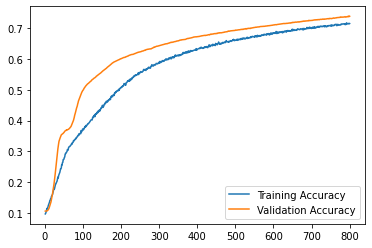

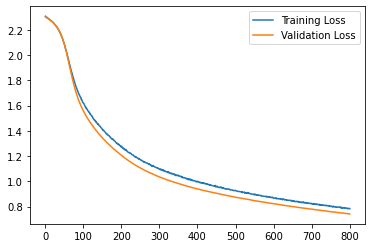

In [6]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy", "Validation Accuracy"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss", "Validation Loss"))
plt.show()

## Visualization of Performance on the Test Set

Here is a visualization of how well our classifier can do inference.

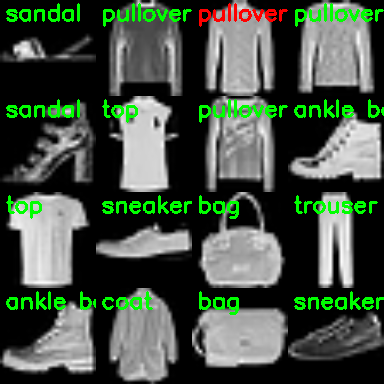

-1

In [7]:
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow

# initialize our list of output images
images = []

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")
    # initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
 
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

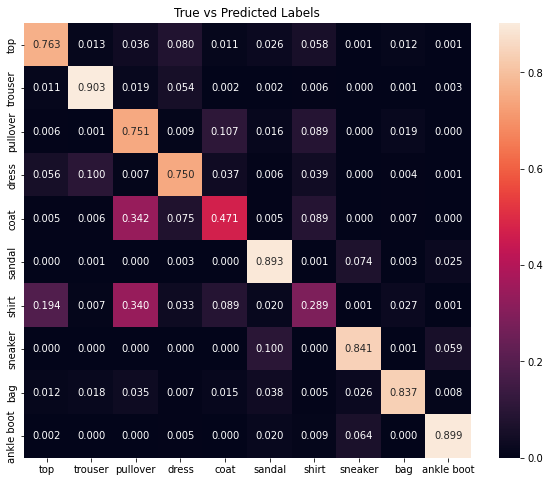

In [8]:
from seaborn import heatmap
allprobs = model.predict(x_test)
preds = allprobs.argmax(axis=1)
conmat = confusion_matrix(y_dec,preds,normalize='true')
fig,ax = plt.subplots(figsize = (10,8));
heatmap(conmat, annot=True, fmt="0.3f", ax=ax, cmap="rocket");
ax.set_xticklabels(labelNames);
ax.set_yticklabels(labelNames);
ax.set_title("True vs Predicted Labels");